In [ ]:
!pip install pennylane

In [2]:
import pennylane

In [ ]:
!pip install numpy
!pip install energyflow
!pip install particle
!pip install torch torchvision
!pip install torch-geometric
!pip install tqdm
!pip install networkx
!pip install matplotlib
!pip install scikit-learn

In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from torch_geometric.nn import GCNConv, GATConv
from torch.nn import Linear, ReLU, Sigmoid, Tanh, ModuleList, LeakyReLU, Sequential, Dropout
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Hyperparameters

In [2]:
n_connections = 3
input_dims = 8
hidden_dims = [8,8]
output_dims = 1
q_depth = 3
epochs = 20
lr = 1e-3
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
batch_size = 64

In [3]:
path = "/content/QG_jets.npz"

### Load the dataset

In [ ]:
energyflow.qg_jets.load(num_data=10000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/data')

In [5]:
dataset = np.load(os.path.expanduser('~/data/datasets/QG_jets.npz'))

In [6]:
dataset.files

['X', 'y']

In [7]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((100000, 139, 4), (100000,))

In [8]:
X.shape

(100000, 139, 4)

In [9]:
y.shape, y.dtype

((100000,), dtype('float64'))

#### Select jets with >= 10 particles

In [10]:
inds10 = np.logical_and(np.sum(X[:,:,0]>1e-10,axis=1)>=10,np.sum(X[:,:,0]>1e-10,axis=1)<=120)

In [11]:
X10 = X[inds10,:,:]
y10 = y[inds10]

In [12]:
X10.shape, y10.shape

((99870, 139, 4), (99870,))

#### Sort by transverse momentum

In [13]:
X_sorted = np.zeros((X10.shape[0], 10, X10.shape[2]))
for i in range(X10.shape[0]):
    sort_nodes = np.argsort(X10[i,:,0])[::-1]
    X_sorted[i,:,:] = X10[i,sort_nodes[:10],:]

In [14]:
X_sorted.shape

(99870, 10, 4)

In [15]:
X_sorted = X_sorted[:,:n_connections,:]
X_sorted.shape

(99870, 3, 4)

In [16]:
pid = Particle.from_pdgid(-2.11000000e+02)
pid.mass, pid.charge

(139.57039, -1.0)

In [17]:
def feature_engineer_dataset(X):

    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0)
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity)
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)

    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [18]:
X_new = feature_engineer_dataset(X_sorted)

In [19]:
X_new.shape

torch.Size([99870, 3, 8])

In [20]:
p = Particle.from_pdgid(2212)
print(p)

p


In [21]:
num_particles = torch.zeros(X_new.shape[0])
num_photons = torch.zeros(X_new.shape[0])
num_charged_hadrons = torch.zeros(X_new.shape[0])
num_neutral_hadrons = torch.zeros(X_new.shape[0])
num_particles.shape

torch.Size([99870])

In [22]:
inds = np.where(X10[2,:,0] > 1e-10)[0]
inds.shape[0]

57

In [23]:
for i in range(len(X10)):
    inds = np.where(X10[i,:,0] > 1e-10)[0]
    num_particles[i] = inds.shape[0]

    num_photons[i] = len(np.where(X10[i,inds,3] == 22)[0])

    num_charged_hadrons[i] = len(np.where(np.logical_or((abs(X10[i,inds,3]) == 211),
                                   (abs(X10[i,inds,3]) == 321),
                                   (abs(X10[i,inds,3]) == 2212)
                                  ) == True)[0])


    num_neutral_hadrons[i] = len(np.where(np.logical_or((abs(X[i,inds,3]) == 130),
                                   (abs(X[i,inds,3]) == 2112)
                                  ) == True)[0])                   # neutral hadron

In [24]:
pdgids = X10[0,:,3]
nonzero_pdgids = np.where(pdgids > 0)
nonzero_pdgids

(array([ 0,  1,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17]),)

In [25]:
pt = X10[0,nonzero_pdgids,0]
pt.shape, X10.shape

((1, 14), (99870, 139, 4))

In [26]:
pdgids = X10[:,:,3]
nonzero_pdgids = np.where(pdgids > 0)
mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
charge_particles = np.zeros(pdgids.shape)
charge_particles[nonzero_pdgids] = np.fromiter((i.charge if i.charge > 0 else 0 for i in mass_nonzeros), float)
pt = X10[:,:,0]
charge_jet_2 = np.sum(charge_particles * ((pt**0.2)/np.sum(pt)**0.2) , axis=1)
charge_jet_5 = np.sum(charge_particles * ((pt**0.5)/np.sum(pt)**0.5) , axis=1)
charge_jet_7 = np.sum(charge_particles * ((pt**0.7)/np.sum(pt)**0.7) , axis=1)

In [27]:
charge_jet = np.sum(charge_particles, axis=1)
charge_jet.shape

(99870,)

In [28]:
print(charge_jet_2.shape)
charge_jet_2

(99870,)


array([0.07898153, 0.1725243 , 0.52408037, ..., 0.17009737, 0.48479047,
       0.4587912 ])

In [29]:
charge_jet_7

array([2.48108168e-05, 8.78291430e-05, 1.99322411e-04, ...,
       4.69282329e-05, 1.52115589e-04, 2.57501495e-04])

In [30]:
graph_features = torch.stack((num_particles, num_photons, num_charged_hadrons, num_neutral_hadrons, torch.tensor(charge_jet)), dim=1)
graph_features.shape

torch.Size([99870, 5])

In [31]:
graph_features

tensor([[18., 12.,  6.,  0.,  2.],
        [17.,  7.,  8.,  1.,  4.],
        [57., 24., 24.,  6., 13.],
        ...,
        [16.,  6.,  9.,  0.,  5.],
        [88., 55., 26.,  3., 13.],
        [40., 15., 19.,  5., 12.]], dtype=torch.float64)

In [32]:
graph_features_norm = graph_features / torch.amax(graph_features, dim=(0))
graph_features_norm

tensor([[0.1500, 0.1644, 0.0923, 0.0000, 0.0588],
        [0.1417, 0.0959, 0.1231, 0.0909, 0.1176],
        [0.4750, 0.3288, 0.3692, 0.5455, 0.3824],
        ...,
        [0.1333, 0.0822, 0.1385, 0.0000, 0.1471],
        [0.7333, 0.7534, 0.4000, 0.2727, 0.3824],
        [0.3333, 0.2055, 0.2923, 0.4545, 0.3529]], dtype=torch.float64)

In [33]:
graph_features_norm.shape

torch.Size([99870, 5])

#### Normalize the dataset

In [34]:
torch.amax(X_new,dim=(0,1))

tensor([5.0142e+02, 1.9360e+00, 6.5275e+00, 1.0556e+03, 3.2500e+03, 4.9331e+02,
        4.7369e+02, 3.0296e+03])

In [35]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.
X_norm.shape

torch.Size([99870, 3, 8])

In [36]:
def strip_zeros(X):
    X_useful = []
    for Xi in X:
        inds = np.where(Xi[:,0] > 1e-10)
        X_useful.append(Xi[inds])

    return X_useful

In [37]:
X_preprocessed = strip_zeros(X_norm)
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(99870, torch.Size([3, 8]), torch.Size([3, 8]))

#### Form graph dataset

In [38]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = M-1         # number of neighbors of each node to be considered for edge connections (1 extra for self loops)
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))
    edge_attr = torch.zeros((M*N, 1))
    # adj_node_pairs = torch.zeros((, ))

    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[1:N+1]

        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)   # (max(distances) - distances[N_nearest])/(min(distances[distances > 0]))).reshape(N,

    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [39]:
def create_graph_dataset(X, y, graph_features):
    dataset = []

    for Xi, yi, gi in zip(X,y,graph_features):

        edge_index, edge_attr = create_graph(Xi)
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long), graph_features=gi)
        dataset.append(data)


    return dataset

In [40]:
dataset = create_graph_dataset(X_norm[:12500, :3, :],y10[:12500], graph_features_norm[:12500])

In [41]:
len(dataset), dataset[0]

(12500,
 Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=1, graph_features=[5]))

In [42]:
dataset[0].edge_index

tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 1, 0]], dtype=torch.int32)

In [43]:
dataset[0].edge_attr

tensor([[0.0006],
        [0.0016],
        [0.0006],
        [0.0011],
        [0.0011],
        [0.0016]])

In [44]:
dataset[0].edge_attr

tensor([[0.0006],
        [0.0016],
        [0.0006],
        [0.0011],
        [0.0011],
        [0.0016]])

In [45]:
dataset[0].edge_attr

tensor([[0.0006],
        [0.0016],
        [0.0006],
        [0.0011],
        [0.0011],
        [0.0016]])

In [46]:
for i in range(8):
    quarks = len([j for j in range(i*12500, (i+1)*12500) if y[j]==1])
    gluons = len([j for j in range(i*12500, (i+1)*12500) if y[j]==0])
    print(i, quarks, gluons)

0 6325 6175
1 6266 6234
2 6247 6253
3 6190 6310
4 6336 6164
5 6170 6330
6 6297 6203
7 6169 6331


In [47]:
batch_size = 64

In [48]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

In [49]:
train_dataloader = DataLoader(data_train,
                              batch_size = batch_size,
                              shuffle=True)
val_dataloader = DataLoader(data_val,
                            batch_size = batch_size,
                            shuffle=True)
test_dataloader = DataLoader(data_test,
                         batch_size = batch_size,
                         shuffle=True)

In [50]:
len(train_dataloader)

118

In [51]:
for batch in train_dataloader:
    print(f"Batch node features shape: {batch.x.shape}")
    print(f"Batch edge indices shape: {batch.edge_index.shape}")
    print(f"Batch edge attributes shape: {batch.edge_attr.shape}")
    print(f"Batch target shape: {batch.y.shape}")
    break


Batch node features shape: torch.Size([192, 8])
Batch edge indices shape: torch.Size([2, 384])
Batch edge attributes shape: torch.Size([384, 1])
Batch target shape: torch.Size([64])


### Train functions

In [52]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True, quantum=False):
    if train:
        model.train()
    else:
        model.eval()

    loss = 0
    net_loss = 0
    correct = 0

    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):

        target = data.y

        #This will zero out the gradients for this batch.
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.edge_attr, data.batch, data.graph_features)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float()
        # since we are working with logits and not probabilities (sigmoid is applied while computing loss), we consider 0 as threshold

#         _, pred = torch.max(F.softmax(output,dim=1).data, dim=1)
        correct += (pred == target).sum()


    acc = correct / len(loader.dataset)
    net_loss /= len(loader.dataset)

    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")

    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          100. * acc))

    return net_loss, acc

In [53]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):

    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }
    best_model = model
    best_val_loss = 1000

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if(best_val_loss > val_loss):
            best_val_loss = val_loss
            best_model = model

    return history, best_model

In [54]:
def test_eval(model, test_dataloader):

    preds = []
    labels = []
    acc = 0
    for data in test_dataloader:

        target = data.y
        labels.append(target.detach().cpu().numpy())

        output = model(data.x, data.edge_index.type(torch.int64), data.edge_attr, data.batch, data.graph_features)
        preds.append(output.detach().cpu().numpy())  # Convert to numpy array
        # probs = Sigmoid()(output).detach().cpu().numpy()  # Convert to numpy array
        # preds.append(copy.deepcopy(output))

        target = target.unsqueeze(1).float()
        pred = (output > 0).float()
        acc += (pred == target).sum().item()

    acc = acc / len(test_dataloader.dataset)
    print("Test accuracy: ", 100. * acc)

    labels = np.concatenate(labels, axis=0)  # Concatenate lists into a single numpy array
    preds = np.concatenate(preds, axis=0)  # Concatenate lists into a single numpy array


    return labels, preds

In [55]:
def plot_loss(history, step=2):
    n = len(history['train_loss'])
    x = range(n)
    plt.plot(x, history['train_loss'], label='Train loss')
    plt.plot(x, history['val_loss'], label='Val loss')
    plt.plot(x, history['train_acc'], label='Train acc')
    plt.plot(x, history['val_acc'], label='Val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0,n,step), range(1,n+1,step))

    plt.legend()
    plt.show()

In [56]:
def plot_auc(model, test_dataloader):
    labels, preds = test_eval(model, test_dataloader)
    auc = roc_auc_score(labels, preds)
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [58]:
tensor_a = torch.randn(100, 4)

# Tensor of shape (12500, 1)
tensor_b = torch.randint(0, 10, (100, 1))

# Concatenate along the second dimension (dim=1)
result_tensor = torch.cat((tensor_a, tensor_b), dim=1)

print(result_tensor.shape)

torch.Size([100, 5])


In [59]:
eg = next(iter(train_dataloader))
eg.x.shape, eg.edge_index.shape, eg.edge_attr.shape, eg.batch.shape, eg.graph_features.shape

(torch.Size([192, 8]),
 torch.Size([2, 384]),
 torch.Size([384, 1]),
 torch.Size([192]),
 torch.Size([320]))

### PyTorch GAT

In [60]:
from torch_geometric.nn import GATConv

In [61]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dim, hidden_dims[0], edge_dim=1))

        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1], edge_dim=1))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(Linear(hidden_dims[-1]+5, 8),
                                     ReLU(),
#                                      Linear(16, 8),
#                                      ReLU(),
                                     Linear(8, output_dims)
                                    )

    def forward(self, x, edge_index, edge_weight, batch, graph_features):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weight)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

### PyTorch GCN

In [62]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GCNConv(input_dim, hidden_dims[0]))

        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(Linear(hidden_dims[-1]+5, 16),
                                     ReLU(),
                                     Linear(16, 8),
                                     ReLU(),
                                     Linear(8, output_dims)
                                    )

    def forward(self, x, edge_index, edge_weight, batch, graph_features):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weight)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

In [63]:
def find_ideal_particles(X, y, num_particles, min_particles, max_particles):
    train_loss = dict()
    val_loss = dict()
    train_acc = dict()
    val_acc = dict()
    auc = dict()

    for i in range(min_particles, max_particles+1):

        print("Particles per jet:",i)
        train_loss_i = []
        val_loss_i = []
        train_acc_i = []
        val_acc_i = []
        auc_i = []

        for j in range(8):

            X_filtered = X[j*12500:min(len(X), (j+1)*12500), :i, :]
            y_filtered = y[j*12500:min(len(X), (j+1)*12500)]
            num_particles_filtered = num_particles[j*12500:min(len(X), (j+1)*12500)]
            dataset = create_graph_dataset(X_filtered,y_filtered, num_particles_filtered)

            data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

            train_dataloader = DataLoader(data_train,
                                  batch_size = batch_size,
                                  shuffle=True)
            val_dataloader = DataLoader(data_val,
                                        batch_size = batch_size,
                                        shuffle=True)
            test_dataloader = DataLoader(data_test,
                             batch_size = batch_size,
                             shuffle=True)

            model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())

            optimizer = Adam(model.parameters(), 1e-2)
            lossFn = BCEWithLogitsLoss()
            history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

            ind = np.argmin(history['val_loss'])
            train_loss_i.append(history['train_loss'][ind])
            val_loss_i.append(history['val_loss'][ind])
            train_acc_i.append(history['train_acc'][ind])
            val_acc_i.append(history['val_acc'][ind])

            labels, preds = test_eval(best_model, test_dataloader)
            auc_i.append(roc_auc_score(labels, preds))

            plot_loss(history)
            print("*"*100)
            print()

        print()
        print()

        train_loss[i] = train_loss_i
        val_loss[i] = val_loss_i
        train_acc[i] = train_acc_i
        val_acc[i] = val_acc_i
        auc[i] = auc_i

    return train_loss, val_loss, train_acc, val_acc, auc

#### With all particles, complete graph, edge_weights

In [64]:
hidden_dims = [8,8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [65]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 100.97it/s]


Train Epoch: 0 	Loss: 0.563034, Accuracy: 5359/7500 (71%)
Val Epoch: 0 	Loss: 0.488693, Accuracy: 1931/2500 (77%)



118it [00:00, 122.79it/s]


Train Epoch: 1 	Loss: 0.496973, Accuracy: 5760/7500 (77%)
Val Epoch: 1 	Loss: 0.493372, Accuracy: 1935/2500 (77%)



118it [00:00, 134.77it/s]


Train Epoch: 2 	Loss: 0.487888, Accuracy: 5782/7500 (77%)
Val Epoch: 2 	Loss: 0.528026, Accuracy: 1909/2500 (76%)



118it [00:00, 133.00it/s]


Train Epoch: 3 	Loss: 0.483309, Accuracy: 5817/7500 (78%)
Val Epoch: 3 	Loss: 0.503297, Accuracy: 1923/2500 (77%)



118it [00:01, 93.41it/s]


Train Epoch: 4 	Loss: 0.483365, Accuracy: 5805/7500 (77%)
Val Epoch: 4 	Loss: 0.486304, Accuracy: 1947/2500 (78%)



118it [00:01, 90.89it/s] 


Train Epoch: 5 	Loss: 0.487982, Accuracy: 5821/7500 (78%)
Val Epoch: 5 	Loss: 0.491527, Accuracy: 1936/2500 (77%)



118it [00:00, 135.54it/s]


Train Epoch: 6 	Loss: 0.482599, Accuracy: 5818/7500 (78%)
Val Epoch: 6 	Loss: 0.524180, Accuracy: 1910/2500 (76%)



118it [00:00, 144.92it/s]


Train Epoch: 7 	Loss: 0.479704, Accuracy: 5845/7500 (78%)
Val Epoch: 7 	Loss: 0.488173, Accuracy: 1941/2500 (78%)



118it [00:00, 140.54it/s]


Train Epoch: 8 	Loss: 0.480081, Accuracy: 5807/7500 (77%)
Val Epoch: 8 	Loss: 0.506923, Accuracy: 1917/2500 (77%)



118it [00:00, 138.33it/s]


Train Epoch: 9 	Loss: 0.481137, Accuracy: 5832/7500 (78%)
Val Epoch: 9 	Loss: 0.487063, Accuracy: 1928/2500 (77%)



118it [00:00, 140.02it/s]


Train Epoch: 10 	Loss: 0.479583, Accuracy: 5868/7500 (78%)
Val Epoch: 10 	Loss: 0.508912, Accuracy: 1929/2500 (77%)



118it [00:00, 132.87it/s]


Train Epoch: 11 	Loss: 0.483210, Accuracy: 5839/7500 (78%)
Val Epoch: 11 	Loss: 0.502297, Accuracy: 1914/2500 (77%)



118it [00:00, 130.66it/s]


Train Epoch: 12 	Loss: 0.484369, Accuracy: 5843/7500 (78%)
Val Epoch: 12 	Loss: 0.493295, Accuracy: 1935/2500 (77%)



118it [00:00, 131.47it/s]


Train Epoch: 13 	Loss: 0.476920, Accuracy: 5854/7500 (78%)
Val Epoch: 13 	Loss: 0.515197, Accuracy: 1919/2500 (77%)



118it [00:01, 117.25it/s]


Train Epoch: 14 	Loss: 0.476128, Accuracy: 5847/7500 (78%)
Val Epoch: 14 	Loss: 0.495490, Accuracy: 1932/2500 (77%)



118it [00:01, 79.81it/s]


Train Epoch: 15 	Loss: 0.475961, Accuracy: 5862/7500 (78%)
Val Epoch: 15 	Loss: 0.502704, Accuracy: 1925/2500 (77%)



118it [00:00, 139.63it/s]


Train Epoch: 16 	Loss: 0.479275, Accuracy: 5840/7500 (78%)
Val Epoch: 16 	Loss: 0.487850, Accuracy: 1945/2500 (78%)



118it [00:00, 140.23it/s]


Train Epoch: 17 	Loss: 0.478271, Accuracy: 5842/7500 (78%)
Val Epoch: 17 	Loss: 0.499446, Accuracy: 1939/2500 (78%)



118it [00:00, 126.19it/s]


Train Epoch: 18 	Loss: 0.479192, Accuracy: 5865/7500 (78%)
Val Epoch: 18 	Loss: 0.494892, Accuracy: 1933/2500 (77%)



118it [00:00, 137.79it/s]


Train Epoch: 19 	Loss: 0.477058, Accuracy: 5857/7500 (78%)
Val Epoch: 19 	Loss: 0.488145, Accuracy: 1932/2500 (77%)



118it [00:00, 135.82it/s]


Train Epoch: 20 	Loss: 0.477032, Accuracy: 5863/7500 (78%)
Val Epoch: 20 	Loss: 0.502935, Accuracy: 1935/2500 (77%)



118it [00:00, 133.93it/s]


Train Epoch: 21 	Loss: 0.476582, Accuracy: 5850/7500 (78%)
Val Epoch: 21 	Loss: 0.490461, Accuracy: 1937/2500 (77%)



118it [00:00, 133.06it/s]


Train Epoch: 22 	Loss: 0.474948, Accuracy: 5858/7500 (78%)
Val Epoch: 22 	Loss: 0.481786, Accuracy: 1937/2500 (77%)



118it [00:00, 133.50it/s]


Train Epoch: 23 	Loss: 0.473197, Accuracy: 5852/7500 (78%)
Val Epoch: 23 	Loss: 0.488318, Accuracy: 1940/2500 (78%)



118it [00:00, 135.23it/s]


Train Epoch: 24 	Loss: 0.477159, Accuracy: 5836/7500 (78%)
Val Epoch: 24 	Loss: 0.483572, Accuracy: 1938/2500 (78%)



118it [00:01, 98.13it/s] 


Train Epoch: 25 	Loss: 0.475145, Accuracy: 5858/7500 (78%)
Val Epoch: 25 	Loss: 0.487389, Accuracy: 1933/2500 (77%)



118it [00:01, 102.17it/s]


Train Epoch: 26 	Loss: 0.476074, Accuracy: 5839/7500 (78%)
Val Epoch: 26 	Loss: 0.483157, Accuracy: 1951/2500 (78%)



118it [00:00, 140.26it/s]


Train Epoch: 27 	Loss: 0.474899, Accuracy: 5869/7500 (78%)
Val Epoch: 27 	Loss: 0.492537, Accuracy: 1935/2500 (77%)



118it [00:00, 138.06it/s]


Train Epoch: 28 	Loss: 0.471648, Accuracy: 5863/7500 (78%)
Val Epoch: 28 	Loss: 0.492154, Accuracy: 1930/2500 (77%)



118it [00:00, 134.73it/s]


Train Epoch: 29 	Loss: 0.473377, Accuracy: 5867/7500 (78%)
Val Epoch: 29 	Loss: 0.504826, Accuracy: 1938/2500 (78%)



118it [00:00, 140.31it/s]


Train Epoch: 30 	Loss: 0.472468, Accuracy: 5846/7500 (78%)
Val Epoch: 30 	Loss: 0.492899, Accuracy: 1954/2500 (78%)



118it [00:00, 136.76it/s]


Train Epoch: 31 	Loss: 0.471077, Accuracy: 5889/7500 (79%)
Val Epoch: 31 	Loss: 0.498189, Accuracy: 1937/2500 (77%)



118it [00:00, 131.05it/s]


Train Epoch: 32 	Loss: 0.472546, Accuracy: 5868/7500 (78%)
Val Epoch: 32 	Loss: 0.498469, Accuracy: 1946/2500 (78%)



118it [00:00, 134.68it/s]


Train Epoch: 33 	Loss: 0.473920, Accuracy: 5849/7500 (78%)
Val Epoch: 33 	Loss: 0.487730, Accuracy: 1946/2500 (78%)



118it [00:00, 135.27it/s]


Train Epoch: 34 	Loss: 0.471678, Accuracy: 5871/7500 (78%)
Val Epoch: 34 	Loss: 0.486668, Accuracy: 1937/2500 (77%)



118it [00:01, 114.14it/s]


Train Epoch: 35 	Loss: 0.473802, Accuracy: 5857/7500 (78%)
Val Epoch: 35 	Loss: 0.482680, Accuracy: 1942/2500 (78%)



118it [00:01, 82.51it/s]


Train Epoch: 36 	Loss: 0.474685, Accuracy: 5854/7500 (78%)
Val Epoch: 36 	Loss: 0.492391, Accuracy: 1943/2500 (78%)



118it [00:01, 79.34it/s]


Train Epoch: 37 	Loss: 0.472863, Accuracy: 5880/7500 (78%)
Val Epoch: 37 	Loss: 0.491156, Accuracy: 1947/2500 (78%)



118it [00:01, 114.76it/s]


Train Epoch: 38 	Loss: 0.471413, Accuracy: 5872/7500 (78%)
Val Epoch: 38 	Loss: 0.490025, Accuracy: 1939/2500 (78%)



118it [00:00, 135.35it/s]


Train Epoch: 39 	Loss: 0.472642, Accuracy: 5847/7500 (78%)
Val Epoch: 39 	Loss: 0.484167, Accuracy: 1954/2500 (78%)



Test accuracy:  78.4


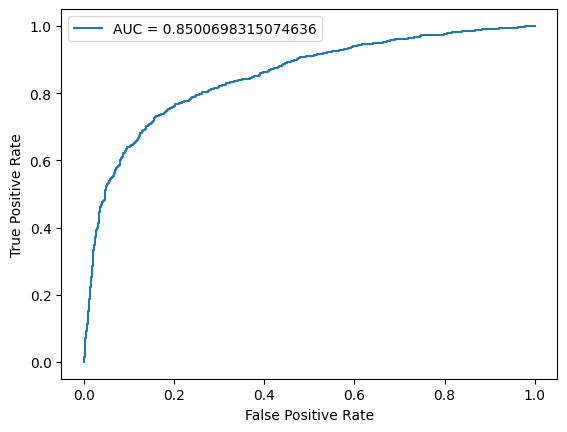

In [66]:
plot_auc(best_model, test_dataloader)

### 100K jets

#### GAT - 5 particles

In [67]:
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [68]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 101.27it/s]


Train Epoch: 0 	Loss: 0.692132, Accuracy: 3766/7500 (50%)
Val Epoch: 0 	Loss: 0.694276, Accuracy: 1317/2500 (53%)



118it [00:01, 102.21it/s]


Train Epoch: 1 	Loss: 0.664310, Accuracy: 5137/7500 (68%)
Val Epoch: 1 	Loss: 0.650777, Accuracy: 1904/2500 (76%)



118it [00:01, 107.18it/s]


Train Epoch: 2 	Loss: 0.613835, Accuracy: 5670/7500 (76%)
Val Epoch: 2 	Loss: 0.591179, Accuracy: 1898/2500 (76%)



118it [00:01, 99.66it/s]


Train Epoch: 3 	Loss: 0.558224, Accuracy: 5722/7500 (76%)
Val Epoch: 3 	Loss: 0.537232, Accuracy: 1925/2500 (77%)



118it [00:01, 73.86it/s]


Train Epoch: 4 	Loss: 0.516582, Accuracy: 5769/7500 (77%)
Val Epoch: 4 	Loss: 0.506945, Accuracy: 1941/2500 (78%)



118it [00:01, 85.74it/s]


Train Epoch: 5 	Loss: 0.494751, Accuracy: 5804/7500 (77%)
Val Epoch: 5 	Loss: 0.497063, Accuracy: 1925/2500 (77%)



118it [00:01, 104.00it/s]


Train Epoch: 6 	Loss: 0.491124, Accuracy: 5837/7500 (78%)
Val Epoch: 6 	Loss: 0.488292, Accuracy: 1936/2500 (77%)



118it [00:01, 101.29it/s]


Train Epoch: 7 	Loss: 0.485904, Accuracy: 5822/7500 (78%)
Val Epoch: 7 	Loss: 0.489798, Accuracy: 1945/2500 (78%)



118it [00:01, 96.94it/s]


Train Epoch: 8 	Loss: 0.485817, Accuracy: 5836/7500 (78%)
Val Epoch: 8 	Loss: 0.494080, Accuracy: 1934/2500 (77%)



118it [00:01, 92.92it/s]


Train Epoch: 9 	Loss: 0.484115, Accuracy: 5827/7500 (78%)
Val Epoch: 9 	Loss: 0.492596, Accuracy: 1933/2500 (77%)



118it [00:01, 100.91it/s]


Train Epoch: 10 	Loss: 0.484345, Accuracy: 5839/7500 (78%)
Val Epoch: 10 	Loss: 0.487345, Accuracy: 1931/2500 (77%)



118it [00:01, 105.36it/s]


Train Epoch: 11 	Loss: 0.483349, Accuracy: 5827/7500 (78%)
Val Epoch: 11 	Loss: 0.486505, Accuracy: 1931/2500 (77%)



118it [00:01, 74.20it/s]


Train Epoch: 12 	Loss: 0.482968, Accuracy: 5822/7500 (78%)
Val Epoch: 12 	Loss: 0.486379, Accuracy: 1935/2500 (77%)



118it [00:01, 84.81it/s]


Train Epoch: 13 	Loss: 0.482617, Accuracy: 5833/7500 (78%)
Val Epoch: 13 	Loss: 0.485399, Accuracy: 1939/2500 (78%)



118it [00:01, 103.89it/s]


Train Epoch: 14 	Loss: 0.483182, Accuracy: 5834/7500 (78%)
Val Epoch: 14 	Loss: 0.486785, Accuracy: 1938/2500 (78%)



118it [00:01, 103.07it/s]


Train Epoch: 15 	Loss: 0.480891, Accuracy: 5837/7500 (78%)
Val Epoch: 15 	Loss: 0.486959, Accuracy: 1934/2500 (77%)



118it [00:01, 104.69it/s]


Train Epoch: 16 	Loss: 0.481502, Accuracy: 5830/7500 (78%)
Val Epoch: 16 	Loss: 0.495449, Accuracy: 1934/2500 (77%)



118it [00:01, 68.22it/s]


Train Epoch: 17 	Loss: 0.480796, Accuracy: 5837/7500 (78%)
Val Epoch: 17 	Loss: 0.483847, Accuracy: 1933/2500 (77%)



118it [00:01, 74.48it/s]


Train Epoch: 18 	Loss: 0.480153, Accuracy: 5825/7500 (78%)
Val Epoch: 18 	Loss: 0.497491, Accuracy: 1933/2500 (77%)



118it [00:02, 46.32it/s]


Train Epoch: 19 	Loss: 0.479617, Accuracy: 5835/7500 (78%)
Val Epoch: 19 	Loss: 0.490915, Accuracy: 1943/2500 (78%)



118it [00:01, 77.42it/s]


Train Epoch: 20 	Loss: 0.481895, Accuracy: 5837/7500 (78%)
Val Epoch: 20 	Loss: 0.495810, Accuracy: 1936/2500 (77%)



118it [00:01, 95.18it/s]


Train Epoch: 21 	Loss: 0.479881, Accuracy: 5852/7500 (78%)
Val Epoch: 21 	Loss: 0.502881, Accuracy: 1937/2500 (77%)



118it [00:01, 101.33it/s]


Train Epoch: 22 	Loss: 0.479997, Accuracy: 5841/7500 (78%)
Val Epoch: 22 	Loss: 0.494001, Accuracy: 1939/2500 (78%)



118it [00:01, 105.18it/s]


Train Epoch: 23 	Loss: 0.482414, Accuracy: 5843/7500 (78%)
Val Epoch: 23 	Loss: 0.487969, Accuracy: 1937/2500 (77%)



118it [00:01, 104.96it/s]


Train Epoch: 24 	Loss: 0.480364, Accuracy: 5854/7500 (78%)
Val Epoch: 24 	Loss: 0.493378, Accuracy: 1927/2500 (77%)



118it [00:01, 109.07it/s]


Train Epoch: 25 	Loss: 0.479671, Accuracy: 5845/7500 (78%)
Val Epoch: 25 	Loss: 0.484206, Accuracy: 1928/2500 (77%)



118it [00:01, 105.80it/s]


Train Epoch: 26 	Loss: 0.479522, Accuracy: 5846/7500 (78%)
Val Epoch: 26 	Loss: 0.498124, Accuracy: 1932/2500 (77%)



118it [00:01, 98.24it/s]


Train Epoch: 27 	Loss: 0.481239, Accuracy: 5843/7500 (78%)
Val Epoch: 27 	Loss: 0.495799, Accuracy: 1935/2500 (77%)



118it [00:01, 66.43it/s]


Train Epoch: 28 	Loss: 0.480032, Accuracy: 5841/7500 (78%)
Val Epoch: 28 	Loss: 0.492412, Accuracy: 1934/2500 (77%)



118it [00:01, 106.90it/s]


Train Epoch: 29 	Loss: 0.478093, Accuracy: 5845/7500 (78%)
Val Epoch: 29 	Loss: 0.489547, Accuracy: 1933/2500 (77%)



118it [00:01, 103.26it/s]


Train Epoch: 30 	Loss: 0.480812, Accuracy: 5851/7500 (78%)
Val Epoch: 30 	Loss: 0.493892, Accuracy: 1934/2500 (77%)



118it [00:01, 102.15it/s]


Train Epoch: 31 	Loss: 0.480063, Accuracy: 5844/7500 (78%)
Val Epoch: 31 	Loss: 0.495315, Accuracy: 1932/2500 (77%)



118it [00:01, 106.07it/s]


Train Epoch: 32 	Loss: 0.479483, Accuracy: 5848/7500 (78%)
Val Epoch: 32 	Loss: 0.484689, Accuracy: 1931/2500 (77%)



118it [00:01, 102.08it/s]


Train Epoch: 33 	Loss: 0.477579, Accuracy: 5847/7500 (78%)
Val Epoch: 33 	Loss: 0.497300, Accuracy: 1935/2500 (77%)



118it [00:01, 95.92it/s] 


Train Epoch: 34 	Loss: 0.479727, Accuracy: 5853/7500 (78%)
Val Epoch: 34 	Loss: 0.488477, Accuracy: 1936/2500 (77%)



118it [00:01, 108.08it/s]


Train Epoch: 35 	Loss: 0.478729, Accuracy: 5849/7500 (78%)
Val Epoch: 35 	Loss: 0.513114, Accuracy: 1934/2500 (77%)



118it [00:01, 70.05it/s]


Train Epoch: 36 	Loss: 0.478546, Accuracy: 5843/7500 (78%)
Val Epoch: 36 	Loss: 0.487155, Accuracy: 1939/2500 (78%)



118it [00:01, 95.06it/s] 


Train Epoch: 37 	Loss: 0.479182, Accuracy: 5851/7500 (78%)
Val Epoch: 37 	Loss: 0.488792, Accuracy: 1932/2500 (77%)



118it [00:01, 99.80it/s] 


Train Epoch: 38 	Loss: 0.478414, Accuracy: 5853/7500 (78%)
Val Epoch: 38 	Loss: 0.480014, Accuracy: 1933/2500 (77%)



118it [00:01, 103.13it/s]


Train Epoch: 39 	Loss: 0.478070, Accuracy: 5849/7500 (78%)
Val Epoch: 39 	Loss: 0.493796, Accuracy: 1936/2500 (77%)



118it [00:01, 103.77it/s]


Train Epoch: 40 	Loss: 0.477649, Accuracy: 5860/7500 (78%)
Val Epoch: 40 	Loss: 0.485627, Accuracy: 1937/2500 (77%)



118it [00:01, 98.79it/s] 


Train Epoch: 41 	Loss: 0.480239, Accuracy: 5852/7500 (78%)
Val Epoch: 41 	Loss: 0.488099, Accuracy: 1934/2500 (77%)



118it [00:01, 103.02it/s]


Train Epoch: 42 	Loss: 0.478115, Accuracy: 5861/7500 (78%)
Val Epoch: 42 	Loss: 0.497810, Accuracy: 1940/2500 (78%)



118it [00:01, 99.78it/s] 


Train Epoch: 43 	Loss: 0.477895, Accuracy: 5856/7500 (78%)
Val Epoch: 43 	Loss: 0.499299, Accuracy: 1939/2500 (78%)



118it [00:01, 75.26it/s]


Train Epoch: 44 	Loss: 0.479643, Accuracy: 5856/7500 (78%)
Val Epoch: 44 	Loss: 0.484697, Accuracy: 1938/2500 (78%)



118it [00:01, 88.40it/s] 


Train Epoch: 45 	Loss: 0.476507, Accuracy: 5850/7500 (78%)
Val Epoch: 45 	Loss: 0.482876, Accuracy: 1936/2500 (77%)



118it [00:01, 107.52it/s]


Train Epoch: 46 	Loss: 0.477376, Accuracy: 5858/7500 (78%)
Val Epoch: 46 	Loss: 0.483226, Accuracy: 1941/2500 (78%)



118it [00:01, 104.22it/s]


Train Epoch: 47 	Loss: 0.478699, Accuracy: 5846/7500 (78%)
Val Epoch: 47 	Loss: 0.493748, Accuracy: 1930/2500 (77%)



118it [00:01, 102.85it/s]


Train Epoch: 48 	Loss: 0.476893, Accuracy: 5859/7500 (78%)
Val Epoch: 48 	Loss: 0.485945, Accuracy: 1936/2500 (77%)



118it [00:01, 105.98it/s]


Train Epoch: 49 	Loss: 0.477566, Accuracy: 5862/7500 (78%)
Val Epoch: 49 	Loss: 0.510418, Accuracy: 1940/2500 (78%)



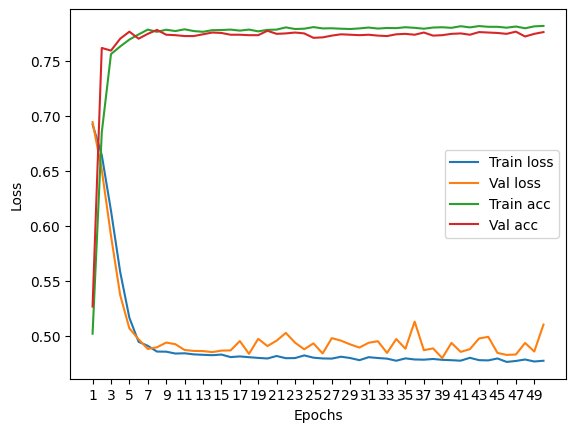

In [69]:
plot_loss(history)

Test accuracy:  77.44


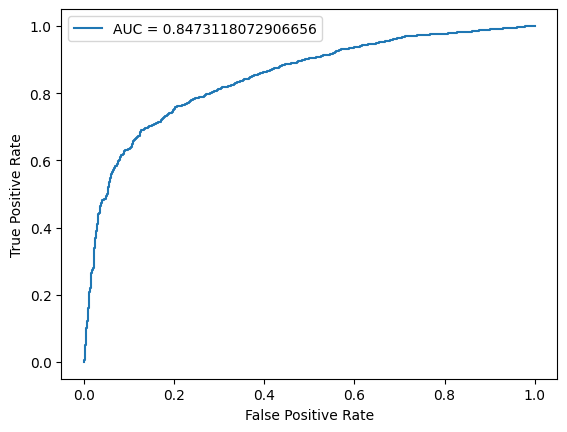

In [70]:
plot_auc(best_model, test_dataloader)

#### GAT - With 5 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, charge of jet with k = 0.2, 0.5, 0.7) count

In [71]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [72]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 100.81it/s]


Train Epoch: 0 	Loss: 0.699719, Accuracy: 3762/7500 (50%)
Val Epoch: 0 	Loss: 0.705165, Accuracy: 1205/2500 (48%)



118it [00:01, 106.35it/s]


Train Epoch: 1 	Loss: 0.686020, Accuracy: 4177/7500 (56%)
Val Epoch: 1 	Loss: 0.691418, Accuracy: 1537/2500 (61%)



118it [00:01, 64.14it/s]


Train Epoch: 2 	Loss: 0.662808, Accuracy: 5464/7500 (73%)
Val Epoch: 2 	Loss: 0.652361, Accuracy: 1909/2500 (76%)



118it [00:01, 103.97it/s]


Train Epoch: 3 	Loss: 0.610638, Accuracy: 5675/7500 (76%)
Val Epoch: 3 	Loss: 0.593615, Accuracy: 1873/2500 (75%)



118it [00:01, 102.00it/s]


Train Epoch: 4 	Loss: 0.553008, Accuracy: 5728/7500 (76%)
Val Epoch: 4 	Loss: 0.545165, Accuracy: 1889/2500 (76%)



118it [00:01, 104.00it/s]


Train Epoch: 5 	Loss: 0.518111, Accuracy: 5735/7500 (76%)
Val Epoch: 5 	Loss: 0.526784, Accuracy: 1898/2500 (76%)



118it [00:01, 105.84it/s]


Train Epoch: 6 	Loss: 0.505320, Accuracy: 5747/7500 (77%)
Val Epoch: 6 	Loss: 0.513670, Accuracy: 1897/2500 (76%)



118it [00:01, 105.57it/s]


Train Epoch: 7 	Loss: 0.499722, Accuracy: 5754/7500 (77%)
Val Epoch: 7 	Loss: 0.510855, Accuracy: 1907/2500 (76%)



118it [00:01, 98.99it/s] 


Train Epoch: 8 	Loss: 0.497723, Accuracy: 5765/7500 (77%)
Val Epoch: 8 	Loss: 0.512349, Accuracy: 1906/2500 (76%)



118it [00:01, 103.62it/s]


Train Epoch: 9 	Loss: 0.494049, Accuracy: 5793/7500 (77%)
Val Epoch: 9 	Loss: 0.500009, Accuracy: 1904/2500 (76%)



118it [00:01, 71.46it/s]


Train Epoch: 10 	Loss: 0.493275, Accuracy: 5778/7500 (77%)
Val Epoch: 10 	Loss: 0.501939, Accuracy: 1904/2500 (76%)



118it [00:01, 98.78it/s] 


Train Epoch: 11 	Loss: 0.489648, Accuracy: 5799/7500 (77%)
Val Epoch: 11 	Loss: 0.500495, Accuracy: 1918/2500 (77%)



118it [00:01, 101.31it/s]


Train Epoch: 12 	Loss: 0.489869, Accuracy: 5810/7500 (77%)
Val Epoch: 12 	Loss: 0.506325, Accuracy: 1916/2500 (77%)



118it [00:01, 104.07it/s]


Train Epoch: 13 	Loss: 0.489553, Accuracy: 5803/7500 (77%)
Val Epoch: 13 	Loss: 0.520634, Accuracy: 1919/2500 (77%)



118it [00:01, 96.73it/s] 


Train Epoch: 14 	Loss: 0.485953, Accuracy: 5814/7500 (78%)
Val Epoch: 14 	Loss: 0.491873, Accuracy: 1919/2500 (77%)



118it [00:01, 100.20it/s]


Train Epoch: 15 	Loss: 0.486551, Accuracy: 5805/7500 (77%)
Val Epoch: 15 	Loss: 0.502367, Accuracy: 1925/2500 (77%)



118it [00:01, 108.22it/s]


Train Epoch: 16 	Loss: 0.486595, Accuracy: 5805/7500 (77%)
Val Epoch: 16 	Loss: 0.497832, Accuracy: 1925/2500 (77%)



118it [00:01, 99.91it/s]


Train Epoch: 17 	Loss: 0.484936, Accuracy: 5810/7500 (77%)
Val Epoch: 17 	Loss: 0.514797, Accuracy: 1923/2500 (77%)



118it [00:01, 78.50it/s]


Train Epoch: 18 	Loss: 0.484458, Accuracy: 5818/7500 (78%)
Val Epoch: 18 	Loss: 0.498354, Accuracy: 1925/2500 (77%)



118it [00:01, 77.80it/s]


Train Epoch: 19 	Loss: 0.483829, Accuracy: 5818/7500 (78%)
Val Epoch: 19 	Loss: 0.510916, Accuracy: 1922/2500 (77%)



118it [00:01, 91.42it/s]


Train Epoch: 20 	Loss: 0.483856, Accuracy: 5825/7500 (78%)
Val Epoch: 20 	Loss: 0.501156, Accuracy: 1926/2500 (77%)



118it [00:01, 88.23it/s]


Train Epoch: 21 	Loss: 0.482527, Accuracy: 5824/7500 (78%)
Val Epoch: 21 	Loss: 0.511819, Accuracy: 1925/2500 (77%)



118it [00:01, 100.04it/s]


Train Epoch: 22 	Loss: 0.481109, Accuracy: 5810/7500 (77%)
Val Epoch: 22 	Loss: 0.495931, Accuracy: 1929/2500 (77%)



118it [00:01, 105.11it/s]


Train Epoch: 23 	Loss: 0.483897, Accuracy: 5840/7500 (78%)
Val Epoch: 23 	Loss: 0.499806, Accuracy: 1931/2500 (77%)



118it [00:01, 86.29it/s]


Train Epoch: 24 	Loss: 0.486056, Accuracy: 5826/7500 (78%)
Val Epoch: 24 	Loss: 0.499820, Accuracy: 1931/2500 (77%)



118it [00:01, 95.23it/s]


Train Epoch: 25 	Loss: 0.483621, Accuracy: 5805/7500 (77%)
Val Epoch: 25 	Loss: 0.492504, Accuracy: 1928/2500 (77%)



118it [00:01, 62.11it/s]


Train Epoch: 26 	Loss: 0.482460, Accuracy: 5824/7500 (78%)
Val Epoch: 26 	Loss: 0.499787, Accuracy: 1927/2500 (77%)



118it [00:01, 100.87it/s]


Train Epoch: 27 	Loss: 0.481191, Accuracy: 5830/7500 (78%)
Val Epoch: 27 	Loss: 0.507001, Accuracy: 1932/2500 (77%)



118it [00:01, 102.25it/s]


Train Epoch: 28 	Loss: 0.480041, Accuracy: 5826/7500 (78%)
Val Epoch: 28 	Loss: 0.508019, Accuracy: 1930/2500 (77%)



118it [00:01, 99.20it/s]


Train Epoch: 29 	Loss: 0.483661, Accuracy: 5852/7500 (78%)
Val Epoch: 29 	Loss: 0.493075, Accuracy: 1929/2500 (77%)



118it [00:01, 105.18it/s]


Train Epoch: 30 	Loss: 0.479809, Accuracy: 5831/7500 (78%)
Val Epoch: 30 	Loss: 0.513443, Accuracy: 1929/2500 (77%)



118it [00:01, 101.66it/s]


Train Epoch: 31 	Loss: 0.481652, Accuracy: 5822/7500 (78%)
Val Epoch: 31 	Loss: 0.486980, Accuracy: 1933/2500 (77%)



118it [00:01, 101.33it/s]


Train Epoch: 32 	Loss: 0.480535, Accuracy: 5832/7500 (78%)
Val Epoch: 32 	Loss: 0.491588, Accuracy: 1933/2500 (77%)



118it [00:01, 96.28it/s]


Train Epoch: 33 	Loss: 0.480056, Accuracy: 5840/7500 (78%)
Val Epoch: 33 	Loss: 0.502236, Accuracy: 1932/2500 (77%)



118it [00:01, 70.53it/s]


Train Epoch: 34 	Loss: 0.478953, Accuracy: 5847/7500 (78%)
Val Epoch: 34 	Loss: 0.508029, Accuracy: 1934/2500 (77%)



118it [00:01, 99.38it/s]


Train Epoch: 35 	Loss: 0.481910, Accuracy: 5827/7500 (78%)
Val Epoch: 35 	Loss: 0.497136, Accuracy: 1930/2500 (77%)



118it [00:01, 94.09it/s]


Train Epoch: 36 	Loss: 0.481698, Accuracy: 5820/7500 (78%)
Val Epoch: 36 	Loss: 0.486468, Accuracy: 1932/2500 (77%)



118it [00:01, 98.12it/s]


Train Epoch: 37 	Loss: 0.480530, Accuracy: 5847/7500 (78%)
Val Epoch: 37 	Loss: 0.497806, Accuracy: 1933/2500 (77%)



118it [00:01, 103.27it/s]


Train Epoch: 38 	Loss: 0.478714, Accuracy: 5838/7500 (78%)
Val Epoch: 38 	Loss: 0.490408, Accuracy: 1928/2500 (77%)



118it [00:01, 95.56it/s]


Train Epoch: 39 	Loss: 0.478030, Accuracy: 5840/7500 (78%)
Val Epoch: 39 	Loss: 0.491607, Accuracy: 1928/2500 (77%)



118it [00:01, 104.88it/s]


Train Epoch: 40 	Loss: 0.478885, Accuracy: 5862/7500 (78%)
Val Epoch: 40 	Loss: 0.495680, Accuracy: 1936/2500 (77%)



118it [00:01, 88.96it/s]


Train Epoch: 41 	Loss: 0.477548, Accuracy: 5846/7500 (78%)
Val Epoch: 41 	Loss: 0.490682, Accuracy: 1937/2500 (77%)



118it [00:01, 64.14it/s]


Train Epoch: 42 	Loss: 0.478794, Accuracy: 5845/7500 (78%)
Val Epoch: 42 	Loss: 0.498829, Accuracy: 1930/2500 (77%)



118it [00:01, 99.36it/s]


Train Epoch: 43 	Loss: 0.480572, Accuracy: 5842/7500 (78%)
Val Epoch: 43 	Loss: 0.498990, Accuracy: 1938/2500 (78%)



118it [00:01, 100.44it/s]


Train Epoch: 44 	Loss: 0.480846, Accuracy: 5842/7500 (78%)
Val Epoch: 44 	Loss: 0.487099, Accuracy: 1932/2500 (77%)



118it [00:01, 101.04it/s]


Train Epoch: 45 	Loss: 0.478117, Accuracy: 5859/7500 (78%)
Val Epoch: 45 	Loss: 0.501796, Accuracy: 1931/2500 (77%)



118it [00:01, 103.12it/s]


Train Epoch: 46 	Loss: 0.479986, Accuracy: 5846/7500 (78%)
Val Epoch: 46 	Loss: 0.493588, Accuracy: 1941/2500 (78%)



118it [00:01, 93.62it/s]


Train Epoch: 47 	Loss: 0.479921, Accuracy: 5847/7500 (78%)
Val Epoch: 47 	Loss: 0.488511, Accuracy: 1939/2500 (78%)



118it [00:01, 94.14it/s]


Train Epoch: 48 	Loss: 0.478195, Accuracy: 5848/7500 (78%)
Val Epoch: 48 	Loss: 0.489800, Accuracy: 1937/2500 (77%)



118it [00:01, 78.25it/s]


Train Epoch: 49 	Loss: 0.477983, Accuracy: 5849/7500 (78%)
Val Epoch: 49 	Loss: 0.484591, Accuracy: 1938/2500 (78%)



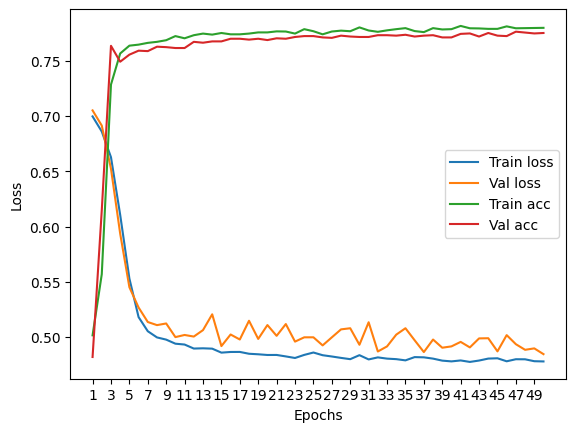

In [73]:
plot_loss(history)

Test accuracy:  77.4


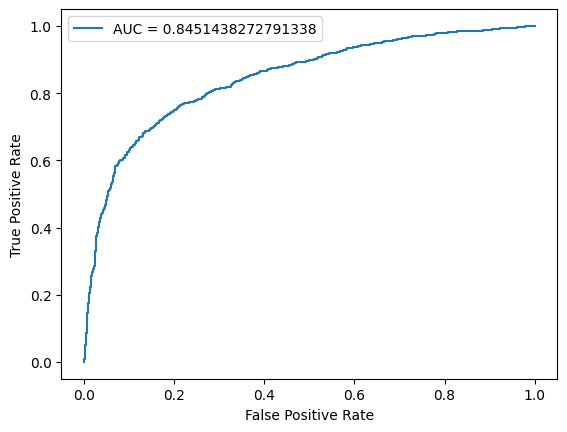

In [74]:
plot_auc(best_model, test_dataloader)

### 12500 jets

#### With 10 particles, charge, complete graph, edge_weights, (photon, CH, NH) count

In [75]:
input_dims = 9
hidden_dims = [9, 9]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x GCNConv(9, 9)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [78]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 109.11it/s]


Train Epoch: 0 	Loss: 0.538979, Accuracy: 5615/7500 (75%)
Val Epoch: 0 	Loss: 0.489073, Accuracy: 1942/2500 (78%)



118it [00:01, 83.59it/s]


Train Epoch: 1 	Loss: 0.490145, Accuracy: 5806/7500 (77%)
Val Epoch: 1 	Loss: 0.516104, Accuracy: 1894/2500 (76%)



118it [00:00, 136.06it/s]


Train Epoch: 2 	Loss: 0.486803, Accuracy: 5795/7500 (77%)
Val Epoch: 2 	Loss: 0.526379, Accuracy: 1867/2500 (75%)



118it [00:00, 134.59it/s]


Train Epoch: 3 	Loss: 0.486189, Accuracy: 5808/7500 (77%)
Val Epoch: 3 	Loss: 0.490307, Accuracy: 1932/2500 (77%)



118it [00:00, 133.42it/s]


Train Epoch: 4 	Loss: 0.484108, Accuracy: 5815/7500 (78%)
Val Epoch: 4 	Loss: 0.486295, Accuracy: 1942/2500 (78%)



118it [00:00, 134.35it/s]


Train Epoch: 5 	Loss: 0.482799, Accuracy: 5826/7500 (78%)
Val Epoch: 5 	Loss: 0.516221, Accuracy: 1899/2500 (76%)



118it [00:00, 125.07it/s]


Train Epoch: 6 	Loss: 0.489915, Accuracy: 5801/7500 (77%)
Val Epoch: 6 	Loss: 0.492293, Accuracy: 1937/2500 (77%)



118it [00:00, 133.52it/s]


Train Epoch: 7 	Loss: 0.482125, Accuracy: 5841/7500 (78%)
Val Epoch: 7 	Loss: 0.484991, Accuracy: 1951/2500 (78%)



118it [00:00, 134.72it/s]


Train Epoch: 8 	Loss: 0.481525, Accuracy: 5835/7500 (78%)
Val Epoch: 8 	Loss: 0.497472, Accuracy: 1932/2500 (77%)



118it [00:00, 137.60it/s]


Train Epoch: 9 	Loss: 0.486945, Accuracy: 5799/7500 (77%)
Val Epoch: 9 	Loss: 0.504390, Accuracy: 1942/2500 (78%)



118it [00:00, 126.98it/s]


Train Epoch: 10 	Loss: 0.483824, Accuracy: 5855/7500 (78%)
Val Epoch: 10 	Loss: 0.481593, Accuracy: 1946/2500 (78%)



118it [00:01, 97.09it/s]


Train Epoch: 11 	Loss: 0.484369, Accuracy: 5814/7500 (78%)
Val Epoch: 11 	Loss: 0.507701, Accuracy: 1903/2500 (76%)



118it [00:00, 119.86it/s]


Train Epoch: 12 	Loss: 0.481780, Accuracy: 5833/7500 (78%)
Val Epoch: 12 	Loss: 0.491599, Accuracy: 1931/2500 (77%)



118it [00:01, 115.11it/s]


Train Epoch: 13 	Loss: 0.481362, Accuracy: 5856/7500 (78%)
Val Epoch: 13 	Loss: 0.493904, Accuracy: 1942/2500 (78%)



118it [00:00, 130.49it/s]


Train Epoch: 14 	Loss: 0.482461, Accuracy: 5818/7500 (78%)
Val Epoch: 14 	Loss: 0.488070, Accuracy: 1935/2500 (77%)



118it [00:00, 137.64it/s]


Train Epoch: 15 	Loss: 0.479604, Accuracy: 5833/7500 (78%)
Val Epoch: 15 	Loss: 0.487883, Accuracy: 1939/2500 (78%)



118it [00:00, 129.10it/s]


Train Epoch: 16 	Loss: 0.479327, Accuracy: 5849/7500 (78%)
Val Epoch: 16 	Loss: 0.487876, Accuracy: 1930/2500 (77%)



118it [00:00, 129.62it/s]


Train Epoch: 17 	Loss: 0.477027, Accuracy: 5853/7500 (78%)
Val Epoch: 17 	Loss: 0.494635, Accuracy: 1929/2500 (77%)



118it [00:00, 132.77it/s]


Train Epoch: 18 	Loss: 0.482350, Accuracy: 5862/7500 (78%)
Val Epoch: 18 	Loss: 0.485118, Accuracy: 1941/2500 (78%)



118it [00:00, 131.40it/s]


Train Epoch: 19 	Loss: 0.483684, Accuracy: 5800/7500 (77%)
Val Epoch: 19 	Loss: 0.486587, Accuracy: 1941/2500 (78%)



118it [00:00, 133.86it/s]


Train Epoch: 20 	Loss: 0.478751, Accuracy: 5850/7500 (78%)
Val Epoch: 20 	Loss: 0.487801, Accuracy: 1922/2500 (77%)



118it [00:01, 92.62it/s]


Train Epoch: 21 	Loss: 0.478082, Accuracy: 5854/7500 (78%)
Val Epoch: 21 	Loss: 0.487082, Accuracy: 1938/2500 (78%)



118it [00:01, 102.16it/s]


Train Epoch: 22 	Loss: 0.478992, Accuracy: 5856/7500 (78%)
Val Epoch: 22 	Loss: 0.486574, Accuracy: 1943/2500 (78%)



118it [00:00, 131.25it/s]


Train Epoch: 23 	Loss: 0.480275, Accuracy: 5865/7500 (78%)
Val Epoch: 23 	Loss: 0.490836, Accuracy: 1937/2500 (77%)



118it [00:00, 128.50it/s]


Train Epoch: 24 	Loss: 0.475833, Accuracy: 5880/7500 (78%)
Val Epoch: 24 	Loss: 0.502843, Accuracy: 1944/2500 (78%)



118it [00:00, 126.72it/s]


Train Epoch: 25 	Loss: 0.475659, Accuracy: 5847/7500 (78%)
Val Epoch: 25 	Loss: 0.487723, Accuracy: 1951/2500 (78%)



118it [00:00, 132.82it/s]


Train Epoch: 26 	Loss: 0.474966, Accuracy: 5850/7500 (78%)
Val Epoch: 26 	Loss: 0.508084, Accuracy: 1926/2500 (77%)



118it [00:00, 122.35it/s]


Train Epoch: 27 	Loss: 0.475420, Accuracy: 5862/7500 (78%)
Val Epoch: 27 	Loss: 0.490617, Accuracy: 1924/2500 (77%)



118it [00:00, 125.32it/s]


Train Epoch: 28 	Loss: 0.474024, Accuracy: 5864/7500 (78%)
Val Epoch: 28 	Loss: 0.516748, Accuracy: 1899/2500 (76%)



118it [00:00, 129.62it/s]


Train Epoch: 29 	Loss: 0.474525, Accuracy: 5867/7500 (78%)
Val Epoch: 29 	Loss: 0.485740, Accuracy: 1934/2500 (77%)



118it [00:00, 133.23it/s]


Train Epoch: 30 	Loss: 0.472276, Accuracy: 5848/7500 (78%)
Val Epoch: 30 	Loss: 0.490744, Accuracy: 1936/2500 (77%)



118it [00:01, 90.36it/s]


Train Epoch: 31 	Loss: 0.476161, Accuracy: 5840/7500 (78%)
Val Epoch: 31 	Loss: 0.484996, Accuracy: 1934/2500 (77%)



118it [00:01, 95.41it/s] 


Train Epoch: 32 	Loss: 0.472368, Accuracy: 5859/7500 (78%)
Val Epoch: 32 	Loss: 0.499894, Accuracy: 1927/2500 (77%)



118it [00:00, 122.01it/s]


Train Epoch: 33 	Loss: 0.473396, Accuracy: 5862/7500 (78%)
Val Epoch: 33 	Loss: 0.483931, Accuracy: 1943/2500 (78%)



118it [00:00, 126.46it/s]


Train Epoch: 34 	Loss: 0.471686, Accuracy: 5877/7500 (78%)
Val Epoch: 34 	Loss: 0.490006, Accuracy: 1925/2500 (77%)



118it [00:00, 122.77it/s]


Train Epoch: 35 	Loss: 0.470825, Accuracy: 5888/7500 (79%)
Val Epoch: 35 	Loss: 0.505209, Accuracy: 1937/2500 (77%)



118it [00:00, 130.35it/s]


Train Epoch: 36 	Loss: 0.470284, Accuracy: 5883/7500 (78%)
Val Epoch: 36 	Loss: 0.508375, Accuracy: 1900/2500 (76%)



118it [00:00, 127.45it/s]


Train Epoch: 37 	Loss: 0.472029, Accuracy: 5887/7500 (78%)
Val Epoch: 37 	Loss: 0.496435, Accuracy: 1914/2500 (77%)



118it [00:00, 127.74it/s]


Train Epoch: 38 	Loss: 0.472836, Accuracy: 5859/7500 (78%)
Val Epoch: 38 	Loss: 0.479917, Accuracy: 1941/2500 (78%)



118it [00:00, 135.61it/s]


Train Epoch: 39 	Loss: 0.469006, Accuracy: 5889/7500 (79%)
Val Epoch: 39 	Loss: 0.504841, Accuracy: 1923/2500 (77%)



In [77]:
input_dims = 8  # Correct the input dimensions to 8 to match your feature engineering
hidden_dims = [8, 8]  # Adjust hidden dimensions if necessary
model = GNN(input_dims, hidden_dims, output_dims, activ_fn=ReLU())

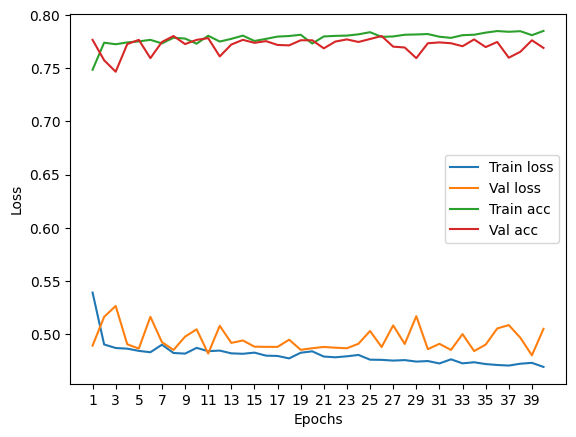

In [79]:
plot_loss(history)

Test accuracy:  77.72


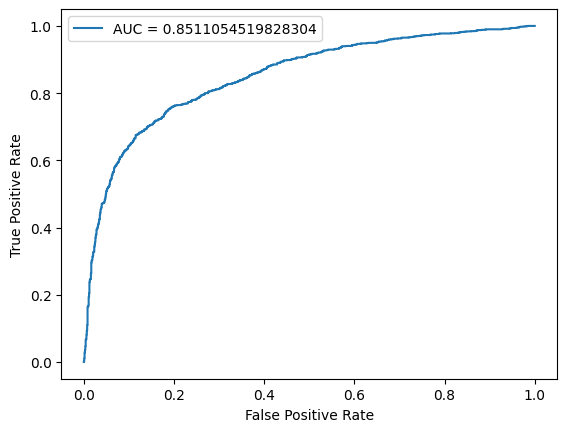

In [80]:
plot_auc(best_model, test_dataloader)

#### GAT - With 10 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [81]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [82]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 91.88it/s] 


Train Epoch: 0 	Loss: 0.685387, Accuracy: 4863/7500 (65%)
Val Epoch: 0 	Loss: 0.684917, Accuracy: 1858/2500 (74%)



118it [00:01, 98.76it/s]


Train Epoch: 1 	Loss: 0.650442, Accuracy: 5553/7500 (74%)
Val Epoch: 1 	Loss: 0.633196, Accuracy: 1880/2500 (75%)



118it [00:01, 100.46it/s]


Train Epoch: 2 	Loss: 0.582446, Accuracy: 5753/7500 (77%)
Val Epoch: 2 	Loss: 0.550401, Accuracy: 1921/2500 (77%)



118it [00:01, 78.72it/s]


Train Epoch: 3 	Loss: 0.520584, Accuracy: 5792/7500 (77%)
Val Epoch: 3 	Loss: 0.518366, Accuracy: 1914/2500 (77%)



118it [00:01, 72.38it/s]


Train Epoch: 4 	Loss: 0.499471, Accuracy: 5794/7500 (77%)
Val Epoch: 4 	Loss: 0.501083, Accuracy: 1918/2500 (77%)



118it [00:01, 87.48it/s]


Train Epoch: 5 	Loss: 0.491651, Accuracy: 5792/7500 (77%)
Val Epoch: 5 	Loss: 0.496097, Accuracy: 1906/2500 (76%)



118it [00:01, 101.99it/s]


Train Epoch: 6 	Loss: 0.491181, Accuracy: 5800/7500 (77%)
Val Epoch: 6 	Loss: 0.494763, Accuracy: 1927/2500 (77%)



118it [00:01, 88.02it/s]


Train Epoch: 7 	Loss: 0.488096, Accuracy: 5825/7500 (78%)
Val Epoch: 7 	Loss: 0.494441, Accuracy: 1936/2500 (77%)



118it [00:01, 100.90it/s]


Train Epoch: 8 	Loss: 0.489826, Accuracy: 5816/7500 (78%)
Val Epoch: 8 	Loss: 0.495366, Accuracy: 1916/2500 (77%)



118it [00:01, 99.45it/s]


Train Epoch: 9 	Loss: 0.488729, Accuracy: 5830/7500 (78%)
Val Epoch: 9 	Loss: 0.510533, Accuracy: 1938/2500 (78%)



118it [00:01, 97.60it/s]


Train Epoch: 10 	Loss: 0.486876, Accuracy: 5833/7500 (78%)
Val Epoch: 10 	Loss: 0.500250, Accuracy: 1934/2500 (77%)



118it [00:01, 74.13it/s]


Train Epoch: 11 	Loss: 0.486627, Accuracy: 5840/7500 (78%)
Val Epoch: 11 	Loss: 0.496876, Accuracy: 1944/2500 (78%)



118it [00:01, 83.68it/s] 


Train Epoch: 12 	Loss: 0.484622, Accuracy: 5826/7500 (78%)
Val Epoch: 12 	Loss: 0.487627, Accuracy: 1929/2500 (77%)



118it [00:01, 96.64it/s]


Train Epoch: 13 	Loss: 0.486515, Accuracy: 5834/7500 (78%)
Val Epoch: 13 	Loss: 0.488973, Accuracy: 1932/2500 (77%)



118it [00:01, 98.26it/s]


Train Epoch: 14 	Loss: 0.485664, Accuracy: 5831/7500 (78%)
Val Epoch: 14 	Loss: 0.506691, Accuracy: 1931/2500 (77%)



118it [00:01, 104.47it/s]


Train Epoch: 15 	Loss: 0.483732, Accuracy: 5826/7500 (78%)
Val Epoch: 15 	Loss: 0.491678, Accuracy: 1943/2500 (78%)



118it [00:01, 102.12it/s]


Train Epoch: 16 	Loss: 0.483857, Accuracy: 5834/7500 (78%)
Val Epoch: 16 	Loss: 0.499189, Accuracy: 1937/2500 (77%)



118it [00:01, 102.47it/s]


Train Epoch: 17 	Loss: 0.482602, Accuracy: 5829/7500 (78%)
Val Epoch: 17 	Loss: 0.489585, Accuracy: 1930/2500 (77%)



118it [00:01, 99.74it/s] 


Train Epoch: 18 	Loss: 0.485391, Accuracy: 5830/7500 (78%)
Val Epoch: 18 	Loss: 0.497018, Accuracy: 1935/2500 (77%)



118it [00:01, 78.45it/s]


Train Epoch: 19 	Loss: 0.481535, Accuracy: 5838/7500 (78%)
Val Epoch: 19 	Loss: 0.487799, Accuracy: 1939/2500 (78%)



118it [00:01, 75.07it/s]


Train Epoch: 20 	Loss: 0.481498, Accuracy: 5835/7500 (78%)
Val Epoch: 20 	Loss: 0.486298, Accuracy: 1939/2500 (78%)



118it [00:01, 98.00it/s]


Train Epoch: 21 	Loss: 0.482153, Accuracy: 5834/7500 (78%)
Val Epoch: 21 	Loss: 0.488933, Accuracy: 1937/2500 (77%)



118it [00:01, 94.45it/s]


Train Epoch: 22 	Loss: 0.482828, Accuracy: 5834/7500 (78%)
Val Epoch: 22 	Loss: 0.485074, Accuracy: 1938/2500 (78%)



118it [00:01, 98.97it/s] 


Train Epoch: 23 	Loss: 0.480937, Accuracy: 5829/7500 (78%)
Val Epoch: 23 	Loss: 0.485657, Accuracy: 1939/2500 (78%)



118it [00:01, 100.98it/s]


Train Epoch: 24 	Loss: 0.482137, Accuracy: 5835/7500 (78%)
Val Epoch: 24 	Loss: 0.488355, Accuracy: 1941/2500 (78%)



118it [00:01, 98.69it/s]


Train Epoch: 25 	Loss: 0.481511, Accuracy: 5825/7500 (78%)
Val Epoch: 25 	Loss: 0.484225, Accuracy: 1940/2500 (78%)



118it [00:01, 100.32it/s]


Train Epoch: 26 	Loss: 0.481631, Accuracy: 5821/7500 (78%)
Val Epoch: 26 	Loss: 0.489852, Accuracy: 1937/2500 (77%)



118it [00:01, 76.84it/s]


Train Epoch: 27 	Loss: 0.480921, Accuracy: 5845/7500 (78%)
Val Epoch: 27 	Loss: 0.486601, Accuracy: 1944/2500 (78%)



118it [00:01, 75.47it/s]


Train Epoch: 28 	Loss: 0.483194, Accuracy: 5845/7500 (78%)
Val Epoch: 28 	Loss: 0.512005, Accuracy: 1935/2500 (77%)



118it [00:01, 95.72it/s]


Train Epoch: 29 	Loss: 0.481200, Accuracy: 5844/7500 (78%)
Val Epoch: 29 	Loss: 0.485576, Accuracy: 1941/2500 (78%)



118it [00:01, 100.09it/s]


Train Epoch: 30 	Loss: 0.479771, Accuracy: 5836/7500 (78%)
Val Epoch: 30 	Loss: 0.486183, Accuracy: 1943/2500 (78%)



118it [00:01, 86.70it/s]


Train Epoch: 31 	Loss: 0.479622, Accuracy: 5825/7500 (78%)
Val Epoch: 31 	Loss: 0.485550, Accuracy: 1938/2500 (78%)



118it [00:01, 97.32it/s]


Train Epoch: 32 	Loss: 0.480872, Accuracy: 5832/7500 (78%)
Val Epoch: 32 	Loss: 0.490164, Accuracy: 1941/2500 (78%)



118it [00:01, 100.07it/s]


Train Epoch: 33 	Loss: 0.479688, Accuracy: 5834/7500 (78%)
Val Epoch: 33 	Loss: 0.485643, Accuracy: 1937/2500 (77%)



118it [00:01, 101.66it/s]


Train Epoch: 34 	Loss: 0.480774, Accuracy: 5828/7500 (78%)
Val Epoch: 34 	Loss: 0.488321, Accuracy: 1939/2500 (78%)



118it [00:01, 72.44it/s]


Train Epoch: 35 	Loss: 0.479926, Accuracy: 5827/7500 (78%)
Val Epoch: 35 	Loss: 0.492185, Accuracy: 1942/2500 (78%)



118it [00:01, 82.10it/s]


Train Epoch: 36 	Loss: 0.479415, Accuracy: 5852/7500 (78%)
Val Epoch: 36 	Loss: 0.483676, Accuracy: 1938/2500 (78%)



118it [00:01, 94.70it/s]


Train Epoch: 37 	Loss: 0.479375, Accuracy: 5835/7500 (78%)
Val Epoch: 37 	Loss: 0.491329, Accuracy: 1938/2500 (78%)



118it [00:01, 98.90it/s]


Train Epoch: 38 	Loss: 0.479673, Accuracy: 5842/7500 (78%)
Val Epoch: 38 	Loss: 0.483342, Accuracy: 1938/2500 (78%)



118it [00:01, 99.61it/s] 


Train Epoch: 39 	Loss: 0.478852, Accuracy: 5853/7500 (78%)
Val Epoch: 39 	Loss: 0.491370, Accuracy: 1934/2500 (77%)



118it [00:01, 100.11it/s]


Train Epoch: 40 	Loss: 0.478358, Accuracy: 5831/7500 (78%)
Val Epoch: 40 	Loss: 0.491011, Accuracy: 1939/2500 (78%)



118it [00:01, 100.11it/s]


Train Epoch: 41 	Loss: 0.478966, Accuracy: 5829/7500 (78%)
Val Epoch: 41 	Loss: 0.494926, Accuracy: 1945/2500 (78%)



118it [00:01, 104.30it/s]


Train Epoch: 42 	Loss: 0.480877, Accuracy: 5841/7500 (78%)
Val Epoch: 42 	Loss: 0.502451, Accuracy: 1940/2500 (78%)



118it [00:01, 73.99it/s]


Train Epoch: 43 	Loss: 0.478321, Accuracy: 5843/7500 (78%)
Val Epoch: 43 	Loss: 0.488448, Accuracy: 1937/2500 (77%)



118it [00:01, 86.81it/s] 


Train Epoch: 44 	Loss: 0.478302, Accuracy: 5818/7500 (78%)
Val Epoch: 44 	Loss: 0.486985, Accuracy: 1933/2500 (77%)



118it [00:01, 104.38it/s]


Train Epoch: 45 	Loss: 0.478419, Accuracy: 5851/7500 (78%)
Val Epoch: 45 	Loss: 0.481760, Accuracy: 1939/2500 (78%)



118it [00:01, 99.42it/s] 


Train Epoch: 46 	Loss: 0.479831, Accuracy: 5841/7500 (78%)
Val Epoch: 46 	Loss: 0.495467, Accuracy: 1944/2500 (78%)



118it [00:01, 106.22it/s]


Train Epoch: 47 	Loss: 0.477451, Accuracy: 5831/7500 (78%)
Val Epoch: 47 	Loss: 0.506168, Accuracy: 1943/2500 (78%)



118it [00:01, 100.44it/s]


Train Epoch: 48 	Loss: 0.477652, Accuracy: 5846/7500 (78%)
Val Epoch: 48 	Loss: 0.480717, Accuracy: 1941/2500 (78%)



118it [00:01, 99.19it/s]


Train Epoch: 49 	Loss: 0.478514, Accuracy: 5837/7500 (78%)
Val Epoch: 49 	Loss: 0.484489, Accuracy: 1948/2500 (78%)



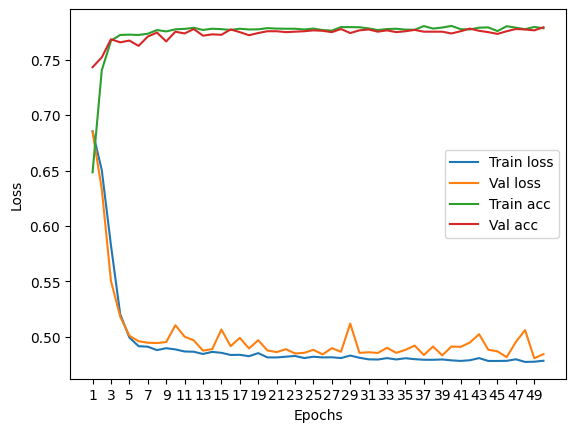

In [83]:
plot_loss(history)

Test accuracy:  77.16


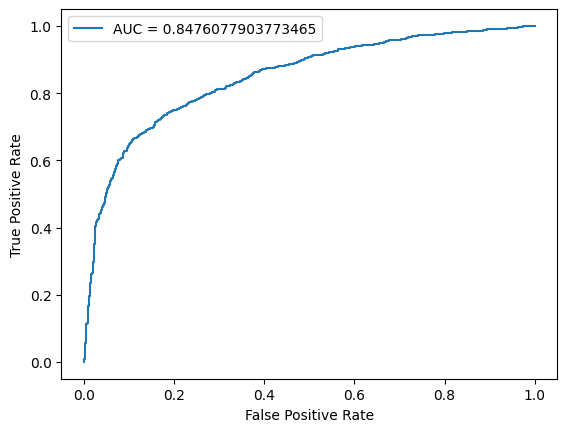

In [84]:
plot_auc(best_model, test_dataloader)

#### GAT - With 5 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, charge of jet with k = 0.2, 0.5, 0.7) count

In [85]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [86]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 97.12it/s]


Train Epoch: 0 	Loss: 0.682695, Accuracy: 4515/7500 (60%)
Val Epoch: 0 	Loss: 0.677937, Accuracy: 1889/2500 (76%)



118it [00:01, 69.64it/s]


Train Epoch: 1 	Loss: 0.636739, Accuracy: 5573/7500 (74%)
Val Epoch: 1 	Loss: 0.612089, Accuracy: 1872/2500 (75%)



118it [00:01, 97.35it/s]


Train Epoch: 2 	Loss: 0.561951, Accuracy: 5729/7500 (76%)
Val Epoch: 2 	Loss: 0.534475, Accuracy: 1903/2500 (76%)



118it [00:01, 99.59it/s]


Train Epoch: 3 	Loss: 0.514315, Accuracy: 5778/7500 (77%)
Val Epoch: 3 	Loss: 0.517273, Accuracy: 1912/2500 (76%)



118it [00:01, 90.90it/s]


Train Epoch: 4 	Loss: 0.497809, Accuracy: 5795/7500 (77%)
Val Epoch: 4 	Loss: 0.503164, Accuracy: 1920/2500 (77%)



118it [00:01, 99.83it/s]


Train Epoch: 5 	Loss: 0.493302, Accuracy: 5819/7500 (78%)
Val Epoch: 5 	Loss: 0.496413, Accuracy: 1929/2500 (77%)



118it [00:01, 92.27it/s]


Train Epoch: 6 	Loss: 0.492128, Accuracy: 5818/7500 (78%)
Val Epoch: 6 	Loss: 0.495279, Accuracy: 1929/2500 (77%)



118it [00:01, 104.25it/s]


Train Epoch: 7 	Loss: 0.489178, Accuracy: 5829/7500 (78%)
Val Epoch: 7 	Loss: 0.500700, Accuracy: 1932/2500 (77%)



118it [00:01, 82.07it/s]


Train Epoch: 8 	Loss: 0.489478, Accuracy: 5826/7500 (78%)
Val Epoch: 8 	Loss: 0.499473, Accuracy: 1935/2500 (77%)



118it [00:01, 74.45it/s]


Train Epoch: 9 	Loss: 0.485633, Accuracy: 5827/7500 (78%)
Val Epoch: 9 	Loss: 0.497397, Accuracy: 1935/2500 (77%)



118it [00:01, 100.36it/s]


Train Epoch: 10 	Loss: 0.484871, Accuracy: 5842/7500 (78%)
Val Epoch: 10 	Loss: 0.496674, Accuracy: 1942/2500 (78%)



118it [00:01, 99.81it/s]


Train Epoch: 11 	Loss: 0.485142, Accuracy: 5854/7500 (78%)
Val Epoch: 11 	Loss: 0.490136, Accuracy: 1936/2500 (77%)



118it [00:01, 101.50it/s]


Train Epoch: 12 	Loss: 0.484417, Accuracy: 5840/7500 (78%)
Val Epoch: 12 	Loss: 0.517617, Accuracy: 1943/2500 (78%)



118it [00:01, 103.65it/s]


Train Epoch: 13 	Loss: 0.482848, Accuracy: 5837/7500 (78%)
Val Epoch: 13 	Loss: 0.488381, Accuracy: 1947/2500 (78%)



118it [00:01, 99.38it/s] 


Train Epoch: 14 	Loss: 0.483712, Accuracy: 5854/7500 (78%)
Val Epoch: 14 	Loss: 0.493289, Accuracy: 1939/2500 (78%)



118it [00:01, 101.77it/s]


Train Epoch: 15 	Loss: 0.481361, Accuracy: 5849/7500 (78%)
Val Epoch: 15 	Loss: 0.526308, Accuracy: 1935/2500 (77%)



118it [00:01, 78.27it/s]


Train Epoch: 16 	Loss: 0.482406, Accuracy: 5856/7500 (78%)
Val Epoch: 16 	Loss: 0.491194, Accuracy: 1943/2500 (78%)



118it [00:01, 71.81it/s]


Train Epoch: 17 	Loss: 0.482098, Accuracy: 5861/7500 (78%)
Val Epoch: 17 	Loss: 0.483653, Accuracy: 1936/2500 (77%)



118it [00:01, 101.15it/s]


Train Epoch: 18 	Loss: 0.481332, Accuracy: 5846/7500 (78%)
Val Epoch: 18 	Loss: 0.487006, Accuracy: 1941/2500 (78%)



118it [00:01, 103.47it/s]


Train Epoch: 19 	Loss: 0.482035, Accuracy: 5848/7500 (78%)
Val Epoch: 19 	Loss: 0.490940, Accuracy: 1930/2500 (77%)



118it [00:01, 103.69it/s]


Train Epoch: 20 	Loss: 0.479568, Accuracy: 5840/7500 (78%)
Val Epoch: 20 	Loss: 0.504029, Accuracy: 1940/2500 (78%)



118it [00:01, 101.40it/s]


Train Epoch: 21 	Loss: 0.484486, Accuracy: 5833/7500 (78%)
Val Epoch: 21 	Loss: 0.496419, Accuracy: 1936/2500 (77%)



118it [00:01, 99.43it/s]


Train Epoch: 22 	Loss: 0.480764, Accuracy: 5842/7500 (78%)
Val Epoch: 22 	Loss: 0.501777, Accuracy: 1940/2500 (78%)



118it [00:01, 102.41it/s]


Train Epoch: 23 	Loss: 0.481197, Accuracy: 5841/7500 (78%)
Val Epoch: 23 	Loss: 0.487615, Accuracy: 1937/2500 (77%)



118it [00:01, 92.57it/s]


Train Epoch: 24 	Loss: 0.481440, Accuracy: 5833/7500 (78%)
Val Epoch: 24 	Loss: 0.495570, Accuracy: 1944/2500 (78%)



118it [00:01, 67.27it/s]


Train Epoch: 25 	Loss: 0.479381, Accuracy: 5848/7500 (78%)
Val Epoch: 25 	Loss: 0.496830, Accuracy: 1942/2500 (78%)



118it [00:01, 102.54it/s]


Train Epoch: 26 	Loss: 0.478805, Accuracy: 5838/7500 (78%)
Val Epoch: 26 	Loss: 0.485371, Accuracy: 1940/2500 (78%)



118it [00:01, 100.20it/s]


Train Epoch: 27 	Loss: 0.479658, Accuracy: 5852/7500 (78%)
Val Epoch: 27 	Loss: 0.483757, Accuracy: 1940/2500 (78%)



118it [00:01, 105.67it/s]


Train Epoch: 28 	Loss: 0.479990, Accuracy: 5837/7500 (78%)
Val Epoch: 28 	Loss: 0.495594, Accuracy: 1939/2500 (78%)



118it [00:01, 98.02it/s]


Train Epoch: 29 	Loss: 0.478458, Accuracy: 5861/7500 (78%)
Val Epoch: 29 	Loss: 0.489496, Accuracy: 1942/2500 (78%)



118it [00:01, 94.78it/s]


Train Epoch: 30 	Loss: 0.478705, Accuracy: 5847/7500 (78%)
Val Epoch: 30 	Loss: 0.494592, Accuracy: 1944/2500 (78%)



118it [00:01, 108.51it/s]


Train Epoch: 31 	Loss: 0.478170, Accuracy: 5854/7500 (78%)
Val Epoch: 31 	Loss: 0.509561, Accuracy: 1936/2500 (77%)



118it [00:01, 102.84it/s]


Train Epoch: 32 	Loss: 0.478435, Accuracy: 5830/7500 (78%)
Val Epoch: 32 	Loss: 0.491844, Accuracy: 1942/2500 (78%)



118it [00:01, 72.80it/s]


Train Epoch: 33 	Loss: 0.478515, Accuracy: 5839/7500 (78%)
Val Epoch: 33 	Loss: 0.488285, Accuracy: 1939/2500 (78%)



118it [00:01, 108.35it/s]


Train Epoch: 34 	Loss: 0.478495, Accuracy: 5841/7500 (78%)
Val Epoch: 34 	Loss: 0.492916, Accuracy: 1942/2500 (78%)



118it [00:01, 92.55it/s] 


Train Epoch: 35 	Loss: 0.480294, Accuracy: 5858/7500 (78%)
Val Epoch: 35 	Loss: 0.501708, Accuracy: 1936/2500 (77%)



118it [00:01, 101.55it/s]


Train Epoch: 36 	Loss: 0.480726, Accuracy: 5853/7500 (78%)
Val Epoch: 36 	Loss: 0.483989, Accuracy: 1942/2500 (78%)



118it [00:01, 101.88it/s]


Train Epoch: 37 	Loss: 0.476888, Accuracy: 5855/7500 (78%)
Val Epoch: 37 	Loss: 0.516813, Accuracy: 1943/2500 (78%)



118it [00:01, 110.56it/s]


Train Epoch: 38 	Loss: 0.480347, Accuracy: 5847/7500 (78%)
Val Epoch: 38 	Loss: 0.494074, Accuracy: 1945/2500 (78%)



118it [00:01, 106.78it/s]


Train Epoch: 39 	Loss: 0.477841, Accuracy: 5860/7500 (78%)
Val Epoch: 39 	Loss: 0.489970, Accuracy: 1933/2500 (77%)



118it [00:01, 102.32it/s]


Train Epoch: 40 	Loss: 0.479801, Accuracy: 5868/7500 (78%)
Val Epoch: 40 	Loss: 0.495765, Accuracy: 1944/2500 (78%)



118it [00:01, 72.10it/s]


Train Epoch: 41 	Loss: 0.476817, Accuracy: 5857/7500 (78%)
Val Epoch: 41 	Loss: 0.483875, Accuracy: 1944/2500 (78%)



118it [00:01, 88.91it/s] 


Train Epoch: 42 	Loss: 0.476521, Accuracy: 5848/7500 (78%)
Val Epoch: 42 	Loss: 0.494213, Accuracy: 1941/2500 (78%)



118it [00:01, 101.17it/s]


Train Epoch: 43 	Loss: 0.479006, Accuracy: 5849/7500 (78%)
Val Epoch: 43 	Loss: 0.495465, Accuracy: 1942/2500 (78%)



118it [00:01, 101.27it/s]


Train Epoch: 44 	Loss: 0.478976, Accuracy: 5856/7500 (78%)
Val Epoch: 44 	Loss: 0.488280, Accuracy: 1943/2500 (78%)



118it [00:01, 102.55it/s]


Train Epoch: 45 	Loss: 0.477150, Accuracy: 5863/7500 (78%)
Val Epoch: 45 	Loss: 0.488782, Accuracy: 1941/2500 (78%)



118it [00:01, 88.37it/s]


Train Epoch: 46 	Loss: 0.477299, Accuracy: 5865/7500 (78%)
Val Epoch: 46 	Loss: 0.484089, Accuracy: 1946/2500 (78%)



118it [00:01, 107.26it/s]


Train Epoch: 47 	Loss: 0.480484, Accuracy: 5873/7500 (78%)
Val Epoch: 47 	Loss: 0.480654, Accuracy: 1950/2500 (78%)



118it [00:01, 105.18it/s]


Train Epoch: 48 	Loss: 0.477779, Accuracy: 5850/7500 (78%)
Val Epoch: 48 	Loss: 0.501649, Accuracy: 1947/2500 (78%)



118it [00:01, 78.61it/s]


Train Epoch: 49 	Loss: 0.478164, Accuracy: 5867/7500 (78%)
Val Epoch: 49 	Loss: 0.493957, Accuracy: 1945/2500 (78%)



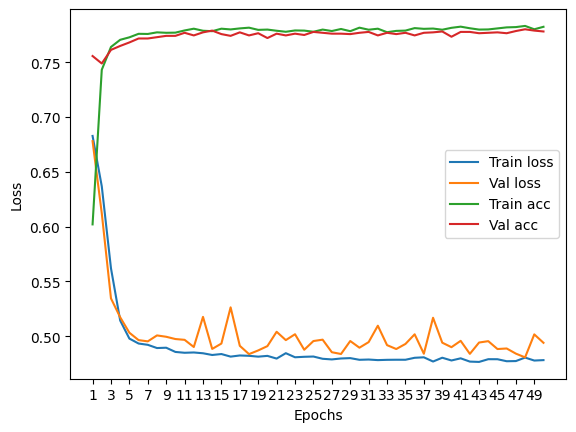

In [87]:
plot_loss(history)

Test accuracy:  77.72


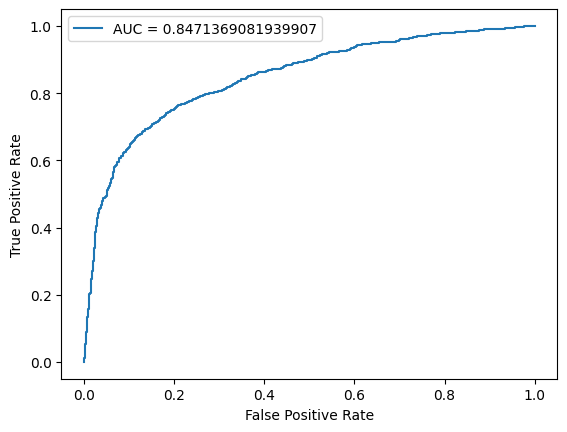

In [88]:
plot_auc(best_model, test_dataloader)

#### GAT - With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [89]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [90]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 103.49it/s]


Train Epoch: 0 	Loss: 0.695235, Accuracy: 3836/7500 (51%)
Val Epoch: 0 	Loss: 0.685250, Accuracy: 1587/2500 (63%)



118it [00:01, 81.55it/s]


Train Epoch: 1 	Loss: 0.660289, Accuracy: 5425/7500 (72%)
Val Epoch: 1 	Loss: 0.652561, Accuracy: 1918/2500 (77%)



118it [00:01, 101.58it/s]


Train Epoch: 2 	Loss: 0.617936, Accuracy: 5679/7500 (76%)
Val Epoch: 2 	Loss: 0.599461, Accuracy: 1897/2500 (76%)



118it [00:01, 104.92it/s]


Train Epoch: 3 	Loss: 0.562155, Accuracy: 5743/7500 (77%)
Val Epoch: 3 	Loss: 0.542601, Accuracy: 1918/2500 (77%)



118it [00:01, 102.83it/s]


Train Epoch: 4 	Loss: 0.521643, Accuracy: 5777/7500 (77%)
Val Epoch: 4 	Loss: 0.528584, Accuracy: 1919/2500 (77%)



118it [00:01, 99.34it/s] 


Train Epoch: 5 	Loss: 0.504740, Accuracy: 5777/7500 (77%)
Val Epoch: 5 	Loss: 0.514621, Accuracy: 1919/2500 (77%)



118it [00:01, 86.26it/s]


Train Epoch: 6 	Loss: 0.499283, Accuracy: 5801/7500 (77%)
Val Epoch: 6 	Loss: 0.515653, Accuracy: 1916/2500 (77%)



118it [00:01, 70.05it/s]


Train Epoch: 7 	Loss: 0.496100, Accuracy: 5801/7500 (77%)
Val Epoch: 7 	Loss: 0.516481, Accuracy: 1925/2500 (77%)



118it [00:01, 103.34it/s]


Train Epoch: 8 	Loss: 0.493141, Accuracy: 5801/7500 (77%)
Val Epoch: 8 	Loss: 0.503077, Accuracy: 1929/2500 (77%)



118it [00:01, 103.37it/s]


Train Epoch: 9 	Loss: 0.492219, Accuracy: 5810/7500 (77%)
Val Epoch: 9 	Loss: 0.500580, Accuracy: 1910/2500 (76%)



118it [00:01, 108.45it/s]


Train Epoch: 10 	Loss: 0.491631, Accuracy: 5803/7500 (77%)
Val Epoch: 10 	Loss: 0.502358, Accuracy: 1925/2500 (77%)



118it [00:01, 103.28it/s]


Train Epoch: 11 	Loss: 0.489585, Accuracy: 5813/7500 (78%)
Val Epoch: 11 	Loss: 0.513639, Accuracy: 1934/2500 (77%)



118it [00:01, 99.85it/s] 


Train Epoch: 12 	Loss: 0.489404, Accuracy: 5823/7500 (78%)
Val Epoch: 12 	Loss: 0.503633, Accuracy: 1925/2500 (77%)



118it [00:01, 99.56it/s] 


Train Epoch: 13 	Loss: 0.489012, Accuracy: 5817/7500 (78%)
Val Epoch: 13 	Loss: 0.495383, Accuracy: 1935/2500 (77%)



118it [00:01, 95.08it/s]


Train Epoch: 14 	Loss: 0.487287, Accuracy: 5829/7500 (78%)
Val Epoch: 14 	Loss: 0.498049, Accuracy: 1936/2500 (77%)



118it [00:01, 67.75it/s]


Train Epoch: 15 	Loss: 0.485971, Accuracy: 5821/7500 (78%)
Val Epoch: 15 	Loss: 0.493494, Accuracy: 1935/2500 (77%)



118it [00:01, 104.91it/s]


Train Epoch: 16 	Loss: 0.485476, Accuracy: 5841/7500 (78%)
Val Epoch: 16 	Loss: 0.499526, Accuracy: 1929/2500 (77%)



118it [00:01, 105.21it/s]


Train Epoch: 17 	Loss: 0.485622, Accuracy: 5829/7500 (78%)
Val Epoch: 17 	Loss: 0.498029, Accuracy: 1937/2500 (77%)



118it [00:01, 110.30it/s]


Train Epoch: 18 	Loss: 0.485488, Accuracy: 5834/7500 (78%)
Val Epoch: 18 	Loss: 0.501371, Accuracy: 1933/2500 (77%)



118it [00:01, 105.51it/s]


Train Epoch: 19 	Loss: 0.485975, Accuracy: 5830/7500 (78%)
Val Epoch: 19 	Loss: 0.497569, Accuracy: 1939/2500 (78%)



118it [00:01, 101.69it/s]


Train Epoch: 20 	Loss: 0.484987, Accuracy: 5831/7500 (78%)
Val Epoch: 20 	Loss: 0.498015, Accuracy: 1938/2500 (78%)



118it [00:01, 103.29it/s]


Train Epoch: 21 	Loss: 0.483694, Accuracy: 5843/7500 (78%)
Val Epoch: 21 	Loss: 0.502861, Accuracy: 1933/2500 (77%)



118it [00:01, 104.39it/s]


Train Epoch: 22 	Loss: 0.484447, Accuracy: 5830/7500 (78%)
Val Epoch: 22 	Loss: 0.507571, Accuracy: 1943/2500 (78%)



118it [00:01, 75.14it/s]


Train Epoch: 23 	Loss: 0.484749, Accuracy: 5832/7500 (78%)
Val Epoch: 23 	Loss: 0.497719, Accuracy: 1942/2500 (78%)



118it [00:01, 87.99it/s]


Train Epoch: 24 	Loss: 0.481370, Accuracy: 5839/7500 (78%)
Val Epoch: 24 	Loss: 0.490716, Accuracy: 1938/2500 (78%)



118it [00:01, 108.54it/s]


Train Epoch: 25 	Loss: 0.481561, Accuracy: 5843/7500 (78%)
Val Epoch: 25 	Loss: 0.498782, Accuracy: 1928/2500 (77%)



118it [00:01, 105.28it/s]


Train Epoch: 26 	Loss: 0.481586, Accuracy: 5839/7500 (78%)
Val Epoch: 26 	Loss: 0.494949, Accuracy: 1934/2500 (77%)



118it [00:01, 102.19it/s]


Train Epoch: 27 	Loss: 0.482474, Accuracy: 5835/7500 (78%)
Val Epoch: 27 	Loss: 0.491073, Accuracy: 1940/2500 (78%)



118it [00:01, 93.91it/s]


Train Epoch: 28 	Loss: 0.481575, Accuracy: 5844/7500 (78%)
Val Epoch: 28 	Loss: 0.495472, Accuracy: 1942/2500 (78%)



118it [00:01, 104.10it/s]


Train Epoch: 29 	Loss: 0.480985, Accuracy: 5849/7500 (78%)
Val Epoch: 29 	Loss: 0.484708, Accuracy: 1941/2500 (78%)



118it [00:01, 101.20it/s]


Train Epoch: 30 	Loss: 0.480631, Accuracy: 5853/7500 (78%)
Val Epoch: 30 	Loss: 0.494722, Accuracy: 1935/2500 (77%)



118it [00:01, 61.44it/s]


Train Epoch: 31 	Loss: 0.480106, Accuracy: 5845/7500 (78%)
Val Epoch: 31 	Loss: 0.485357, Accuracy: 1939/2500 (78%)



118it [00:01, 63.35it/s]


Train Epoch: 32 	Loss: 0.481404, Accuracy: 5853/7500 (78%)
Val Epoch: 32 	Loss: 0.498740, Accuracy: 1941/2500 (78%)



118it [00:01, 100.05it/s]


Train Epoch: 33 	Loss: 0.482143, Accuracy: 5848/7500 (78%)
Val Epoch: 33 	Loss: 0.487684, Accuracy: 1934/2500 (77%)



118it [00:01, 103.65it/s]


Train Epoch: 34 	Loss: 0.482554, Accuracy: 5840/7500 (78%)
Val Epoch: 34 	Loss: 0.490223, Accuracy: 1942/2500 (78%)



118it [00:01, 104.64it/s]


Train Epoch: 35 	Loss: 0.481033, Accuracy: 5853/7500 (78%)
Val Epoch: 35 	Loss: 0.486443, Accuracy: 1935/2500 (77%)



118it [00:01, 101.64it/s]


Train Epoch: 36 	Loss: 0.480544, Accuracy: 5851/7500 (78%)
Val Epoch: 36 	Loss: 0.487073, Accuracy: 1939/2500 (78%)



118it [00:01, 99.45it/s] 


Train Epoch: 37 	Loss: 0.481136, Accuracy: 5856/7500 (78%)
Val Epoch: 37 	Loss: 0.493302, Accuracy: 1936/2500 (77%)



118it [00:01, 100.60it/s]


Train Epoch: 38 	Loss: 0.480820, Accuracy: 5853/7500 (78%)
Val Epoch: 38 	Loss: 0.493161, Accuracy: 1938/2500 (78%)



118it [00:01, 89.64it/s]


Train Epoch: 39 	Loss: 0.480962, Accuracy: 5843/7500 (78%)
Val Epoch: 39 	Loss: 0.495648, Accuracy: 1939/2500 (78%)



118it [00:01, 66.68it/s]


Train Epoch: 40 	Loss: 0.479914, Accuracy: 5843/7500 (78%)
Val Epoch: 40 	Loss: 0.490569, Accuracy: 1939/2500 (78%)



118it [00:01, 99.65it/s] 


Train Epoch: 41 	Loss: 0.480850, Accuracy: 5855/7500 (78%)
Val Epoch: 41 	Loss: 0.498938, Accuracy: 1940/2500 (78%)



118it [00:01, 94.29it/s] 


Train Epoch: 42 	Loss: 0.480616, Accuracy: 5844/7500 (78%)
Val Epoch: 42 	Loss: 0.486369, Accuracy: 1937/2500 (77%)



118it [00:01, 100.72it/s]


Train Epoch: 43 	Loss: 0.479359, Accuracy: 5853/7500 (78%)
Val Epoch: 43 	Loss: 0.493555, Accuracy: 1942/2500 (78%)



118it [00:01, 100.75it/s]


Train Epoch: 44 	Loss: 0.478866, Accuracy: 5852/7500 (78%)
Val Epoch: 44 	Loss: 0.482938, Accuracy: 1939/2500 (78%)



118it [00:01, 103.31it/s]


Train Epoch: 45 	Loss: 0.481877, Accuracy: 5858/7500 (78%)
Val Epoch: 45 	Loss: 0.499881, Accuracy: 1937/2500 (77%)



118it [00:01, 101.77it/s]


Train Epoch: 46 	Loss: 0.479174, Accuracy: 5851/7500 (78%)
Val Epoch: 46 	Loss: 0.510622, Accuracy: 1933/2500 (77%)



118it [00:01, 101.45it/s]


Train Epoch: 47 	Loss: 0.478387, Accuracy: 5844/7500 (78%)
Val Epoch: 47 	Loss: 0.494697, Accuracy: 1938/2500 (78%)



118it [00:01, 65.45it/s]


Train Epoch: 48 	Loss: 0.480520, Accuracy: 5850/7500 (78%)
Val Epoch: 48 	Loss: 0.498515, Accuracy: 1939/2500 (78%)



118it [00:01, 101.27it/s]


Train Epoch: 49 	Loss: 0.478214, Accuracy: 5848/7500 (78%)
Val Epoch: 49 	Loss: 0.496386, Accuracy: 1937/2500 (77%)



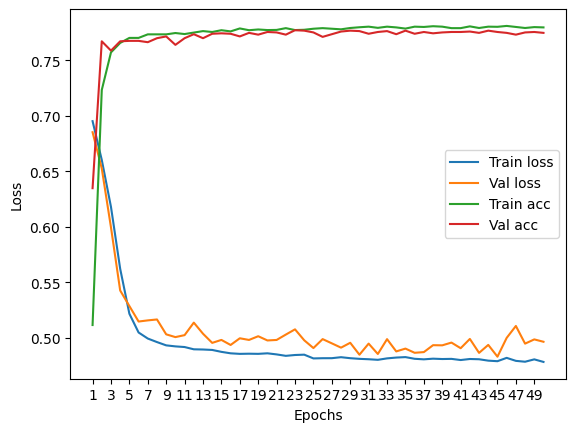

In [91]:
plot_loss(history)

Test accuracy:  77.4


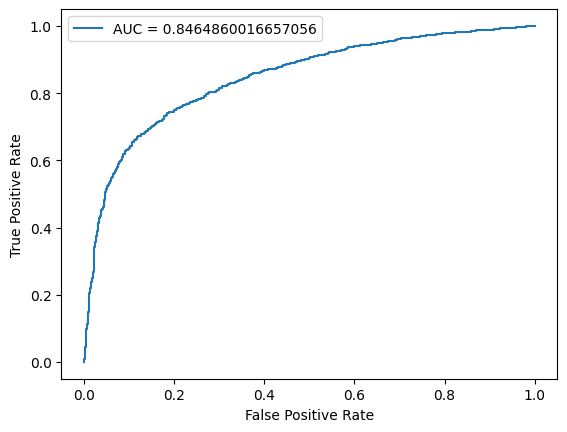

In [92]:
plot_auc(best_model, test_dataloader)

#### GAT - With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [93]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [94]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 90.82it/s]


Train Epoch: 0 	Loss: 0.693794, Accuracy: 3931/7500 (52%)
Val Epoch: 0 	Loss: 0.688594, Accuracy: 1529/2500 (61%)



118it [00:01, 87.52it/s]


Train Epoch: 1 	Loss: 0.639793, Accuracy: 5286/7500 (70%)
Val Epoch: 1 	Loss: 0.604782, Accuracy: 1871/2500 (75%)



118it [00:01, 87.50it/s]


Train Epoch: 2 	Loss: 0.553125, Accuracy: 5739/7500 (77%)
Val Epoch: 2 	Loss: 0.525654, Accuracy: 1899/2500 (76%)



118it [00:01, 89.67it/s]


Train Epoch: 3 	Loss: 0.508503, Accuracy: 5780/7500 (77%)
Val Epoch: 3 	Loss: 0.528039, Accuracy: 1916/2500 (77%)



118it [00:01, 78.47it/s]


Train Epoch: 4 	Loss: 0.498917, Accuracy: 5809/7500 (77%)
Val Epoch: 4 	Loss: 0.503604, Accuracy: 1926/2500 (77%)



118it [00:01, 60.10it/s]


Train Epoch: 5 	Loss: 0.493610, Accuracy: 5802/7500 (77%)
Val Epoch: 5 	Loss: 0.501740, Accuracy: 1916/2500 (77%)



118it [00:01, 109.90it/s]


Train Epoch: 6 	Loss: 0.491602, Accuracy: 5821/7500 (78%)
Val Epoch: 6 	Loss: 0.509426, Accuracy: 1910/2500 (76%)



118it [00:01, 99.58it/s]


Train Epoch: 7 	Loss: 0.489867, Accuracy: 5817/7500 (78%)
Val Epoch: 7 	Loss: 0.498681, Accuracy: 1920/2500 (77%)



118it [00:01, 102.32it/s]


Train Epoch: 8 	Loss: 0.489312, Accuracy: 5819/7500 (78%)
Val Epoch: 8 	Loss: 0.503171, Accuracy: 1924/2500 (77%)



118it [00:01, 100.06it/s]


Train Epoch: 9 	Loss: 0.488934, Accuracy: 5805/7500 (77%)
Val Epoch: 9 	Loss: 0.512275, Accuracy: 1927/2500 (77%)



118it [00:01, 105.31it/s]


Train Epoch: 10 	Loss: 0.488762, Accuracy: 5832/7500 (78%)
Val Epoch: 10 	Loss: 0.502771, Accuracy: 1921/2500 (77%)



118it [00:01, 107.93it/s]


Train Epoch: 11 	Loss: 0.487846, Accuracy: 5804/7500 (77%)
Val Epoch: 11 	Loss: 0.501685, Accuracy: 1924/2500 (77%)



118it [00:01, 102.42it/s]


Train Epoch: 12 	Loss: 0.489454, Accuracy: 5818/7500 (78%)
Val Epoch: 12 	Loss: 0.496764, Accuracy: 1930/2500 (77%)



118it [00:01, 68.37it/s]


Train Epoch: 13 	Loss: 0.486644, Accuracy: 5837/7500 (78%)
Val Epoch: 13 	Loss: 0.505664, Accuracy: 1932/2500 (77%)



118it [00:01, 105.48it/s]


Train Epoch: 14 	Loss: 0.485322, Accuracy: 5855/7500 (78%)
Val Epoch: 14 	Loss: 0.503359, Accuracy: 1934/2500 (77%)



118it [00:01, 97.87it/s]


Train Epoch: 15 	Loss: 0.485929, Accuracy: 5849/7500 (78%)
Val Epoch: 15 	Loss: 0.499349, Accuracy: 1925/2500 (77%)



118it [00:01, 96.86it/s]


Train Epoch: 16 	Loss: 0.487447, Accuracy: 5821/7500 (78%)
Val Epoch: 16 	Loss: 0.495515, Accuracy: 1938/2500 (78%)



118it [00:01, 99.28it/s] 


Train Epoch: 17 	Loss: 0.485343, Accuracy: 5828/7500 (78%)
Val Epoch: 17 	Loss: 0.490344, Accuracy: 1928/2500 (77%)



118it [00:01, 106.55it/s]


Train Epoch: 18 	Loss: 0.484804, Accuracy: 5837/7500 (78%)
Val Epoch: 18 	Loss: 0.499105, Accuracy: 1938/2500 (78%)



118it [00:01, 104.27it/s]


Train Epoch: 19 	Loss: 0.483740, Accuracy: 5845/7500 (78%)
Val Epoch: 19 	Loss: 0.499407, Accuracy: 1935/2500 (77%)



118it [00:01, 101.50it/s]


Train Epoch: 20 	Loss: 0.482524, Accuracy: 5833/7500 (78%)
Val Epoch: 20 	Loss: 0.521619, Accuracy: 1934/2500 (77%)



118it [00:01, 69.77it/s]


Train Epoch: 21 	Loss: 0.485219, Accuracy: 5835/7500 (78%)
Val Epoch: 21 	Loss: 0.501672, Accuracy: 1932/2500 (77%)



118it [00:01, 93.19it/s]


Train Epoch: 22 	Loss: 0.483814, Accuracy: 5838/7500 (78%)
Val Epoch: 22 	Loss: 0.490532, Accuracy: 1937/2500 (77%)



118it [00:01, 102.26it/s]


Train Epoch: 23 	Loss: 0.481481, Accuracy: 5843/7500 (78%)
Val Epoch: 23 	Loss: 0.495408, Accuracy: 1942/2500 (78%)



118it [00:01, 100.59it/s]


Train Epoch: 24 	Loss: 0.483781, Accuracy: 5853/7500 (78%)
Val Epoch: 24 	Loss: 0.489226, Accuracy: 1931/2500 (77%)



118it [00:01, 107.47it/s]


Train Epoch: 25 	Loss: 0.484039, Accuracy: 5838/7500 (78%)
Val Epoch: 25 	Loss: 0.498846, Accuracy: 1928/2500 (77%)



118it [00:01, 105.73it/s]


Train Epoch: 26 	Loss: 0.483887, Accuracy: 5833/7500 (78%)
Val Epoch: 26 	Loss: 0.490524, Accuracy: 1940/2500 (78%)



118it [00:01, 99.64it/s]


Train Epoch: 27 	Loss: 0.481440, Accuracy: 5838/7500 (78%)
Val Epoch: 27 	Loss: 0.493580, Accuracy: 1940/2500 (78%)



118it [00:01, 99.15it/s]


Train Epoch: 28 	Loss: 0.482663, Accuracy: 5826/7500 (78%)
Val Epoch: 28 	Loss: 0.493230, Accuracy: 1946/2500 (78%)



118it [00:01, 75.31it/s]


Train Epoch: 29 	Loss: 0.483017, Accuracy: 5845/7500 (78%)
Val Epoch: 29 	Loss: 0.482959, Accuracy: 1943/2500 (78%)



118it [00:01, 81.21it/s]


Train Epoch: 30 	Loss: 0.480467, Accuracy: 5851/7500 (78%)
Val Epoch: 30 	Loss: 0.498510, Accuracy: 1933/2500 (77%)



118it [00:01, 96.19it/s]


Train Epoch: 31 	Loss: 0.483366, Accuracy: 5845/7500 (78%)
Val Epoch: 31 	Loss: 0.488873, Accuracy: 1933/2500 (77%)



118it [00:01, 99.22it/s]


Train Epoch: 32 	Loss: 0.482537, Accuracy: 5852/7500 (78%)
Val Epoch: 32 	Loss: 0.488323, Accuracy: 1944/2500 (78%)



118it [00:01, 101.53it/s]


Train Epoch: 33 	Loss: 0.479857, Accuracy: 5842/7500 (78%)
Val Epoch: 33 	Loss: 0.504070, Accuracy: 1942/2500 (78%)



118it [00:01, 107.81it/s]


Train Epoch: 34 	Loss: 0.479752, Accuracy: 5842/7500 (78%)
Val Epoch: 34 	Loss: 0.485370, Accuracy: 1933/2500 (77%)



118it [00:01, 99.39it/s]


Train Epoch: 35 	Loss: 0.481393, Accuracy: 5845/7500 (78%)
Val Epoch: 35 	Loss: 0.489395, Accuracy: 1936/2500 (77%)



118it [00:01, 105.87it/s]


Train Epoch: 36 	Loss: 0.481206, Accuracy: 5851/7500 (78%)
Val Epoch: 36 	Loss: 0.495083, Accuracy: 1942/2500 (78%)



118it [00:01, 77.05it/s]


Train Epoch: 37 	Loss: 0.483109, Accuracy: 5838/7500 (78%)
Val Epoch: 37 	Loss: 0.490688, Accuracy: 1943/2500 (78%)



118it [00:01, 78.57it/s]


Train Epoch: 38 	Loss: 0.479300, Accuracy: 5851/7500 (78%)
Val Epoch: 38 	Loss: 0.484292, Accuracy: 1946/2500 (78%)



118it [00:01, 97.42it/s]


Train Epoch: 39 	Loss: 0.480392, Accuracy: 5845/7500 (78%)
Val Epoch: 39 	Loss: 0.496916, Accuracy: 1933/2500 (77%)



118it [00:01, 99.13it/s] 


Train Epoch: 40 	Loss: 0.481715, Accuracy: 5852/7500 (78%)
Val Epoch: 40 	Loss: 0.485975, Accuracy: 1937/2500 (77%)



118it [00:01, 103.36it/s]


Train Epoch: 41 	Loss: 0.480260, Accuracy: 5849/7500 (78%)
Val Epoch: 41 	Loss: 0.485534, Accuracy: 1947/2500 (78%)



118it [00:01, 95.85it/s]


Train Epoch: 42 	Loss: 0.480852, Accuracy: 5847/7500 (78%)
Val Epoch: 42 	Loss: 0.497855, Accuracy: 1940/2500 (78%)



118it [00:01, 97.88it/s]


Train Epoch: 43 	Loss: 0.477790, Accuracy: 5845/7500 (78%)
Val Epoch: 43 	Loss: 0.485653, Accuracy: 1940/2500 (78%)



118it [00:01, 102.74it/s]


Train Epoch: 44 	Loss: 0.479789, Accuracy: 5861/7500 (78%)
Val Epoch: 44 	Loss: 0.502746, Accuracy: 1941/2500 (78%)



118it [00:02, 39.81it/s]


Train Epoch: 45 	Loss: 0.479654, Accuracy: 5866/7500 (78%)
Val Epoch: 45 	Loss: 0.485948, Accuracy: 1942/2500 (78%)



118it [00:02, 53.93it/s]


Train Epoch: 46 	Loss: 0.478692, Accuracy: 5848/7500 (78%)
Val Epoch: 46 	Loss: 0.492671, Accuracy: 1934/2500 (77%)



118it [00:01, 92.39it/s] 


Train Epoch: 47 	Loss: 0.480733, Accuracy: 5845/7500 (78%)
Val Epoch: 47 	Loss: 0.488062, Accuracy: 1942/2500 (78%)



118it [00:01, 99.20it/s] 


Train Epoch: 48 	Loss: 0.479774, Accuracy: 5851/7500 (78%)
Val Epoch: 48 	Loss: 0.483126, Accuracy: 1943/2500 (78%)



118it [00:01, 103.46it/s]


Train Epoch: 49 	Loss: 0.481106, Accuracy: 5854/7500 (78%)
Val Epoch: 49 	Loss: 0.509138, Accuracy: 1935/2500 (77%)



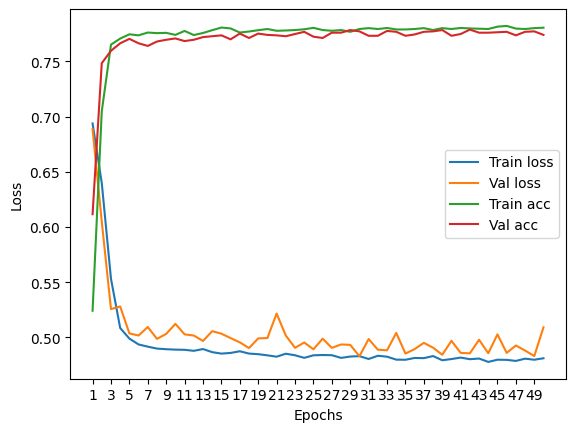

In [95]:
plot_loss(history)

Test accuracy:  77.2


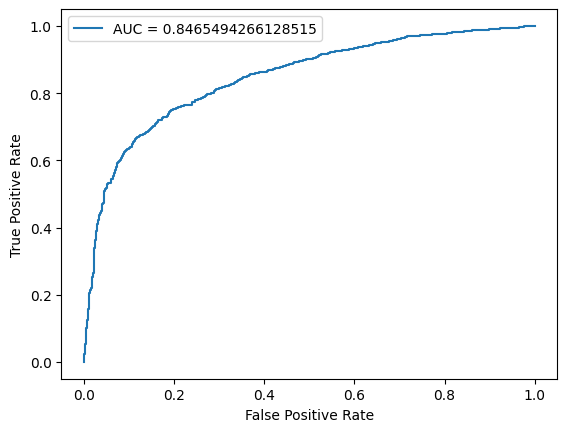

In [96]:
plot_auc(best_model, test_dataloader)

#### With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [97]:
input_dims = 8
hidden_dims = [8,8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [98]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 118.60it/s]


Train Epoch: 0 	Loss: 0.679097, Accuracy: 4870/7500 (65%)
Val Epoch: 0 	Loss: 0.663196, Accuracy: 1850/2500 (74%)



118it [00:00, 135.56it/s]


Train Epoch: 1 	Loss: 0.596697, Accuracy: 5725/7500 (76%)
Val Epoch: 1 	Loss: 0.555917, Accuracy: 1910/2500 (76%)



118it [00:00, 120.07it/s]


Train Epoch: 2 	Loss: 0.512808, Accuracy: 5787/7500 (77%)
Val Epoch: 2 	Loss: 0.538740, Accuracy: 1913/2500 (77%)



118it [00:01, 87.66it/s]


Train Epoch: 3 	Loss: 0.493954, Accuracy: 5792/7500 (77%)
Val Epoch: 3 	Loss: 0.511825, Accuracy: 1932/2500 (77%)



118it [00:01, 111.67it/s]


Train Epoch: 4 	Loss: 0.488916, Accuracy: 5823/7500 (78%)
Val Epoch: 4 	Loss: 0.516780, Accuracy: 1948/2500 (78%)



118it [00:01, 117.50it/s]


Train Epoch: 5 	Loss: 0.488470, Accuracy: 5804/7500 (77%)
Val Epoch: 5 	Loss: 0.501769, Accuracy: 1918/2500 (77%)



118it [00:00, 131.12it/s]


Train Epoch: 6 	Loss: 0.485341, Accuracy: 5800/7500 (77%)
Val Epoch: 6 	Loss: 0.516669, Accuracy: 1949/2500 (78%)



118it [00:00, 131.15it/s]


Train Epoch: 7 	Loss: 0.484812, Accuracy: 5829/7500 (78%)
Val Epoch: 7 	Loss: 0.505462, Accuracy: 1939/2500 (78%)



118it [00:00, 126.44it/s]


Train Epoch: 8 	Loss: 0.483365, Accuracy: 5823/7500 (78%)
Val Epoch: 8 	Loss: 0.498666, Accuracy: 1944/2500 (78%)



118it [00:00, 130.59it/s]


Train Epoch: 9 	Loss: 0.482615, Accuracy: 5844/7500 (78%)
Val Epoch: 9 	Loss: 0.488309, Accuracy: 1948/2500 (78%)



118it [00:00, 140.08it/s]


Train Epoch: 10 	Loss: 0.483770, Accuracy: 5835/7500 (78%)
Val Epoch: 10 	Loss: 0.507802, Accuracy: 1947/2500 (78%)



118it [00:00, 119.97it/s]


Train Epoch: 11 	Loss: 0.479336, Accuracy: 5844/7500 (78%)
Val Epoch: 11 	Loss: 0.498339, Accuracy: 1938/2500 (78%)



118it [00:00, 130.46it/s]


Train Epoch: 12 	Loss: 0.481416, Accuracy: 5833/7500 (78%)
Val Epoch: 12 	Loss: 0.489419, Accuracy: 1947/2500 (78%)



118it [00:01, 89.80it/s]


Train Epoch: 13 	Loss: 0.480006, Accuracy: 5834/7500 (78%)
Val Epoch: 13 	Loss: 0.499157, Accuracy: 1943/2500 (78%)



118it [00:01, 112.57it/s]


Train Epoch: 14 	Loss: 0.480496, Accuracy: 5851/7500 (78%)
Val Epoch: 14 	Loss: 0.491969, Accuracy: 1938/2500 (78%)



118it [00:00, 130.28it/s]


Train Epoch: 15 	Loss: 0.478710, Accuracy: 5852/7500 (78%)
Val Epoch: 15 	Loss: 0.491909, Accuracy: 1938/2500 (78%)



118it [00:00, 128.00it/s]


Train Epoch: 16 	Loss: 0.478403, Accuracy: 5838/7500 (78%)
Val Epoch: 16 	Loss: 0.501874, Accuracy: 1947/2500 (78%)



118it [00:00, 134.41it/s]


Train Epoch: 17 	Loss: 0.480605, Accuracy: 5854/7500 (78%)
Val Epoch: 17 	Loss: 0.480721, Accuracy: 1947/2500 (78%)



118it [00:00, 128.21it/s]


Train Epoch: 18 	Loss: 0.476703, Accuracy: 5862/7500 (78%)
Val Epoch: 18 	Loss: 0.490363, Accuracy: 1945/2500 (78%)



118it [00:00, 129.67it/s]


Train Epoch: 19 	Loss: 0.477016, Accuracy: 5845/7500 (78%)
Val Epoch: 19 	Loss: 0.489124, Accuracy: 1944/2500 (78%)



118it [00:00, 136.19it/s]


Train Epoch: 20 	Loss: 0.476283, Accuracy: 5834/7500 (78%)
Val Epoch: 20 	Loss: 0.498471, Accuracy: 1943/2500 (78%)



118it [00:00, 133.21it/s]


Train Epoch: 21 	Loss: 0.477331, Accuracy: 5861/7500 (78%)
Val Epoch: 21 	Loss: 0.490899, Accuracy: 1943/2500 (78%)



118it [00:00, 132.73it/s]


Train Epoch: 22 	Loss: 0.477255, Accuracy: 5837/7500 (78%)
Val Epoch: 22 	Loss: 0.495630, Accuracy: 1942/2500 (78%)



118it [00:01, 89.19it/s]


Train Epoch: 23 	Loss: 0.476080, Accuracy: 5854/7500 (78%)
Val Epoch: 23 	Loss: 0.485298, Accuracy: 1940/2500 (78%)



118it [00:01, 95.15it/s] 


Train Epoch: 24 	Loss: 0.476760, Accuracy: 5844/7500 (78%)
Val Epoch: 24 	Loss: 0.485811, Accuracy: 1940/2500 (78%)



118it [00:00, 130.54it/s]


Train Epoch: 25 	Loss: 0.476546, Accuracy: 5850/7500 (78%)
Val Epoch: 25 	Loss: 0.512197, Accuracy: 1923/2500 (77%)



118it [00:00, 129.90it/s]


Train Epoch: 26 	Loss: 0.476308, Accuracy: 5863/7500 (78%)
Val Epoch: 26 	Loss: 0.502444, Accuracy: 1941/2500 (78%)



118it [00:00, 122.88it/s]


Train Epoch: 27 	Loss: 0.476773, Accuracy: 5841/7500 (78%)
Val Epoch: 27 	Loss: 0.491822, Accuracy: 1944/2500 (78%)



118it [00:00, 118.24it/s]


Train Epoch: 28 	Loss: 0.475529, Accuracy: 5870/7500 (78%)
Val Epoch: 28 	Loss: 0.491317, Accuracy: 1945/2500 (78%)



118it [00:00, 132.56it/s]


Train Epoch: 29 	Loss: 0.475802, Accuracy: 5850/7500 (78%)
Val Epoch: 29 	Loss: 0.485464, Accuracy: 1948/2500 (78%)



118it [00:00, 128.42it/s]


Train Epoch: 30 	Loss: 0.474211, Accuracy: 5862/7500 (78%)
Val Epoch: 30 	Loss: 0.491943, Accuracy: 1945/2500 (78%)



118it [00:00, 129.81it/s]


Train Epoch: 31 	Loss: 0.477316, Accuracy: 5856/7500 (78%)
Val Epoch: 31 	Loss: 0.484793, Accuracy: 1944/2500 (78%)



118it [00:00, 121.20it/s]


Train Epoch: 32 	Loss: 0.475763, Accuracy: 5850/7500 (78%)
Val Epoch: 32 	Loss: 0.486129, Accuracy: 1939/2500 (78%)



118it [00:01, 85.21it/s]


Train Epoch: 33 	Loss: 0.476185, Accuracy: 5862/7500 (78%)
Val Epoch: 33 	Loss: 0.495058, Accuracy: 1941/2500 (78%)



118it [00:01, 97.13it/s] 


Train Epoch: 34 	Loss: 0.476120, Accuracy: 5852/7500 (78%)
Val Epoch: 34 	Loss: 0.487236, Accuracy: 1948/2500 (78%)



118it [00:00, 127.33it/s]


Train Epoch: 35 	Loss: 0.474581, Accuracy: 5867/7500 (78%)
Val Epoch: 35 	Loss: 0.484519, Accuracy: 1947/2500 (78%)



118it [00:00, 125.35it/s]


Train Epoch: 36 	Loss: 0.474440, Accuracy: 5866/7500 (78%)
Val Epoch: 36 	Loss: 0.491538, Accuracy: 1938/2500 (78%)



118it [00:00, 121.70it/s]


Train Epoch: 37 	Loss: 0.475027, Accuracy: 5866/7500 (78%)
Val Epoch: 37 	Loss: 0.489574, Accuracy: 1935/2500 (77%)



118it [00:00, 129.33it/s]


Train Epoch: 38 	Loss: 0.476303, Accuracy: 5860/7500 (78%)
Val Epoch: 38 	Loss: 0.496662, Accuracy: 1945/2500 (78%)



118it [00:00, 129.54it/s]


Train Epoch: 39 	Loss: 0.476733, Accuracy: 5860/7500 (78%)
Val Epoch: 39 	Loss: 0.482076, Accuracy: 1942/2500 (78%)



118it [00:00, 131.70it/s]


Train Epoch: 40 	Loss: 0.474373, Accuracy: 5866/7500 (78%)
Val Epoch: 40 	Loss: 0.490595, Accuracy: 1948/2500 (78%)



118it [00:00, 136.51it/s]


Train Epoch: 41 	Loss: 0.474403, Accuracy: 5866/7500 (78%)
Val Epoch: 41 	Loss: 0.497774, Accuracy: 1942/2500 (78%)



118it [00:00, 132.90it/s]


Train Epoch: 42 	Loss: 0.476322, Accuracy: 5871/7500 (78%)
Val Epoch: 42 	Loss: 0.496241, Accuracy: 1944/2500 (78%)



118it [00:01, 89.71it/s]


Train Epoch: 43 	Loss: 0.473680, Accuracy: 5872/7500 (78%)
Val Epoch: 43 	Loss: 0.486477, Accuracy: 1943/2500 (78%)



118it [00:01, 95.13it/s] 


Train Epoch: 44 	Loss: 0.475120, Accuracy: 5861/7500 (78%)
Val Epoch: 44 	Loss: 0.491344, Accuracy: 1938/2500 (78%)



118it [00:00, 132.16it/s]


Train Epoch: 45 	Loss: 0.476431, Accuracy: 5871/7500 (78%)
Val Epoch: 45 	Loss: 0.490789, Accuracy: 1945/2500 (78%)



118it [00:00, 123.34it/s]


Train Epoch: 46 	Loss: 0.472842, Accuracy: 5866/7500 (78%)
Val Epoch: 46 	Loss: 0.483436, Accuracy: 1943/2500 (78%)



118it [00:00, 130.31it/s]


Train Epoch: 47 	Loss: 0.474638, Accuracy: 5869/7500 (78%)
Val Epoch: 47 	Loss: 0.486387, Accuracy: 1943/2500 (78%)



118it [00:00, 127.40it/s]


Train Epoch: 48 	Loss: 0.474379, Accuracy: 5881/7500 (78%)
Val Epoch: 48 	Loss: 0.484457, Accuracy: 1943/2500 (78%)



118it [00:00, 133.42it/s]


Train Epoch: 49 	Loss: 0.473813, Accuracy: 5857/7500 (78%)
Val Epoch: 49 	Loss: 0.481877, Accuracy: 1938/2500 (78%)



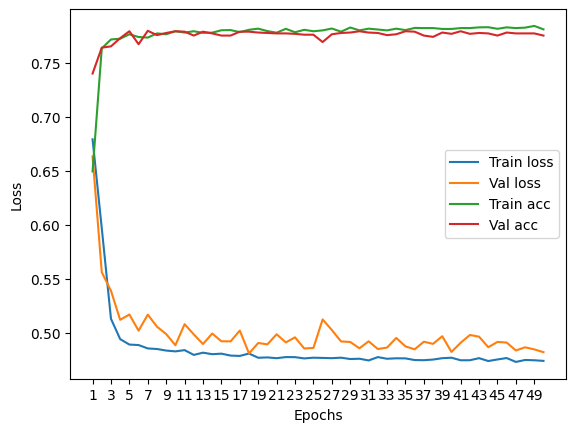

In [99]:
plot_loss(history)

Test accuracy:  77.56


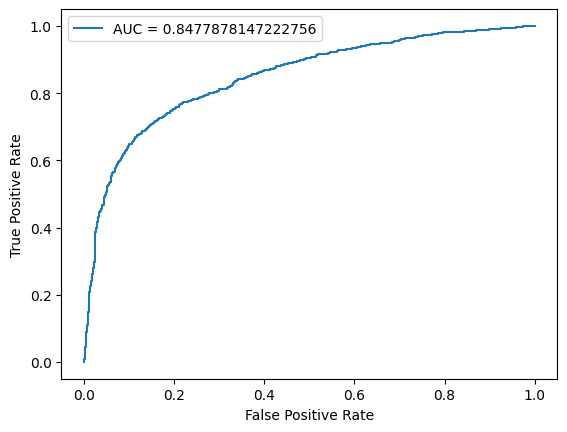

In [100]:
plot_auc(best_model, test_dataloader)

#### With 3 particles _ edge_weights

In [101]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [102]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 152.07it/s]


Train Epoch: 0 	Loss: 0.561166, Accuracy: 5333/7500 (71%)
Val Epoch: 0 	Loss: 0.488534, Accuracy: 1945/2500 (78%)



118it [00:00, 138.52it/s]


Train Epoch: 1 	Loss: 0.489384, Accuracy: 5800/7500 (77%)
Val Epoch: 1 	Loss: 0.504438, Accuracy: 1932/2500 (77%)



118it [00:00, 154.10it/s]


Train Epoch: 2 	Loss: 0.486767, Accuracy: 5819/7500 (78%)
Val Epoch: 2 	Loss: 0.494417, Accuracy: 1929/2500 (77%)



118it [00:01, 98.58it/s]


Train Epoch: 3 	Loss: 0.484695, Accuracy: 5802/7500 (77%)
Val Epoch: 3 	Loss: 0.487004, Accuracy: 1934/2500 (77%)



118it [00:01, 106.15it/s]


Train Epoch: 4 	Loss: 0.483865, Accuracy: 5832/7500 (78%)
Val Epoch: 4 	Loss: 0.490236, Accuracy: 1941/2500 (78%)



118it [00:00, 147.87it/s]


Train Epoch: 5 	Loss: 0.483229, Accuracy: 5842/7500 (78%)
Val Epoch: 5 	Loss: 0.507822, Accuracy: 1905/2500 (76%)



118it [00:00, 151.55it/s]


Train Epoch: 6 	Loss: 0.481793, Accuracy: 5854/7500 (78%)
Val Epoch: 6 	Loss: 0.494572, Accuracy: 1950/2500 (78%)



118it [00:00, 155.69it/s]


Train Epoch: 7 	Loss: 0.480552, Accuracy: 5824/7500 (78%)
Val Epoch: 7 	Loss: 0.493094, Accuracy: 1940/2500 (78%)



118it [00:00, 149.49it/s]


Train Epoch: 8 	Loss: 0.481374, Accuracy: 5852/7500 (78%)
Val Epoch: 8 	Loss: 0.498773, Accuracy: 1924/2500 (77%)



118it [00:00, 154.57it/s]


Train Epoch: 9 	Loss: 0.483028, Accuracy: 5829/7500 (78%)
Val Epoch: 9 	Loss: 0.486595, Accuracy: 1943/2500 (78%)



118it [00:00, 160.69it/s]


Train Epoch: 10 	Loss: 0.477720, Accuracy: 5854/7500 (78%)
Val Epoch: 10 	Loss: 0.492599, Accuracy: 1953/2500 (78%)



118it [00:00, 150.25it/s]


Train Epoch: 11 	Loss: 0.480358, Accuracy: 5842/7500 (78%)
Val Epoch: 11 	Loss: 0.482977, Accuracy: 1945/2500 (78%)



118it [00:00, 150.38it/s]


Train Epoch: 12 	Loss: 0.478480, Accuracy: 5865/7500 (78%)
Val Epoch: 12 	Loss: 0.483049, Accuracy: 1944/2500 (78%)



118it [00:00, 153.49it/s]


Train Epoch: 13 	Loss: 0.478600, Accuracy: 5859/7500 (78%)
Val Epoch: 13 	Loss: 0.490705, Accuracy: 1934/2500 (77%)



118it [00:00, 144.26it/s]


Train Epoch: 14 	Loss: 0.478814, Accuracy: 5855/7500 (78%)
Val Epoch: 14 	Loss: 0.484599, Accuracy: 1945/2500 (78%)



118it [00:01, 104.89it/s]


Train Epoch: 15 	Loss: 0.479000, Accuracy: 5847/7500 (78%)
Val Epoch: 15 	Loss: 0.486681, Accuracy: 1949/2500 (78%)



118it [00:01, 109.92it/s]


Train Epoch: 16 	Loss: 0.478108, Accuracy: 5858/7500 (78%)
Val Epoch: 16 	Loss: 0.493651, Accuracy: 1948/2500 (78%)



118it [00:00, 138.50it/s]


Train Epoch: 17 	Loss: 0.482617, Accuracy: 5831/7500 (78%)
Val Epoch: 17 	Loss: 0.506768, Accuracy: 1939/2500 (78%)



118it [00:00, 161.48it/s]


Train Epoch: 18 	Loss: 0.478621, Accuracy: 5848/7500 (78%)
Val Epoch: 18 	Loss: 0.482090, Accuracy: 1948/2500 (78%)



118it [00:00, 146.53it/s]


Train Epoch: 19 	Loss: 0.474880, Accuracy: 5851/7500 (78%)
Val Epoch: 19 	Loss: 0.513597, Accuracy: 1946/2500 (78%)



118it [00:00, 154.88it/s]


Train Epoch: 20 	Loss: 0.479854, Accuracy: 5830/7500 (78%)
Val Epoch: 20 	Loss: 0.490087, Accuracy: 1947/2500 (78%)



118it [00:00, 153.65it/s]


Train Epoch: 21 	Loss: 0.476092, Accuracy: 5860/7500 (78%)
Val Epoch: 21 	Loss: 0.507972, Accuracy: 1941/2500 (78%)



118it [00:00, 151.02it/s]


Train Epoch: 22 	Loss: 0.478153, Accuracy: 5849/7500 (78%)
Val Epoch: 22 	Loss: 0.507010, Accuracy: 1938/2500 (78%)



118it [00:00, 150.16it/s]


Train Epoch: 23 	Loss: 0.477287, Accuracy: 5858/7500 (78%)
Val Epoch: 23 	Loss: 0.489305, Accuracy: 1945/2500 (78%)



118it [00:00, 144.87it/s]


Train Epoch: 24 	Loss: 0.476191, Accuracy: 5859/7500 (78%)
Val Epoch: 24 	Loss: 0.484621, Accuracy: 1943/2500 (78%)



118it [00:00, 139.15it/s]


Train Epoch: 25 	Loss: 0.475973, Accuracy: 5866/7500 (78%)
Val Epoch: 25 	Loss: 0.501019, Accuracy: 1931/2500 (77%)



118it [00:01, 109.66it/s]


Train Epoch: 26 	Loss: 0.474552, Accuracy: 5867/7500 (78%)
Val Epoch: 26 	Loss: 0.482061, Accuracy: 1949/2500 (78%)



118it [00:01, 100.69it/s]


Train Epoch: 27 	Loss: 0.477808, Accuracy: 5869/7500 (78%)
Val Epoch: 27 	Loss: 0.482984, Accuracy: 1938/2500 (78%)



118it [00:00, 152.94it/s]


Train Epoch: 28 	Loss: 0.474670, Accuracy: 5852/7500 (78%)
Val Epoch: 28 	Loss: 0.497427, Accuracy: 1929/2500 (77%)



118it [00:00, 149.10it/s]


Train Epoch: 29 	Loss: 0.475264, Accuracy: 5846/7500 (78%)
Val Epoch: 29 	Loss: 0.508032, Accuracy: 1928/2500 (77%)



118it [00:00, 154.66it/s]


Train Epoch: 30 	Loss: 0.474113, Accuracy: 5874/7500 (78%)
Val Epoch: 30 	Loss: 0.484172, Accuracy: 1940/2500 (78%)



118it [00:00, 133.89it/s]


Train Epoch: 31 	Loss: 0.474361, Accuracy: 5902/7500 (79%)
Val Epoch: 31 	Loss: 0.488541, Accuracy: 1937/2500 (77%)



118it [00:00, 129.74it/s]


Train Epoch: 32 	Loss: 0.472445, Accuracy: 5873/7500 (78%)
Val Epoch: 32 	Loss: 0.480346, Accuracy: 1940/2500 (78%)



118it [00:00, 144.75it/s]


Train Epoch: 33 	Loss: 0.474350, Accuracy: 5856/7500 (78%)
Val Epoch: 33 	Loss: 0.490539, Accuracy: 1935/2500 (77%)



118it [00:00, 147.44it/s]


Train Epoch: 34 	Loss: 0.473743, Accuracy: 5889/7500 (79%)
Val Epoch: 34 	Loss: 0.482359, Accuracy: 1939/2500 (78%)



118it [00:00, 133.21it/s]


Train Epoch: 35 	Loss: 0.473157, Accuracy: 5877/7500 (78%)
Val Epoch: 35 	Loss: 0.484286, Accuracy: 1941/2500 (78%)



118it [00:00, 138.78it/s]


Train Epoch: 36 	Loss: 0.473599, Accuracy: 5871/7500 (78%)
Val Epoch: 36 	Loss: 0.479708, Accuracy: 1946/2500 (78%)



118it [00:00, 118.92it/s]


Train Epoch: 37 	Loss: 0.475874, Accuracy: 5874/7500 (78%)
Val Epoch: 37 	Loss: 0.491898, Accuracy: 1939/2500 (78%)



118it [00:01, 97.80it/s]


Train Epoch: 38 	Loss: 0.472495, Accuracy: 5852/7500 (78%)
Val Epoch: 38 	Loss: 0.481398, Accuracy: 1940/2500 (78%)



118it [00:00, 134.74it/s]


Train Epoch: 39 	Loss: 0.470539, Accuracy: 5869/7500 (78%)
Val Epoch: 39 	Loss: 0.490536, Accuracy: 1939/2500 (78%)



#### With 3 particles

In [103]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [104]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 144.72it/s]


Train Epoch: 0 	Loss: 0.564105, Accuracy: 5450/7500 (73%)
Val Epoch: 0 	Loss: 0.501897, Accuracy: 1925/2500 (77%)



118it [00:00, 154.81it/s]


Train Epoch: 1 	Loss: 0.488391, Accuracy: 5806/7500 (77%)
Val Epoch: 1 	Loss: 0.483679, Accuracy: 1923/2500 (77%)



118it [00:00, 149.33it/s]


Train Epoch: 2 	Loss: 0.489041, Accuracy: 5802/7500 (77%)
Val Epoch: 2 	Loss: 0.487830, Accuracy: 1927/2500 (77%)



118it [00:00, 148.32it/s]


Train Epoch: 3 	Loss: 0.484678, Accuracy: 5828/7500 (78%)
Val Epoch: 3 	Loss: 0.498875, Accuracy: 1951/2500 (78%)



118it [00:00, 141.75it/s]


Train Epoch: 4 	Loss: 0.485214, Accuracy: 5838/7500 (78%)
Val Epoch: 4 	Loss: 0.492653, Accuracy: 1926/2500 (77%)



118it [00:00, 135.09it/s]


Train Epoch: 5 	Loss: 0.484175, Accuracy: 5811/7500 (77%)
Val Epoch: 5 	Loss: 0.492041, Accuracy: 1937/2500 (77%)



118it [00:00, 142.71it/s]


Train Epoch: 6 	Loss: 0.484268, Accuracy: 5834/7500 (78%)
Val Epoch: 6 	Loss: 0.501211, Accuracy: 1938/2500 (78%)



118it [00:00, 143.48it/s]


Train Epoch: 7 	Loss: 0.484967, Accuracy: 5826/7500 (78%)
Val Epoch: 7 	Loss: 0.481098, Accuracy: 1942/2500 (78%)



118it [00:00, 148.69it/s]


Train Epoch: 8 	Loss: 0.481687, Accuracy: 5831/7500 (78%)
Val Epoch: 8 	Loss: 0.498758, Accuracy: 1941/2500 (78%)



118it [00:01, 99.64it/s] 


Train Epoch: 9 	Loss: 0.480818, Accuracy: 5850/7500 (78%)
Val Epoch: 9 	Loss: 0.515829, Accuracy: 1923/2500 (77%)



118it [00:01, 107.85it/s]


Train Epoch: 10 	Loss: 0.479272, Accuracy: 5855/7500 (78%)
Val Epoch: 10 	Loss: 0.488042, Accuracy: 1943/2500 (78%)



118it [00:00, 150.20it/s]


Train Epoch: 11 	Loss: 0.478259, Accuracy: 5860/7500 (78%)
Val Epoch: 11 	Loss: 0.513751, Accuracy: 1923/2500 (77%)



118it [00:00, 149.09it/s]


Train Epoch: 12 	Loss: 0.479499, Accuracy: 5842/7500 (78%)
Val Epoch: 12 	Loss: 0.493281, Accuracy: 1922/2500 (77%)



118it [00:00, 152.72it/s]


Train Epoch: 13 	Loss: 0.484882, Accuracy: 5855/7500 (78%)
Val Epoch: 13 	Loss: 0.491427, Accuracy: 1946/2500 (78%)



118it [00:00, 152.32it/s]


Train Epoch: 14 	Loss: 0.478649, Accuracy: 5850/7500 (78%)
Val Epoch: 14 	Loss: 0.505007, Accuracy: 1926/2500 (77%)



118it [00:00, 153.19it/s]


Train Epoch: 15 	Loss: 0.479163, Accuracy: 5857/7500 (78%)
Val Epoch: 15 	Loss: 0.490664, Accuracy: 1938/2500 (78%)



118it [00:00, 144.48it/s]


Train Epoch: 16 	Loss: 0.481515, Accuracy: 5827/7500 (78%)
Val Epoch: 16 	Loss: 0.486415, Accuracy: 1940/2500 (78%)



118it [00:00, 143.79it/s]


Train Epoch: 17 	Loss: 0.478966, Accuracy: 5854/7500 (78%)
Val Epoch: 17 	Loss: 0.502087, Accuracy: 1948/2500 (78%)



118it [00:00, 145.36it/s]


Train Epoch: 18 	Loss: 0.480946, Accuracy: 5852/7500 (78%)
Val Epoch: 18 	Loss: 0.484690, Accuracy: 1950/2500 (78%)



118it [00:00, 149.06it/s]


Train Epoch: 19 	Loss: 0.478785, Accuracy: 5877/7500 (78%)
Val Epoch: 19 	Loss: 0.482195, Accuracy: 1934/2500 (77%)



118it [00:01, 117.16it/s]


Train Epoch: 20 	Loss: 0.477293, Accuracy: 5859/7500 (78%)
Val Epoch: 20 	Loss: 0.488985, Accuracy: 1935/2500 (77%)



118it [00:01, 97.99it/s]


Train Epoch: 21 	Loss: 0.478135, Accuracy: 5857/7500 (78%)
Val Epoch: 21 	Loss: 0.501782, Accuracy: 1940/2500 (78%)



118it [00:00, 150.62it/s]


Train Epoch: 22 	Loss: 0.478674, Accuracy: 5867/7500 (78%)
Val Epoch: 22 	Loss: 0.503052, Accuracy: 1918/2500 (77%)



118it [00:00, 158.99it/s]


Train Epoch: 23 	Loss: 0.476714, Accuracy: 5847/7500 (78%)
Val Epoch: 23 	Loss: 0.481915, Accuracy: 1929/2500 (77%)



118it [00:00, 142.87it/s]


Train Epoch: 24 	Loss: 0.478460, Accuracy: 5861/7500 (78%)
Val Epoch: 24 	Loss: 0.481349, Accuracy: 1935/2500 (77%)



118it [00:00, 146.43it/s]


Train Epoch: 25 	Loss: 0.474510, Accuracy: 5873/7500 (78%)
Val Epoch: 25 	Loss: 0.488124, Accuracy: 1937/2500 (77%)



118it [00:00, 147.87it/s]


Train Epoch: 26 	Loss: 0.477207, Accuracy: 5842/7500 (78%)
Val Epoch: 26 	Loss: 0.482335, Accuracy: 1945/2500 (78%)



118it [00:00, 143.80it/s]


Train Epoch: 27 	Loss: 0.476790, Accuracy: 5875/7500 (78%)
Val Epoch: 27 	Loss: 0.501061, Accuracy: 1947/2500 (78%)



118it [00:00, 146.53it/s]


Train Epoch: 28 	Loss: 0.475905, Accuracy: 5857/7500 (78%)
Val Epoch: 28 	Loss: 0.486819, Accuracy: 1946/2500 (78%)



118it [00:00, 147.36it/s]


Train Epoch: 29 	Loss: 0.476758, Accuracy: 5850/7500 (78%)
Val Epoch: 29 	Loss: 0.496007, Accuracy: 1932/2500 (77%)



118it [00:00, 148.13it/s]


Train Epoch: 30 	Loss: 0.474479, Accuracy: 5867/7500 (78%)
Val Epoch: 30 	Loss: 0.503824, Accuracy: 1926/2500 (77%)



118it [00:00, 139.08it/s]


Train Epoch: 31 	Loss: 0.474625, Accuracy: 5874/7500 (78%)
Val Epoch: 31 	Loss: 0.488698, Accuracy: 1945/2500 (78%)



118it [00:01, 104.28it/s]


Train Epoch: 32 	Loss: 0.474818, Accuracy: 5866/7500 (78%)
Val Epoch: 32 	Loss: 0.504891, Accuracy: 1939/2500 (78%)



118it [00:01, 113.21it/s]


Train Epoch: 33 	Loss: 0.475633, Accuracy: 5867/7500 (78%)
Val Epoch: 33 	Loss: 0.486416, Accuracy: 1937/2500 (77%)



118it [00:00, 154.50it/s]


Train Epoch: 34 	Loss: 0.475551, Accuracy: 5884/7500 (78%)
Val Epoch: 34 	Loss: 0.500346, Accuracy: 1942/2500 (78%)



118it [00:00, 150.52it/s]


Train Epoch: 35 	Loss: 0.472390, Accuracy: 5877/7500 (78%)
Val Epoch: 35 	Loss: 0.517164, Accuracy: 1917/2500 (77%)



118it [00:00, 149.31it/s]


Train Epoch: 36 	Loss: 0.472440, Accuracy: 5874/7500 (78%)
Val Epoch: 36 	Loss: 0.500772, Accuracy: 1927/2500 (77%)



118it [00:00, 143.72it/s]


Train Epoch: 37 	Loss: 0.473833, Accuracy: 5884/7500 (78%)
Val Epoch: 37 	Loss: 0.482822, Accuracy: 1941/2500 (78%)



118it [00:00, 145.23it/s]


Train Epoch: 38 	Loss: 0.471482, Accuracy: 5874/7500 (78%)
Val Epoch: 38 	Loss: 0.495230, Accuracy: 1940/2500 (78%)



118it [00:00, 142.53it/s]


Train Epoch: 39 	Loss: 0.476832, Accuracy: 5852/7500 (78%)
Val Epoch: 39 	Loss: 0.491851, Accuracy: 1942/2500 (78%)



Test accuracy:  77.75999999999999


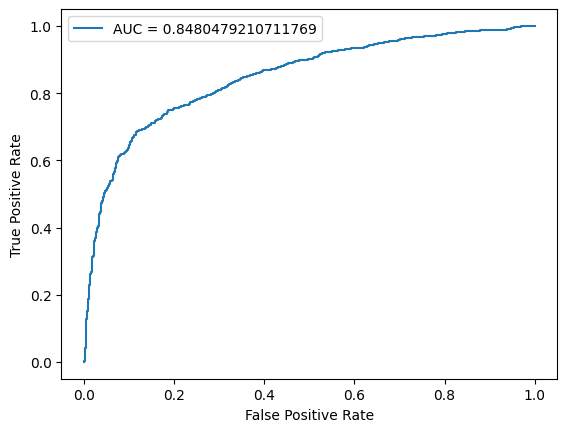

In [105]:
plot_auc(best_model, test_dataloader)

In [106]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 135.60it/s]


Train Epoch: 0 	Loss: 0.474103, Accuracy: 5884/7500 (78%)
Val Epoch: 0 	Loss: 0.501149, Accuracy: 1946/2500 (78%)



118it [00:00, 149.02it/s]


Train Epoch: 1 	Loss: 0.472130, Accuracy: 5880/7500 (78%)
Val Epoch: 1 	Loss: 0.502167, Accuracy: 1944/2500 (78%)



118it [00:00, 146.46it/s]


Train Epoch: 2 	Loss: 0.471066, Accuracy: 5879/7500 (78%)
Val Epoch: 2 	Loss: 0.488936, Accuracy: 1934/2500 (77%)



118it [00:01, 99.54it/s] 


Train Epoch: 3 	Loss: 0.471310, Accuracy: 5910/7500 (79%)
Val Epoch: 3 	Loss: 0.484902, Accuracy: 1928/2500 (77%)



118it [00:01, 105.06it/s]


Train Epoch: 4 	Loss: 0.473547, Accuracy: 5904/7500 (79%)
Val Epoch: 4 	Loss: 0.483683, Accuracy: 1926/2500 (77%)



118it [00:00, 119.30it/s]


Train Epoch: 5 	Loss: 0.469339, Accuracy: 5876/7500 (78%)
Val Epoch: 5 	Loss: 0.498772, Accuracy: 1926/2500 (77%)



118it [00:01, 101.21it/s]


Train Epoch: 6 	Loss: 0.472043, Accuracy: 5878/7500 (78%)
Val Epoch: 6 	Loss: 0.493881, Accuracy: 1941/2500 (78%)



118it [00:00, 142.35it/s]


Train Epoch: 7 	Loss: 0.469617, Accuracy: 5888/7500 (79%)
Val Epoch: 7 	Loss: 0.500067, Accuracy: 1934/2500 (77%)



118it [00:00, 143.97it/s]


Train Epoch: 8 	Loss: 0.469736, Accuracy: 5882/7500 (78%)
Val Epoch: 8 	Loss: 0.483934, Accuracy: 1942/2500 (78%)



118it [00:00, 147.38it/s]


Train Epoch: 9 	Loss: 0.470885, Accuracy: 5881/7500 (78%)
Val Epoch: 9 	Loss: 0.495652, Accuracy: 1936/2500 (77%)



118it [00:00, 148.26it/s]


Train Epoch: 10 	Loss: 0.469331, Accuracy: 5884/7500 (78%)
Val Epoch: 10 	Loss: 0.485438, Accuracy: 1929/2500 (77%)



118it [00:00, 159.85it/s]


Train Epoch: 11 	Loss: 0.470513, Accuracy: 5881/7500 (78%)
Val Epoch: 11 	Loss: 0.491252, Accuracy: 1930/2500 (77%)



118it [00:00, 145.63it/s]


Train Epoch: 12 	Loss: 0.471068, Accuracy: 5903/7500 (79%)
Val Epoch: 12 	Loss: 0.505132, Accuracy: 1928/2500 (77%)



118it [00:00, 128.67it/s]


Train Epoch: 13 	Loss: 0.468544, Accuracy: 5895/7500 (79%)
Val Epoch: 13 	Loss: 0.495942, Accuracy: 1925/2500 (77%)



118it [00:01, 105.95it/s]


Train Epoch: 14 	Loss: 0.472929, Accuracy: 5880/7500 (78%)
Val Epoch: 14 	Loss: 0.491897, Accuracy: 1924/2500 (77%)



118it [00:00, 120.83it/s]


Train Epoch: 15 	Loss: 0.468053, Accuracy: 5908/7500 (79%)
Val Epoch: 15 	Loss: 0.513239, Accuracy: 1928/2500 (77%)



118it [00:00, 147.86it/s]


Train Epoch: 16 	Loss: 0.467875, Accuracy: 5885/7500 (78%)
Val Epoch: 16 	Loss: 0.494858, Accuracy: 1941/2500 (78%)



118it [00:00, 146.65it/s]


Train Epoch: 17 	Loss: 0.469422, Accuracy: 5900/7500 (79%)
Val Epoch: 17 	Loss: 0.517321, Accuracy: 1925/2500 (77%)



118it [00:00, 143.99it/s]


Train Epoch: 18 	Loss: 0.468637, Accuracy: 5893/7500 (79%)
Val Epoch: 18 	Loss: 0.488961, Accuracy: 1943/2500 (78%)



118it [00:00, 152.44it/s]


Train Epoch: 19 	Loss: 0.469078, Accuracy: 5903/7500 (79%)
Val Epoch: 19 	Loss: 0.493621, Accuracy: 1943/2500 (78%)



118it [00:00, 145.44it/s]


Train Epoch: 20 	Loss: 0.472190, Accuracy: 5871/7500 (78%)
Val Epoch: 20 	Loss: 0.516647, Accuracy: 1936/2500 (77%)



118it [00:00, 142.93it/s]


Train Epoch: 21 	Loss: 0.471435, Accuracy: 5896/7500 (79%)
Val Epoch: 21 	Loss: 0.512136, Accuracy: 1941/2500 (78%)



118it [00:00, 152.51it/s]


Train Epoch: 22 	Loss: 0.465206, Accuracy: 5905/7500 (79%)
Val Epoch: 22 	Loss: 0.503930, Accuracy: 1936/2500 (77%)



118it [00:00, 151.42it/s]


Train Epoch: 23 	Loss: 0.468837, Accuracy: 5867/7500 (78%)
Val Epoch: 23 	Loss: 0.492907, Accuracy: 1927/2500 (77%)



118it [00:00, 147.79it/s]


Train Epoch: 24 	Loss: 0.466340, Accuracy: 5922/7500 (79%)
Val Epoch: 24 	Loss: 0.485115, Accuracy: 1937/2500 (77%)



118it [00:01, 110.90it/s]


Train Epoch: 25 	Loss: 0.468035, Accuracy: 5895/7500 (79%)
Val Epoch: 25 	Loss: 0.502804, Accuracy: 1937/2500 (77%)



118it [00:01, 95.88it/s]


Train Epoch: 26 	Loss: 0.467448, Accuracy: 5905/7500 (79%)
Val Epoch: 26 	Loss: 0.489848, Accuracy: 1940/2500 (78%)



118it [00:00, 151.20it/s]


Train Epoch: 27 	Loss: 0.467936, Accuracy: 5897/7500 (79%)
Val Epoch: 27 	Loss: 0.488474, Accuracy: 1952/2500 (78%)



118it [00:00, 140.07it/s]


Train Epoch: 28 	Loss: 0.468340, Accuracy: 5886/7500 (78%)
Val Epoch: 28 	Loss: 0.487019, Accuracy: 1936/2500 (77%)



118it [00:00, 154.73it/s]


Train Epoch: 29 	Loss: 0.469718, Accuracy: 5900/7500 (79%)
Val Epoch: 29 	Loss: 0.510922, Accuracy: 1931/2500 (77%)



118it [00:00, 151.58it/s]


Train Epoch: 30 	Loss: 0.466228, Accuracy: 5922/7500 (79%)
Val Epoch: 30 	Loss: 0.484094, Accuracy: 1930/2500 (77%)



118it [00:00, 143.69it/s]


Train Epoch: 31 	Loss: 0.469927, Accuracy: 5884/7500 (78%)
Val Epoch: 31 	Loss: 0.496675, Accuracy: 1937/2500 (77%)



118it [00:00, 155.83it/s]


Train Epoch: 32 	Loss: 0.469019, Accuracy: 5889/7500 (79%)
Val Epoch: 32 	Loss: 0.489625, Accuracy: 1941/2500 (78%)



118it [00:00, 153.89it/s]


Train Epoch: 33 	Loss: 0.465433, Accuracy: 5902/7500 (79%)
Val Epoch: 33 	Loss: 0.485040, Accuracy: 1936/2500 (77%)



118it [00:00, 149.83it/s]


Train Epoch: 34 	Loss: 0.469434, Accuracy: 5913/7500 (79%)
Val Epoch: 34 	Loss: 0.488591, Accuracy: 1946/2500 (78%)



118it [00:00, 152.38it/s]


Train Epoch: 35 	Loss: 0.466146, Accuracy: 5892/7500 (79%)
Val Epoch: 35 	Loss: 0.486124, Accuracy: 1928/2500 (77%)



118it [00:00, 150.19it/s]


Train Epoch: 36 	Loss: 0.466176, Accuracy: 5897/7500 (79%)
Val Epoch: 36 	Loss: 0.489245, Accuracy: 1956/2500 (78%)



118it [00:01, 106.88it/s]


Train Epoch: 37 	Loss: 0.466737, Accuracy: 5918/7500 (79%)
Val Epoch: 37 	Loss: 0.485213, Accuracy: 1939/2500 (78%)



118it [00:01, 108.33it/s]


Train Epoch: 38 	Loss: 0.464645, Accuracy: 5920/7500 (79%)
Val Epoch: 38 	Loss: 0.497591, Accuracy: 1930/2500 (77%)



118it [00:00, 142.11it/s]


Train Epoch: 39 	Loss: 0.465262, Accuracy: 5899/7500 (79%)
Val Epoch: 39 	Loss: 0.501492, Accuracy: 1933/2500 (77%)



Test accuracy:  75.76


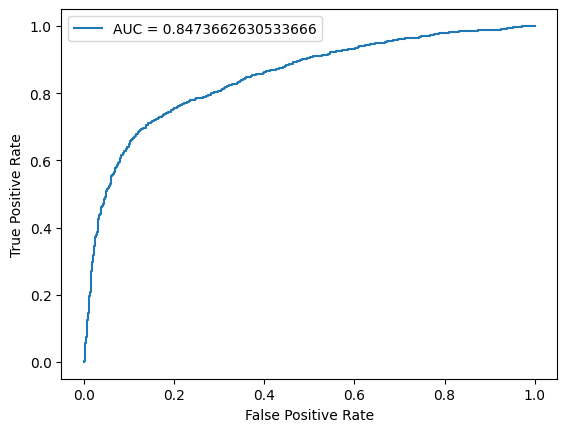

In [108]:
plot_auc(model, test_dataloader)

In [109]:
[p.numel() for p in model.parameters()]

[8, 64, 208, 16, 128, 8, 8, 1]

#### With 2 particles

In [110]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [111]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 106.43it/s]


Train Epoch: 0 	Loss: 0.557038, Accuracy: 5368/7500 (72%)
Val Epoch: 0 	Loss: 0.511172, Accuracy: 1891/2500 (76%)



118it [00:01, 92.21it/s]


Train Epoch: 1 	Loss: 0.488654, Accuracy: 5819/7500 (78%)
Val Epoch: 1 	Loss: 0.496672, Accuracy: 1932/2500 (77%)



118it [00:00, 135.91it/s]


Train Epoch: 2 	Loss: 0.485010, Accuracy: 5812/7500 (77%)
Val Epoch: 2 	Loss: 0.499217, Accuracy: 1922/2500 (77%)



118it [00:00, 144.80it/s]


Train Epoch: 3 	Loss: 0.485859, Accuracy: 5838/7500 (78%)
Val Epoch: 3 	Loss: 0.496044, Accuracy: 1948/2500 (78%)



118it [00:00, 143.49it/s]


Train Epoch: 4 	Loss: 0.483584, Accuracy: 5837/7500 (78%)
Val Epoch: 4 	Loss: 0.491622, Accuracy: 1953/2500 (78%)



118it [00:00, 134.80it/s]


Train Epoch: 5 	Loss: 0.484336, Accuracy: 5854/7500 (78%)
Val Epoch: 5 	Loss: 0.486693, Accuracy: 1942/2500 (78%)



118it [00:00, 144.32it/s]


Train Epoch: 6 	Loss: 0.488297, Accuracy: 5803/7500 (77%)
Val Epoch: 6 	Loss: 0.508254, Accuracy: 1908/2500 (76%)



118it [00:00, 151.46it/s]


Train Epoch: 7 	Loss: 0.486080, Accuracy: 5828/7500 (78%)
Val Epoch: 7 	Loss: 0.491006, Accuracy: 1945/2500 (78%)



118it [00:00, 149.43it/s]


Train Epoch: 8 	Loss: 0.483610, Accuracy: 5855/7500 (78%)
Val Epoch: 8 	Loss: 0.528864, Accuracy: 1896/2500 (76%)



118it [00:00, 148.74it/s]


Train Epoch: 9 	Loss: 0.479956, Accuracy: 5850/7500 (78%)
Val Epoch: 9 	Loss: 0.482293, Accuracy: 1945/2500 (78%)



118it [00:00, 141.99it/s]


Train Epoch: 10 	Loss: 0.481803, Accuracy: 5863/7500 (78%)
Val Epoch: 10 	Loss: 0.491594, Accuracy: 1953/2500 (78%)



118it [00:00, 119.07it/s]


Train Epoch: 11 	Loss: 0.480290, Accuracy: 5864/7500 (78%)
Val Epoch: 11 	Loss: 0.483397, Accuracy: 1941/2500 (78%)



118it [00:01, 97.22it/s]


Train Epoch: 12 	Loss: 0.481330, Accuracy: 5860/7500 (78%)
Val Epoch: 12 	Loss: 0.484732, Accuracy: 1940/2500 (78%)



118it [00:00, 146.67it/s]


Train Epoch: 13 	Loss: 0.480060, Accuracy: 5835/7500 (78%)
Val Epoch: 13 	Loss: 0.480474, Accuracy: 1934/2500 (77%)



118it [00:00, 146.21it/s]


Train Epoch: 14 	Loss: 0.481068, Accuracy: 5839/7500 (78%)
Val Epoch: 14 	Loss: 0.486075, Accuracy: 1940/2500 (78%)



118it [00:00, 150.30it/s]


Train Epoch: 15 	Loss: 0.476250, Accuracy: 5849/7500 (78%)
Val Epoch: 15 	Loss: 0.482415, Accuracy: 1935/2500 (77%)



118it [00:00, 151.80it/s]


Train Epoch: 16 	Loss: 0.478492, Accuracy: 5853/7500 (78%)
Val Epoch: 16 	Loss: 0.503661, Accuracy: 1924/2500 (77%)



118it [00:00, 153.12it/s]


Train Epoch: 17 	Loss: 0.477126, Accuracy: 5861/7500 (78%)
Val Epoch: 17 	Loss: 0.486274, Accuracy: 1942/2500 (78%)



118it [00:00, 152.80it/s]


Train Epoch: 18 	Loss: 0.479162, Accuracy: 5845/7500 (78%)
Val Epoch: 18 	Loss: 0.494624, Accuracy: 1935/2500 (77%)



118it [00:00, 150.35it/s]


Train Epoch: 19 	Loss: 0.475505, Accuracy: 5870/7500 (78%)
Val Epoch: 19 	Loss: 0.487604, Accuracy: 1938/2500 (78%)



118it [00:00, 158.96it/s]


Train Epoch: 20 	Loss: 0.476345, Accuracy: 5870/7500 (78%)
Val Epoch: 20 	Loss: 0.489269, Accuracy: 1935/2500 (77%)



118it [00:00, 144.17it/s]


Train Epoch: 21 	Loss: 0.475683, Accuracy: 5857/7500 (78%)
Val Epoch: 21 	Loss: 0.482905, Accuracy: 1937/2500 (77%)



118it [00:00, 135.68it/s]


Train Epoch: 22 	Loss: 0.475566, Accuracy: 5852/7500 (78%)
Val Epoch: 22 	Loss: 0.519200, Accuracy: 1926/2500 (77%)



118it [00:01, 98.93it/s] 


Train Epoch: 23 	Loss: 0.475048, Accuracy: 5860/7500 (78%)
Val Epoch: 23 	Loss: 0.490152, Accuracy: 1937/2500 (77%)



118it [00:01, 103.36it/s]


Train Epoch: 24 	Loss: 0.477511, Accuracy: 5853/7500 (78%)
Val Epoch: 24 	Loss: 0.497341, Accuracy: 1941/2500 (78%)



118it [00:00, 144.99it/s]


Train Epoch: 25 	Loss: 0.476922, Accuracy: 5866/7500 (78%)
Val Epoch: 25 	Loss: 0.487027, Accuracy: 1921/2500 (77%)



118it [00:00, 134.27it/s]


Train Epoch: 26 	Loss: 0.475684, Accuracy: 5868/7500 (78%)
Val Epoch: 26 	Loss: 0.490235, Accuracy: 1946/2500 (78%)



118it [00:00, 151.60it/s]


Train Epoch: 27 	Loss: 0.476111, Accuracy: 5846/7500 (78%)
Val Epoch: 27 	Loss: 0.484743, Accuracy: 1933/2500 (77%)



118it [00:00, 151.87it/s]


Train Epoch: 28 	Loss: 0.477151, Accuracy: 5883/7500 (78%)
Val Epoch: 28 	Loss: 0.485599, Accuracy: 1936/2500 (77%)



118it [00:00, 146.71it/s]


Train Epoch: 29 	Loss: 0.475734, Accuracy: 5852/7500 (78%)
Val Epoch: 29 	Loss: 0.496632, Accuracy: 1943/2500 (78%)



118it [00:00, 151.67it/s]


Train Epoch: 30 	Loss: 0.473825, Accuracy: 5859/7500 (78%)
Val Epoch: 30 	Loss: 0.485939, Accuracy: 1935/2500 (77%)



118it [00:00, 136.02it/s]


Train Epoch: 31 	Loss: 0.474838, Accuracy: 5874/7500 (78%)
Val Epoch: 31 	Loss: 0.480572, Accuracy: 1932/2500 (77%)



118it [00:00, 144.64it/s]


Train Epoch: 32 	Loss: 0.475366, Accuracy: 5844/7500 (78%)
Val Epoch: 32 	Loss: 0.494901, Accuracy: 1934/2500 (77%)



118it [00:00, 127.17it/s]


Train Epoch: 33 	Loss: 0.472802, Accuracy: 5890/7500 (79%)
Val Epoch: 33 	Loss: 0.484532, Accuracy: 1940/2500 (78%)



118it [00:01, 105.14it/s]


Train Epoch: 34 	Loss: 0.474262, Accuracy: 5852/7500 (78%)
Val Epoch: 34 	Loss: 0.487000, Accuracy: 1939/2500 (78%)



118it [00:01, 96.06it/s]


Train Epoch: 35 	Loss: 0.472462, Accuracy: 5865/7500 (78%)
Val Epoch: 35 	Loss: 0.481757, Accuracy: 1936/2500 (77%)



118it [00:00, 154.28it/s]


Train Epoch: 36 	Loss: 0.474801, Accuracy: 5841/7500 (78%)
Val Epoch: 36 	Loss: 0.485030, Accuracy: 1942/2500 (78%)



118it [00:00, 148.79it/s]


Train Epoch: 37 	Loss: 0.471496, Accuracy: 5881/7500 (78%)
Val Epoch: 37 	Loss: 0.494556, Accuracy: 1930/2500 (77%)



118it [00:00, 146.85it/s]


Train Epoch: 38 	Loss: 0.473251, Accuracy: 5893/7500 (79%)
Val Epoch: 38 	Loss: 0.490063, Accuracy: 1931/2500 (77%)



118it [00:00, 148.04it/s]


Train Epoch: 39 	Loss: 0.473474, Accuracy: 5869/7500 (78%)
Val Epoch: 39 	Loss: 0.504203, Accuracy: 1929/2500 (77%)



Test accuracy:  75.84


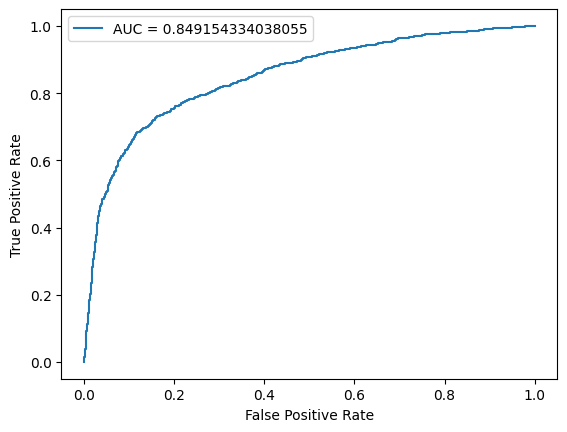

In [112]:
plot_auc(best_model, test_dataloader)

#### With 1 particle

In [113]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [114]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 144.62it/s]


Train Epoch: 0 	Loss: 0.575444, Accuracy: 5280/7500 (70%)
Val Epoch: 0 	Loss: 0.499509, Accuracy: 1928/2500 (77%)



118it [00:00, 135.23it/s]


Train Epoch: 1 	Loss: 0.488655, Accuracy: 5806/7500 (77%)
Val Epoch: 1 	Loss: 0.485575, Accuracy: 1941/2500 (78%)



118it [00:00, 145.35it/s]


Train Epoch: 2 	Loss: 0.483837, Accuracy: 5821/7500 (78%)
Val Epoch: 2 	Loss: 0.497599, Accuracy: 1947/2500 (78%)



118it [00:00, 148.09it/s]


Train Epoch: 3 	Loss: 0.481679, Accuracy: 5824/7500 (78%)
Val Epoch: 3 	Loss: 0.507081, Accuracy: 1934/2500 (77%)



118it [00:00, 147.06it/s]


Train Epoch: 4 	Loss: 0.484168, Accuracy: 5819/7500 (78%)
Val Epoch: 4 	Loss: 0.507094, Accuracy: 1913/2500 (77%)



118it [00:00, 142.57it/s]


Train Epoch: 5 	Loss: 0.482809, Accuracy: 5825/7500 (78%)
Val Epoch: 5 	Loss: 0.479887, Accuracy: 1946/2500 (78%)



118it [00:00, 146.28it/s]


Train Epoch: 6 	Loss: 0.479815, Accuracy: 5848/7500 (78%)
Val Epoch: 6 	Loss: 0.494627, Accuracy: 1949/2500 (78%)



118it [00:00, 130.49it/s]


Train Epoch: 7 	Loss: 0.480975, Accuracy: 5843/7500 (78%)
Val Epoch: 7 	Loss: 0.495464, Accuracy: 1927/2500 (77%)



118it [00:01, 102.02it/s]


Train Epoch: 8 	Loss: 0.482672, Accuracy: 5831/7500 (78%)
Val Epoch: 8 	Loss: 0.521352, Accuracy: 1884/2500 (75%)



118it [00:00, 125.40it/s]


Train Epoch: 9 	Loss: 0.484800, Accuracy: 5830/7500 (78%)
Val Epoch: 9 	Loss: 0.500427, Accuracy: 1923/2500 (77%)



118it [00:00, 147.48it/s]


Train Epoch: 10 	Loss: 0.480686, Accuracy: 5865/7500 (78%)
Val Epoch: 10 	Loss: 0.493070, Accuracy: 1922/2500 (77%)



118it [00:00, 134.70it/s]


Train Epoch: 11 	Loss: 0.481329, Accuracy: 5831/7500 (78%)
Val Epoch: 11 	Loss: 0.499622, Accuracy: 1948/2500 (78%)



118it [00:00, 162.69it/s]


Train Epoch: 12 	Loss: 0.478978, Accuracy: 5857/7500 (78%)
Val Epoch: 12 	Loss: 0.483586, Accuracy: 1942/2500 (78%)



118it [00:00, 149.75it/s]


Train Epoch: 13 	Loss: 0.478562, Accuracy: 5857/7500 (78%)
Val Epoch: 13 	Loss: 0.487354, Accuracy: 1935/2500 (77%)



118it [00:00, 148.90it/s]


Train Epoch: 14 	Loss: 0.477194, Accuracy: 5856/7500 (78%)
Val Epoch: 14 	Loss: 0.483821, Accuracy: 1947/2500 (78%)



118it [00:00, 150.92it/s]


Train Epoch: 15 	Loss: 0.478634, Accuracy: 5844/7500 (78%)
Val Epoch: 15 	Loss: 0.494568, Accuracy: 1949/2500 (78%)



118it [00:00, 147.81it/s]


Train Epoch: 16 	Loss: 0.480927, Accuracy: 5857/7500 (78%)
Val Epoch: 16 	Loss: 0.489187, Accuracy: 1941/2500 (78%)



118it [00:00, 148.56it/s]


Train Epoch: 17 	Loss: 0.479122, Accuracy: 5868/7500 (78%)
Val Epoch: 17 	Loss: 0.483819, Accuracy: 1957/2500 (78%)



118it [00:00, 151.66it/s]


Train Epoch: 18 	Loss: 0.479579, Accuracy: 5862/7500 (78%)
Val Epoch: 18 	Loss: 0.483138, Accuracy: 1937/2500 (77%)



118it [00:01, 99.67it/s]


Train Epoch: 19 	Loss: 0.477130, Accuracy: 5873/7500 (78%)
Val Epoch: 19 	Loss: 0.486811, Accuracy: 1953/2500 (78%)



118it [00:01, 105.26it/s]


Train Epoch: 20 	Loss: 0.478841, Accuracy: 5848/7500 (78%)
Val Epoch: 20 	Loss: 0.494188, Accuracy: 1919/2500 (77%)



118it [00:00, 153.48it/s]


Train Epoch: 21 	Loss: 0.478318, Accuracy: 5856/7500 (78%)
Val Epoch: 21 	Loss: 0.498258, Accuracy: 1942/2500 (78%)



118it [00:00, 157.15it/s]


Train Epoch: 22 	Loss: 0.476535, Accuracy: 5831/7500 (78%)
Val Epoch: 22 	Loss: 0.493670, Accuracy: 1933/2500 (77%)



118it [00:00, 154.88it/s]


Train Epoch: 23 	Loss: 0.478983, Accuracy: 5850/7500 (78%)
Val Epoch: 23 	Loss: 0.480924, Accuracy: 1950/2500 (78%)



118it [00:00, 153.44it/s]


Train Epoch: 24 	Loss: 0.479082, Accuracy: 5885/7500 (78%)
Val Epoch: 24 	Loss: 0.481052, Accuracy: 1953/2500 (78%)



118it [00:00, 150.20it/s]


Train Epoch: 25 	Loss: 0.479638, Accuracy: 5887/7500 (78%)
Val Epoch: 25 	Loss: 0.487560, Accuracy: 1940/2500 (78%)



118it [00:00, 152.32it/s]


Train Epoch: 26 	Loss: 0.475378, Accuracy: 5873/7500 (78%)
Val Epoch: 26 	Loss: 0.494670, Accuracy: 1941/2500 (78%)



118it [00:00, 151.47it/s]


Train Epoch: 27 	Loss: 0.477663, Accuracy: 5873/7500 (78%)
Val Epoch: 27 	Loss: 0.490919, Accuracy: 1939/2500 (78%)



118it [00:00, 151.68it/s]


Train Epoch: 28 	Loss: 0.476609, Accuracy: 5860/7500 (78%)
Val Epoch: 28 	Loss: 0.482157, Accuracy: 1943/2500 (78%)



118it [00:00, 135.38it/s]


Train Epoch: 29 	Loss: 0.477610, Accuracy: 5846/7500 (78%)
Val Epoch: 29 	Loss: 0.495375, Accuracy: 1943/2500 (78%)



118it [00:00, 140.88it/s]


Train Epoch: 30 	Loss: 0.476027, Accuracy: 5863/7500 (78%)
Val Epoch: 30 	Loss: 0.493017, Accuracy: 1939/2500 (78%)



118it [00:01, 101.85it/s]


Train Epoch: 31 	Loss: 0.477033, Accuracy: 5858/7500 (78%)
Val Epoch: 31 	Loss: 0.507065, Accuracy: 1943/2500 (78%)



118it [00:00, 123.48it/s]


Train Epoch: 32 	Loss: 0.474152, Accuracy: 5879/7500 (78%)
Val Epoch: 32 	Loss: 0.480102, Accuracy: 1945/2500 (78%)



118it [00:00, 155.92it/s]


Train Epoch: 33 	Loss: 0.476589, Accuracy: 5875/7500 (78%)
Val Epoch: 33 	Loss: 0.482497, Accuracy: 1946/2500 (78%)



118it [00:00, 161.34it/s]


Train Epoch: 34 	Loss: 0.476529, Accuracy: 5866/7500 (78%)
Val Epoch: 34 	Loss: 0.492578, Accuracy: 1944/2500 (78%)



118it [00:00, 158.15it/s]


Train Epoch: 35 	Loss: 0.474044, Accuracy: 5879/7500 (78%)
Val Epoch: 35 	Loss: 0.487700, Accuracy: 1942/2500 (78%)



118it [00:00, 153.58it/s]


Train Epoch: 36 	Loss: 0.478268, Accuracy: 5864/7500 (78%)
Val Epoch: 36 	Loss: 0.493951, Accuracy: 1944/2500 (78%)



118it [00:00, 146.28it/s]


Train Epoch: 37 	Loss: 0.472628, Accuracy: 5890/7500 (79%)
Val Epoch: 37 	Loss: 0.490191, Accuracy: 1937/2500 (77%)



118it [00:00, 153.77it/s]


Train Epoch: 38 	Loss: 0.472555, Accuracy: 5902/7500 (79%)
Val Epoch: 38 	Loss: 0.497648, Accuracy: 1921/2500 (77%)



118it [00:00, 151.84it/s]


Train Epoch: 39 	Loss: 0.473650, Accuracy: 5881/7500 (78%)
Val Epoch: 39 	Loss: 0.496195, Accuracy: 1943/2500 (78%)



Test accuracy:  77.75999999999999


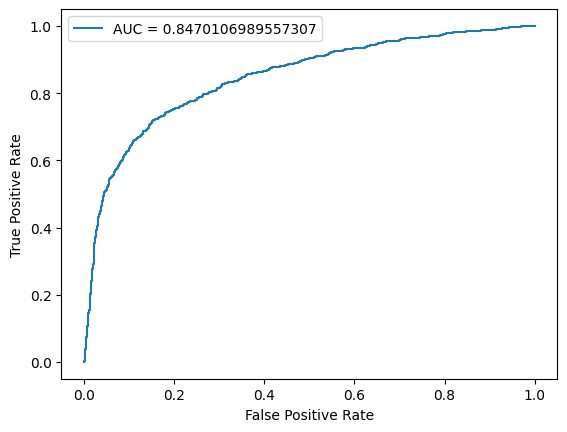

In [115]:
plot_auc(best_model, test_dataloader)

All particles

In [116]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 147.53it/s]


Train Epoch: 0 	Loss: 0.473355, Accuracy: 5880/7500 (78%)
Val Epoch: 0 	Loss: 0.497959, Accuracy: 1938/2500 (78%)



118it [00:00, 149.52it/s]


Train Epoch: 1 	Loss: 0.473777, Accuracy: 5856/7500 (78%)
Val Epoch: 1 	Loss: 0.487524, Accuracy: 1945/2500 (78%)



118it [00:01, 113.85it/s]


Train Epoch: 2 	Loss: 0.472921, Accuracy: 5878/7500 (78%)
Val Epoch: 2 	Loss: 0.500302, Accuracy: 1941/2500 (78%)



118it [00:01, 93.80it/s]


Train Epoch: 3 	Loss: 0.471411, Accuracy: 5891/7500 (79%)
Val Epoch: 3 	Loss: 0.492999, Accuracy: 1937/2500 (77%)



118it [00:00, 154.52it/s]


Train Epoch: 4 	Loss: 0.473263, Accuracy: 5886/7500 (78%)
Val Epoch: 4 	Loss: 0.487558, Accuracy: 1934/2500 (77%)



118it [00:00, 145.88it/s]


Train Epoch: 5 	Loss: 0.470998, Accuracy: 5882/7500 (78%)
Val Epoch: 5 	Loss: 0.493592, Accuracy: 1938/2500 (78%)



118it [00:00, 146.67it/s]


Train Epoch: 6 	Loss: 0.471490, Accuracy: 5900/7500 (79%)
Val Epoch: 6 	Loss: 0.485276, Accuracy: 1945/2500 (78%)



118it [00:00, 147.28it/s]


Train Epoch: 7 	Loss: 0.472759, Accuracy: 5877/7500 (78%)
Val Epoch: 7 	Loss: 0.481972, Accuracy: 1942/2500 (78%)



118it [00:00, 144.74it/s]


Train Epoch: 8 	Loss: 0.471838, Accuracy: 5883/7500 (78%)
Val Epoch: 8 	Loss: 0.495335, Accuracy: 1929/2500 (77%)



118it [00:00, 146.97it/s]


Train Epoch: 9 	Loss: 0.474056, Accuracy: 5885/7500 (78%)
Val Epoch: 9 	Loss: 0.497144, Accuracy: 1920/2500 (77%)



118it [00:00, 142.84it/s]


Train Epoch: 10 	Loss: 0.471548, Accuracy: 5888/7500 (79%)
Val Epoch: 10 	Loss: 0.484024, Accuracy: 1934/2500 (77%)



118it [00:00, 146.31it/s]


Train Epoch: 11 	Loss: 0.470305, Accuracy: 5911/7500 (79%)
Val Epoch: 11 	Loss: 0.493880, Accuracy: 1949/2500 (78%)



118it [00:00, 149.51it/s]


Train Epoch: 12 	Loss: 0.470776, Accuracy: 5886/7500 (78%)
Val Epoch: 12 	Loss: 0.494255, Accuracy: 1946/2500 (78%)



118it [00:00, 152.11it/s]


Train Epoch: 13 	Loss: 0.472771, Accuracy: 5870/7500 (78%)
Val Epoch: 13 	Loss: 0.485146, Accuracy: 1939/2500 (78%)



118it [00:01, 108.30it/s]


Train Epoch: 14 	Loss: 0.469991, Accuracy: 5901/7500 (79%)
Val Epoch: 14 	Loss: 0.484550, Accuracy: 1934/2500 (77%)



118it [00:01, 108.58it/s]


Train Epoch: 15 	Loss: 0.471649, Accuracy: 5908/7500 (79%)
Val Epoch: 15 	Loss: 0.490233, Accuracy: 1933/2500 (77%)



118it [00:00, 143.35it/s]


Train Epoch: 16 	Loss: 0.470208, Accuracy: 5880/7500 (78%)
Val Epoch: 16 	Loss: 0.498187, Accuracy: 1930/2500 (77%)



118it [00:00, 145.34it/s]


Train Epoch: 17 	Loss: 0.470637, Accuracy: 5892/7500 (79%)
Val Epoch: 17 	Loss: 0.486231, Accuracy: 1922/2500 (77%)



118it [00:00, 146.56it/s]


Train Epoch: 18 	Loss: 0.469855, Accuracy: 5879/7500 (78%)
Val Epoch: 18 	Loss: 0.494481, Accuracy: 1934/2500 (77%)



118it [00:00, 148.03it/s]


Train Epoch: 19 	Loss: 0.470619, Accuracy: 5878/7500 (78%)
Val Epoch: 19 	Loss: 0.493600, Accuracy: 1930/2500 (77%)



118it [00:00, 150.43it/s]


Train Epoch: 20 	Loss: 0.468311, Accuracy: 5904/7500 (79%)
Val Epoch: 20 	Loss: 0.489357, Accuracy: 1924/2500 (77%)



118it [00:00, 142.07it/s]


Train Epoch: 21 	Loss: 0.469919, Accuracy: 5879/7500 (78%)
Val Epoch: 21 	Loss: 0.483202, Accuracy: 1940/2500 (78%)



118it [00:00, 146.68it/s]


Train Epoch: 22 	Loss: 0.471283, Accuracy: 5892/7500 (79%)
Val Epoch: 22 	Loss: 0.487659, Accuracy: 1935/2500 (77%)



118it [00:00, 148.13it/s]


Train Epoch: 23 	Loss: 0.470722, Accuracy: 5906/7500 (79%)
Val Epoch: 23 	Loss: 0.497638, Accuracy: 1923/2500 (77%)



118it [00:00, 146.02it/s]


Train Epoch: 24 	Loss: 0.469918, Accuracy: 5898/7500 (79%)
Val Epoch: 24 	Loss: 0.515222, Accuracy: 1940/2500 (78%)



118it [00:01, 116.48it/s]


Train Epoch: 25 	Loss: 0.469867, Accuracy: 5892/7500 (79%)
Val Epoch: 25 	Loss: 0.499218, Accuracy: 1934/2500 (77%)



118it [00:01, 104.72it/s]


Train Epoch: 26 	Loss: 0.468620, Accuracy: 5902/7500 (79%)
Val Epoch: 26 	Loss: 0.491085, Accuracy: 1931/2500 (77%)



118it [00:00, 147.53it/s]


Train Epoch: 27 	Loss: 0.468212, Accuracy: 5873/7500 (78%)
Val Epoch: 27 	Loss: 0.486500, Accuracy: 1935/2500 (77%)



118it [00:00, 149.32it/s]


Train Epoch: 28 	Loss: 0.469136, Accuracy: 5882/7500 (78%)
Val Epoch: 28 	Loss: 0.483414, Accuracy: 1936/2500 (77%)



118it [00:00, 143.94it/s]


Train Epoch: 29 	Loss: 0.467563, Accuracy: 5921/7500 (79%)
Val Epoch: 29 	Loss: 0.483835, Accuracy: 1926/2500 (77%)



118it [00:00, 140.15it/s]


Train Epoch: 30 	Loss: 0.468187, Accuracy: 5902/7500 (79%)
Val Epoch: 30 	Loss: 0.515773, Accuracy: 1931/2500 (77%)



118it [00:00, 143.46it/s]


Train Epoch: 31 	Loss: 0.469746, Accuracy: 5911/7500 (79%)
Val Epoch: 31 	Loss: 0.516456, Accuracy: 1926/2500 (77%)



118it [00:00, 140.06it/s]


Train Epoch: 32 	Loss: 0.467850, Accuracy: 5894/7500 (79%)
Val Epoch: 32 	Loss: 0.495986, Accuracy: 1928/2500 (77%)



118it [00:00, 136.59it/s]


Train Epoch: 33 	Loss: 0.467431, Accuracy: 5901/7500 (79%)
Val Epoch: 33 	Loss: 0.485855, Accuracy: 1944/2500 (78%)



118it [00:00, 146.50it/s]


Train Epoch: 34 	Loss: 0.468597, Accuracy: 5903/7500 (79%)
Val Epoch: 34 	Loss: 0.510461, Accuracy: 1930/2500 (77%)



118it [00:00, 145.55it/s]


Train Epoch: 35 	Loss: 0.468106, Accuracy: 5894/7500 (79%)
Val Epoch: 35 	Loss: 0.486280, Accuracy: 1926/2500 (77%)



118it [00:00, 131.81it/s]


Train Epoch: 36 	Loss: 0.466985, Accuracy: 5886/7500 (78%)
Val Epoch: 36 	Loss: 0.489861, Accuracy: 1930/2500 (77%)



118it [00:01, 100.42it/s]


Train Epoch: 37 	Loss: 0.466960, Accuracy: 5903/7500 (79%)
Val Epoch: 37 	Loss: 0.494714, Accuracy: 1936/2500 (77%)



118it [00:00, 124.11it/s]


Train Epoch: 38 	Loss: 0.469476, Accuracy: 5884/7500 (78%)
Val Epoch: 38 	Loss: 0.483195, Accuracy: 1934/2500 (77%)



118it [00:00, 143.17it/s]


Train Epoch: 39 	Loss: 0.466099, Accuracy: 5899/7500 (79%)
Val Epoch: 39 	Loss: 0.491458, Accuracy: 1925/2500 (77%)



Test accuracy:  77.52


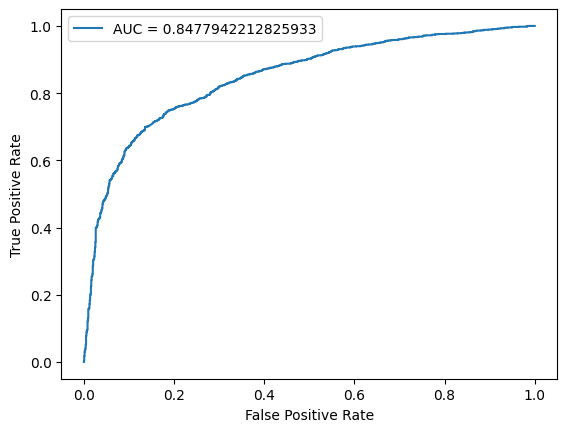

In [118]:
plot_auc(model, test_dataloader)

In [119]:
hidden_dims = [10,16,8]

In [120]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 10)
    (1): GCNConv(10, 16)
    (2): GCNConv(16, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [121]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 104.31it/s]


Train Epoch: 0 	Loss: 0.693192, Accuracy: 4417/7500 (59%)
Val Epoch: 0 	Loss: 0.693324, Accuracy: 1891/2500 (76%)



118it [00:01, 113.69it/s]


Train Epoch: 1 	Loss: 0.622892, Accuracy: 5673/7500 (76%)
Val Epoch: 1 	Loss: 0.536389, Accuracy: 1944/2500 (78%)



118it [00:01, 109.19it/s]


Train Epoch: 2 	Loss: 0.499540, Accuracy: 5764/7500 (77%)
Val Epoch: 2 	Loss: 0.505514, Accuracy: 1942/2500 (78%)



118it [00:01, 112.18it/s]


Train Epoch: 3 	Loss: 0.489579, Accuracy: 5800/7500 (77%)
Val Epoch: 3 	Loss: 0.499787, Accuracy: 1940/2500 (78%)



118it [00:01, 109.77it/s]


Train Epoch: 4 	Loss: 0.488051, Accuracy: 5801/7500 (77%)
Val Epoch: 4 	Loss: 0.506792, Accuracy: 1939/2500 (78%)



118it [00:01, 110.60it/s]


Train Epoch: 5 	Loss: 0.484599, Accuracy: 5811/7500 (77%)
Val Epoch: 5 	Loss: 0.503477, Accuracy: 1934/2500 (77%)



118it [00:01, 105.71it/s]


Train Epoch: 6 	Loss: 0.486789, Accuracy: 5824/7500 (78%)
Val Epoch: 6 	Loss: 0.495274, Accuracy: 1939/2500 (78%)



118it [00:01, 76.11it/s]


Train Epoch: 7 	Loss: 0.482794, Accuracy: 5816/7500 (78%)
Val Epoch: 7 	Loss: 0.487679, Accuracy: 1924/2500 (77%)



118it [00:01, 110.45it/s]


Train Epoch: 8 	Loss: 0.482740, Accuracy: 5804/7500 (77%)
Val Epoch: 8 	Loss: 0.489359, Accuracy: 1945/2500 (78%)



118it [00:01, 108.97it/s]


Train Epoch: 9 	Loss: 0.481010, Accuracy: 5825/7500 (78%)
Val Epoch: 9 	Loss: 0.494738, Accuracy: 1938/2500 (78%)



118it [00:01, 107.74it/s]


Train Epoch: 10 	Loss: 0.480573, Accuracy: 5823/7500 (78%)
Val Epoch: 10 	Loss: 0.484388, Accuracy: 1933/2500 (77%)



118it [00:01, 115.14it/s]


Train Epoch: 11 	Loss: 0.481500, Accuracy: 5823/7500 (78%)
Val Epoch: 11 	Loss: 0.490350, Accuracy: 1946/2500 (78%)



118it [00:01, 113.65it/s]


Train Epoch: 12 	Loss: 0.479834, Accuracy: 5845/7500 (78%)
Val Epoch: 12 	Loss: 0.488499, Accuracy: 1939/2500 (78%)



118it [00:01, 116.22it/s]


Train Epoch: 13 	Loss: 0.479222, Accuracy: 5830/7500 (78%)
Val Epoch: 13 	Loss: 0.490010, Accuracy: 1939/2500 (78%)



118it [00:01, 113.96it/s]


Train Epoch: 14 	Loss: 0.481209, Accuracy: 5850/7500 (78%)
Val Epoch: 14 	Loss: 0.495136, Accuracy: 1944/2500 (78%)



118it [00:01, 100.32it/s]


Train Epoch: 15 	Loss: 0.480715, Accuracy: 5840/7500 (78%)
Val Epoch: 15 	Loss: 0.492009, Accuracy: 1941/2500 (78%)



118it [00:01, 75.80it/s]


Train Epoch: 16 	Loss: 0.478963, Accuracy: 5849/7500 (78%)
Val Epoch: 16 	Loss: 0.489326, Accuracy: 1937/2500 (77%)



118it [00:01, 111.79it/s]


Train Epoch: 17 	Loss: 0.481245, Accuracy: 5835/7500 (78%)
Val Epoch: 17 	Loss: 0.494439, Accuracy: 1936/2500 (77%)



118it [00:01, 110.54it/s]


Train Epoch: 18 	Loss: 0.476541, Accuracy: 5861/7500 (78%)
Val Epoch: 18 	Loss: 0.499999, Accuracy: 1935/2500 (77%)



118it [00:01, 102.35it/s]


Train Epoch: 19 	Loss: 0.479163, Accuracy: 5839/7500 (78%)
Val Epoch: 19 	Loss: 0.493904, Accuracy: 1936/2500 (77%)



118it [00:01, 112.08it/s]


Train Epoch: 20 	Loss: 0.478109, Accuracy: 5845/7500 (78%)
Val Epoch: 20 	Loss: 0.484109, Accuracy: 1940/2500 (78%)



118it [00:01, 109.19it/s]


Train Epoch: 21 	Loss: 0.478351, Accuracy: 5846/7500 (78%)
Val Epoch: 21 	Loss: 0.495847, Accuracy: 1941/2500 (78%)



118it [00:01, 113.14it/s]


Train Epoch: 22 	Loss: 0.476619, Accuracy: 5852/7500 (78%)
Val Epoch: 22 	Loss: 0.485147, Accuracy: 1949/2500 (78%)



118it [00:01, 112.18it/s]


Train Epoch: 23 	Loss: 0.476986, Accuracy: 5861/7500 (78%)
Val Epoch: 23 	Loss: 0.491461, Accuracy: 1933/2500 (77%)



118it [00:01, 88.47it/s]


Train Epoch: 24 	Loss: 0.476749, Accuracy: 5849/7500 (78%)
Val Epoch: 24 	Loss: 0.483071, Accuracy: 1943/2500 (78%)



118it [00:01, 79.07it/s]


Train Epoch: 25 	Loss: 0.477315, Accuracy: 5876/7500 (78%)
Val Epoch: 25 	Loss: 0.511282, Accuracy: 1946/2500 (78%)



118it [00:01, 108.87it/s]


Train Epoch: 26 	Loss: 0.480181, Accuracy: 5837/7500 (78%)
Val Epoch: 26 	Loss: 0.498794, Accuracy: 1942/2500 (78%)



118it [00:01, 108.26it/s]


Train Epoch: 27 	Loss: 0.476127, Accuracy: 5852/7500 (78%)
Val Epoch: 27 	Loss: 0.489380, Accuracy: 1947/2500 (78%)



118it [00:01, 101.56it/s]


Train Epoch: 28 	Loss: 0.476229, Accuracy: 5875/7500 (78%)
Val Epoch: 28 	Loss: 0.489156, Accuracy: 1938/2500 (78%)



118it [00:01, 108.79it/s]


Train Epoch: 29 	Loss: 0.476769, Accuracy: 5856/7500 (78%)
Val Epoch: 29 	Loss: 0.485130, Accuracy: 1947/2500 (78%)



118it [00:01, 98.03it/s]


Train Epoch: 30 	Loss: 0.476132, Accuracy: 5839/7500 (78%)
Val Epoch: 30 	Loss: 0.491579, Accuracy: 1935/2500 (77%)



118it [00:01, 107.73it/s]


Train Epoch: 31 	Loss: 0.475600, Accuracy: 5844/7500 (78%)
Val Epoch: 31 	Loss: 0.488850, Accuracy: 1954/2500 (78%)



118it [00:01, 109.74it/s]


Train Epoch: 32 	Loss: 0.474760, Accuracy: 5870/7500 (78%)
Val Epoch: 32 	Loss: 0.485970, Accuracy: 1953/2500 (78%)



118it [00:01, 74.91it/s]


Train Epoch: 33 	Loss: 0.475112, Accuracy: 5851/7500 (78%)
Val Epoch: 33 	Loss: 0.484857, Accuracy: 1935/2500 (77%)



118it [00:01, 90.50it/s]


Train Epoch: 34 	Loss: 0.476672, Accuracy: 5862/7500 (78%)
Val Epoch: 34 	Loss: 0.489357, Accuracy: 1937/2500 (77%)



118it [00:01, 75.46it/s]


Train Epoch: 35 	Loss: 0.473785, Accuracy: 5853/7500 (78%)
Val Epoch: 35 	Loss: 0.489112, Accuracy: 1936/2500 (77%)



118it [00:01, 110.08it/s]


Train Epoch: 36 	Loss: 0.474778, Accuracy: 5864/7500 (78%)
Val Epoch: 36 	Loss: 0.484936, Accuracy: 1948/2500 (78%)



118it [00:01, 108.86it/s]


Train Epoch: 37 	Loss: 0.475332, Accuracy: 5867/7500 (78%)
Val Epoch: 37 	Loss: 0.499778, Accuracy: 1946/2500 (78%)



118it [00:01, 113.99it/s]


Train Epoch: 38 	Loss: 0.476745, Accuracy: 5838/7500 (78%)
Val Epoch: 38 	Loss: 0.495339, Accuracy: 1943/2500 (78%)



118it [00:01, 115.85it/s]


Train Epoch: 39 	Loss: 0.474557, Accuracy: 5860/7500 (78%)
Val Epoch: 39 	Loss: 0.483313, Accuracy: 1938/2500 (78%)



Test accuracy:  77.16


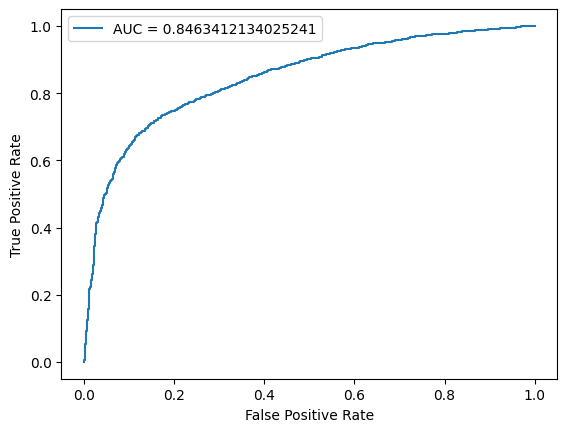

In [123]:
plot_auc(model, test_dataloader)

### Classical GAT - Custom Graph Attention Layer

In [124]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
#         self.heads = heads
#         seld.concat = concat
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.attn = nn.Sequential(Linear(out_channels*2, 8),
                                  ReLU(),
                                  Linear(8,1),
                                  LeakyReLU(0.2)
                                 )
        total_out_channels = out_channels
        self.bias = nn.Parameter(torch.empty(total_out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin.reset_parameters()

        for layer in self.attn:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # H, C = self.heads, self.out_channels

        x = self.lin(x)    #.view(-1, H, C)

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # alpha = self.edge_update(x_i, x_j, edge_attr=edge_attr)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x)

        # out = out.mean(dim=1)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out


    def message(self, x_i, x_j):
        x_edge = torch.cat((x_i,x_j),dim=1)
        x_edge = self.attn(x_edge)
        return x_edge.view(-1,1) * x_j

In [125]:
class GAT(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn = LeakyReLU(0.2)):

        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))

        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(
                            Linear(hidden_dims[-1]+5, 8),
                            ReLU(),
                            Linear(8,1)
                          )

    def forward(self, x, edge_index, edge_attr, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

### Classical GCN - Custom GraphConv Layer

In [126]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_weight):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        # Apply the quantum circuit to each element of the batch and append to q_out
#         q_out = torch.Tensor(0, self.n_qubits)

#         for xi in x:
#             q_out_elem = self.qc(xi).float().unsqueeze(0)
#             q_out = torch.cat((q_out, q_out_elem))
        out = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, out.size(0), dtype=out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=edge_weight*out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [127]:
class GCN(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn = LeakyReLU(0.2)):

        super().__init__()
        layers = [GCNConv(input_dims, hidden_dims)]
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = nn.Linear(hidden_dims, output_dims)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

#### LeakyReLU

#### Learning rate = 1e-3

In [128]:
epochs = 20

In [148]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0-2): 3 x GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [147]:
class GCN(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn=LeakyReLU(0.2)):
        super().__init__()
        layers = [GCNConv(input_dims, hidden_dims[0])] # Use the first element of hidden_dims for the first layer

        for i in range(len(hidden_dims) - 1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i + 1]))  # Use consecutive elements of hidden_dims for subsequent layers

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = nn.Linear(hidden_dims[-1], output_dims)  # Use the last element of hidden_dims for the classifier input

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)  # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

In [149]:
[p.numel() for p in model.parameters()]

[10, 80, 16, 160, 8, 128, 8, 1]

In [ ]:
plot_loss(history)

#### Learning rate = 1e-2

In [152]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0-2): 3 x GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
plot_loss(history)

#### ReLU

#### Learning rate = 1e-3

#### GAT - 10 particles, 100K jets

In [154]:
model = GAT(input_dims, [16,64,32,8], output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-3): 4 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [155]:
params = [p.numel() for p in model.parameters()]
sum(params)

5685

In [156]:
epochs=40
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:02, 48.10it/s]


Train Epoch: 0 	Loss: 0.697958, Accuracy: 3766/7500 (50%)
Val Epoch: 0 	Loss: 0.695898, Accuracy: 1410/2500 (56%)



118it [00:01, 69.94it/s]


Train Epoch: 1 	Loss: 0.640130, Accuracy: 5005/7500 (67%)
Val Epoch: 1 	Loss: 0.612622, Accuracy: 1773/2500 (71%)



118it [00:01, 78.28it/s]


Train Epoch: 2 	Loss: 0.568548, Accuracy: 5457/7500 (73%)
Val Epoch: 2 	Loss: 0.552092, Accuracy: 1889/2500 (76%)



118it [00:01, 76.61it/s]


Train Epoch: 3 	Loss: 0.533332, Accuracy: 5653/7500 (75%)
Val Epoch: 3 	Loss: 0.525924, Accuracy: 1882/2500 (75%)



118it [00:01, 75.22it/s]


Train Epoch: 4 	Loss: 0.519162, Accuracy: 5696/7500 (76%)
Val Epoch: 4 	Loss: 0.522093, Accuracy: 1892/2500 (76%)



118it [00:01, 72.89it/s]


Train Epoch: 5 	Loss: 0.514520, Accuracy: 5688/7500 (76%)
Val Epoch: 5 	Loss: 0.525069, Accuracy: 1891/2500 (76%)



118it [00:02, 53.12it/s]


Train Epoch: 6 	Loss: 0.508166, Accuracy: 5726/7500 (76%)
Val Epoch: 6 	Loss: 0.509338, Accuracy: 1910/2500 (76%)



118it [00:01, 77.40it/s]


Train Epoch: 7 	Loss: 0.502801, Accuracy: 5782/7500 (77%)
Val Epoch: 7 	Loss: 0.506899, Accuracy: 1906/2500 (76%)



118it [00:01, 71.95it/s]


Train Epoch: 8 	Loss: 0.499762, Accuracy: 5765/7500 (77%)
Val Epoch: 8 	Loss: 0.526998, Accuracy: 1843/2500 (74%)



118it [00:01, 76.22it/s]


Train Epoch: 9 	Loss: 0.501531, Accuracy: 5758/7500 (77%)
Val Epoch: 9 	Loss: 0.525524, Accuracy: 1897/2500 (76%)



118it [00:01, 75.42it/s]


Train Epoch: 10 	Loss: 0.498253, Accuracy: 5774/7500 (77%)
Val Epoch: 10 	Loss: 0.499937, Accuracy: 1922/2500 (77%)



118it [00:01, 72.37it/s]


Train Epoch: 11 	Loss: 0.497236, Accuracy: 5772/7500 (77%)
Val Epoch: 11 	Loss: 0.493261, Accuracy: 1927/2500 (77%)



118it [00:02, 51.26it/s]


Train Epoch: 12 	Loss: 0.493826, Accuracy: 5791/7500 (77%)
Val Epoch: 12 	Loss: 0.493579, Accuracy: 1922/2500 (77%)



118it [00:01, 75.76it/s]


Train Epoch: 13 	Loss: 0.494698, Accuracy: 5783/7500 (77%)
Val Epoch: 13 	Loss: 0.529994, Accuracy: 1890/2500 (76%)



118it [00:01, 72.20it/s]


Train Epoch: 14 	Loss: 0.493747, Accuracy: 5776/7500 (77%)
Val Epoch: 14 	Loss: 0.500126, Accuracy: 1930/2500 (77%)



118it [00:02, 52.81it/s]


Train Epoch: 15 	Loss: 0.490499, Accuracy: 5806/7500 (77%)
Val Epoch: 15 	Loss: 0.496170, Accuracy: 1935/2500 (77%)



118it [00:01, 72.00it/s]


Train Epoch: 16 	Loss: 0.490557, Accuracy: 5817/7500 (78%)
Val Epoch: 16 	Loss: 0.504401, Accuracy: 1920/2500 (77%)



118it [00:01, 70.85it/s]


Train Epoch: 17 	Loss: 0.489169, Accuracy: 5809/7500 (77%)
Val Epoch: 17 	Loss: 0.500330, Accuracy: 1932/2500 (77%)



118it [00:02, 55.58it/s]


Train Epoch: 18 	Loss: 0.488594, Accuracy: 5810/7500 (77%)
Val Epoch: 18 	Loss: 0.538232, Accuracy: 1910/2500 (76%)



118it [00:01, 78.31it/s]


Train Epoch: 19 	Loss: 0.492091, Accuracy: 5789/7500 (77%)
Val Epoch: 19 	Loss: 0.489764, Accuracy: 1932/2500 (77%)



118it [00:01, 74.78it/s]


Train Epoch: 20 	Loss: 0.491038, Accuracy: 5806/7500 (77%)
Val Epoch: 20 	Loss: 0.507823, Accuracy: 1934/2500 (77%)



118it [00:01, 77.05it/s]


Train Epoch: 21 	Loss: 0.484959, Accuracy: 5829/7500 (78%)
Val Epoch: 21 	Loss: 0.502186, Accuracy: 1931/2500 (77%)



118it [00:01, 66.22it/s]


Train Epoch: 22 	Loss: 0.485082, Accuracy: 5813/7500 (78%)
Val Epoch: 22 	Loss: 0.496673, Accuracy: 1941/2500 (78%)



118it [00:01, 78.38it/s]


Train Epoch: 23 	Loss: 0.488463, Accuracy: 5834/7500 (78%)
Val Epoch: 23 	Loss: 0.490596, Accuracy: 1938/2500 (78%)



118it [00:02, 51.98it/s]


Train Epoch: 24 	Loss: 0.490174, Accuracy: 5818/7500 (78%)
Val Epoch: 24 	Loss: 0.498165, Accuracy: 1936/2500 (77%)



118it [00:01, 75.30it/s]


Train Epoch: 25 	Loss: 0.484485, Accuracy: 5810/7500 (77%)
Val Epoch: 25 	Loss: 0.496659, Accuracy: 1934/2500 (77%)



118it [00:01, 76.83it/s]


Train Epoch: 26 	Loss: 0.485231, Accuracy: 5820/7500 (78%)
Val Epoch: 26 	Loss: 0.504577, Accuracy: 1931/2500 (77%)



118it [00:01, 69.49it/s]


Train Epoch: 27 	Loss: 0.485851, Accuracy: 5839/7500 (78%)
Val Epoch: 27 	Loss: 0.489990, Accuracy: 1916/2500 (77%)



118it [00:01, 75.11it/s]


Train Epoch: 28 	Loss: 0.485534, Accuracy: 5802/7500 (77%)
Val Epoch: 28 	Loss: 0.496244, Accuracy: 1940/2500 (78%)



118it [00:01, 80.50it/s]


Train Epoch: 29 	Loss: 0.484853, Accuracy: 5830/7500 (78%)
Val Epoch: 29 	Loss: 0.493832, Accuracy: 1940/2500 (78%)



118it [00:02, 54.82it/s]


Train Epoch: 30 	Loss: 0.484228, Accuracy: 5826/7500 (78%)
Val Epoch: 30 	Loss: 0.515373, Accuracy: 1942/2500 (78%)



118it [00:01, 69.34it/s]


Train Epoch: 31 	Loss: 0.486370, Accuracy: 5821/7500 (78%)
Val Epoch: 31 	Loss: 0.487219, Accuracy: 1939/2500 (78%)



118it [00:01, 76.10it/s]


Train Epoch: 32 	Loss: 0.484170, Accuracy: 5835/7500 (78%)
Val Epoch: 32 	Loss: 0.484495, Accuracy: 1943/2500 (78%)



118it [00:01, 72.43it/s]


Train Epoch: 33 	Loss: 0.483309, Accuracy: 5863/7500 (78%)
Val Epoch: 33 	Loss: 0.489774, Accuracy: 1942/2500 (78%)



118it [00:01, 77.91it/s]


Train Epoch: 34 	Loss: 0.482513, Accuracy: 5855/7500 (78%)
Val Epoch: 34 	Loss: 0.507600, Accuracy: 1934/2500 (77%)



118it [00:01, 78.56it/s]


Train Epoch: 35 	Loss: 0.485812, Accuracy: 5858/7500 (78%)
Val Epoch: 35 	Loss: 0.502350, Accuracy: 1939/2500 (78%)



118it [00:01, 59.42it/s]


Train Epoch: 36 	Loss: 0.485842, Accuracy: 5816/7500 (78%)
Val Epoch: 36 	Loss: 0.510543, Accuracy: 1935/2500 (77%)



118it [00:01, 67.81it/s]


Train Epoch: 37 	Loss: 0.485616, Accuracy: 5832/7500 (78%)
Val Epoch: 37 	Loss: 0.485406, Accuracy: 1931/2500 (77%)



118it [00:01, 74.88it/s]


Train Epoch: 38 	Loss: 0.479928, Accuracy: 5851/7500 (78%)
Val Epoch: 38 	Loss: 0.496855, Accuracy: 1929/2500 (77%)



118it [00:02, 56.37it/s]


Train Epoch: 39 	Loss: 0.481470, Accuracy: 5834/7500 (78%)
Val Epoch: 39 	Loss: 0.502412, Accuracy: 1935/2500 (77%)



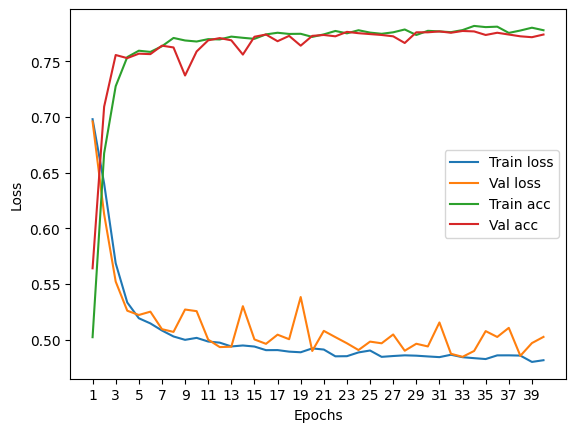

In [157]:
plot_loss(history)

Test accuracy:  77.56


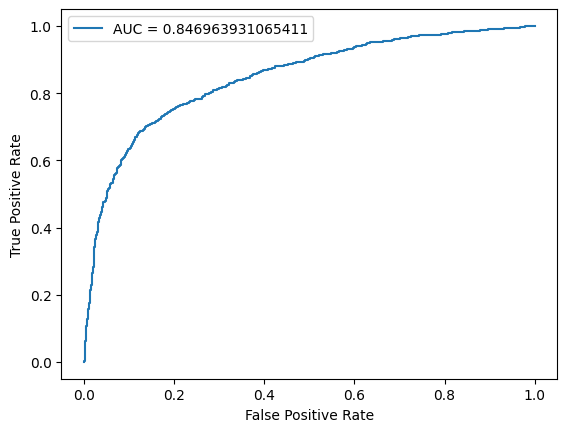

In [158]:
plot_auc(best_model, test_dataloader)

#### GAT - 5 particles, 100K jets

In [159]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-2): 3 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [130]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 86.92it/s]


Train Epoch: 0 	Loss: 0.474260, Accuracy: 5872/7500 (78%)
Val Epoch: 0 	Loss: 0.489037, Accuracy: 1938/2500 (78%)



118it [00:01, 108.28it/s]


Train Epoch: 1 	Loss: 0.474543, Accuracy: 5867/7500 (78%)
Val Epoch: 1 	Loss: 0.477644, Accuracy: 1941/2500 (78%)



118it [00:01, 106.68it/s]


Train Epoch: 2 	Loss: 0.473956, Accuracy: 5869/7500 (78%)
Val Epoch: 2 	Loss: 0.489964, Accuracy: 1938/2500 (78%)



118it [00:01, 108.59it/s]


Train Epoch: 3 	Loss: 0.473217, Accuracy: 5875/7500 (78%)
Val Epoch: 3 	Loss: 0.507557, Accuracy: 1939/2500 (78%)



118it [00:01, 107.72it/s]


Train Epoch: 4 	Loss: 0.474795, Accuracy: 5877/7500 (78%)
Val Epoch: 4 	Loss: 0.484297, Accuracy: 1940/2500 (78%)



118it [00:01, 110.04it/s]


Train Epoch: 5 	Loss: 0.475829, Accuracy: 5878/7500 (78%)
Val Epoch: 5 	Loss: 0.482124, Accuracy: 1947/2500 (78%)



118it [00:01, 109.01it/s]


Train Epoch: 6 	Loss: 0.476501, Accuracy: 5871/7500 (78%)
Val Epoch: 6 	Loss: 0.511585, Accuracy: 1940/2500 (78%)



118it [00:01, 91.08it/s]


Train Epoch: 7 	Loss: 0.474687, Accuracy: 5878/7500 (78%)
Val Epoch: 7 	Loss: 0.494100, Accuracy: 1937/2500 (77%)



118it [00:01, 73.32it/s]


Train Epoch: 8 	Loss: 0.473156, Accuracy: 5866/7500 (78%)
Val Epoch: 8 	Loss: 0.502243, Accuracy: 1943/2500 (78%)



118it [00:01, 97.98it/s] 


Train Epoch: 9 	Loss: 0.472956, Accuracy: 5867/7500 (78%)
Val Epoch: 9 	Loss: 0.485800, Accuracy: 1943/2500 (78%)



118it [00:01, 112.82it/s]


Train Epoch: 10 	Loss: 0.472686, Accuracy: 5878/7500 (78%)
Val Epoch: 10 	Loss: 0.484665, Accuracy: 1937/2500 (77%)



118it [00:01, 110.04it/s]


Train Epoch: 11 	Loss: 0.475426, Accuracy: 5862/7500 (78%)
Val Epoch: 11 	Loss: 0.481551, Accuracy: 1952/2500 (78%)



118it [00:01, 109.65it/s]


Train Epoch: 12 	Loss: 0.471955, Accuracy: 5869/7500 (78%)
Val Epoch: 12 	Loss: 0.492479, Accuracy: 1934/2500 (77%)



118it [00:01, 112.16it/s]


Train Epoch: 13 	Loss: 0.474089, Accuracy: 5849/7500 (78%)
Val Epoch: 13 	Loss: 0.479370, Accuracy: 1945/2500 (78%)



118it [00:01, 112.41it/s]


Train Epoch: 14 	Loss: 0.472494, Accuracy: 5876/7500 (78%)
Val Epoch: 14 	Loss: 0.484992, Accuracy: 1942/2500 (78%)



118it [00:01, 114.37it/s]


Train Epoch: 15 	Loss: 0.472148, Accuracy: 5893/7500 (79%)
Val Epoch: 15 	Loss: 0.493186, Accuracy: 1927/2500 (77%)



118it [00:01, 82.12it/s]


Train Epoch: 16 	Loss: 0.475858, Accuracy: 5848/7500 (78%)
Val Epoch: 16 	Loss: 0.483460, Accuracy: 1949/2500 (78%)



118it [00:01, 85.37it/s]


Train Epoch: 17 	Loss: 0.470746, Accuracy: 5874/7500 (78%)
Val Epoch: 17 	Loss: 0.480672, Accuracy: 1948/2500 (78%)



118it [00:01, 111.97it/s]


Train Epoch: 18 	Loss: 0.472505, Accuracy: 5872/7500 (78%)
Val Epoch: 18 	Loss: 0.482506, Accuracy: 1941/2500 (78%)



118it [00:01, 113.56it/s]


Train Epoch: 19 	Loss: 0.470985, Accuracy: 5869/7500 (78%)
Val Epoch: 19 	Loss: 0.481660, Accuracy: 1950/2500 (78%)



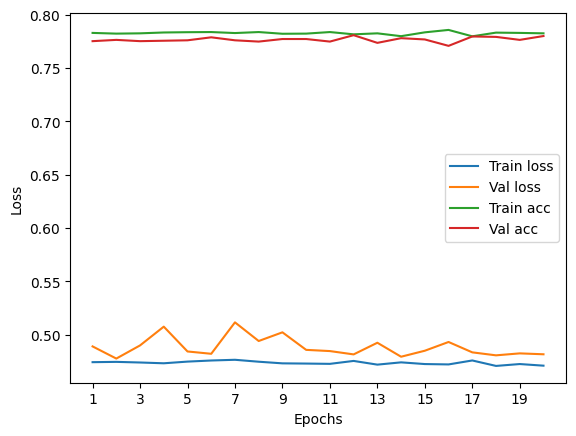

In [131]:
plot_loss(history)

Test accuracy:  77.12


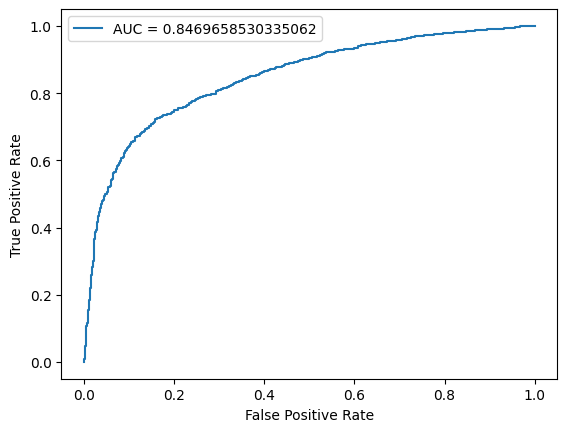

In [132]:
plot_auc(best_model, test_dataloader)

### 12500 jets

#### GAT - 10 particles

In [133]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-2): 3 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [134]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 82.03it/s]


Train Epoch: 0 	Loss: 0.693500, Accuracy: 3999/7500 (53%)
Val Epoch: 0 	Loss: 0.688200, Accuracy: 1495/2500 (60%)



118it [00:01, 96.06it/s]


Train Epoch: 1 	Loss: 0.628886, Accuracy: 5091/7500 (68%)
Val Epoch: 1 	Loss: 0.594494, Accuracy: 1824/2500 (73%)



118it [00:01, 94.51it/s]


Train Epoch: 2 	Loss: 0.552970, Accuracy: 5604/7500 (75%)
Val Epoch: 2 	Loss: 0.550952, Accuracy: 1854/2500 (74%)



118it [00:01, 90.44it/s]


Train Epoch: 3 	Loss: 0.528746, Accuracy: 5668/7500 (76%)
Val Epoch: 3 	Loss: 0.526657, Accuracy: 1860/2500 (74%)



118it [00:02, 56.26it/s]


Train Epoch: 4 	Loss: 0.514176, Accuracy: 5703/7500 (76%)
Val Epoch: 4 	Loss: 0.523860, Accuracy: 1859/2500 (74%)



118it [00:01, 90.15it/s]


Train Epoch: 5 	Loss: 0.507371, Accuracy: 5756/7500 (77%)
Val Epoch: 5 	Loss: 0.512032, Accuracy: 1886/2500 (75%)



118it [00:01, 98.35it/s] 


Train Epoch: 6 	Loss: 0.506163, Accuracy: 5728/7500 (76%)
Val Epoch: 6 	Loss: 0.525462, Accuracy: 1883/2500 (75%)



118it [00:01, 96.90it/s]


Train Epoch: 7 	Loss: 0.502314, Accuracy: 5740/7500 (77%)
Val Epoch: 7 	Loss: 0.517671, Accuracy: 1896/2500 (76%)



118it [00:01, 97.13it/s]


Train Epoch: 8 	Loss: 0.498477, Accuracy: 5756/7500 (77%)
Val Epoch: 8 	Loss: 0.508970, Accuracy: 1904/2500 (76%)



118it [00:01, 91.68it/s]


Train Epoch: 9 	Loss: 0.500384, Accuracy: 5800/7500 (77%)
Val Epoch: 9 	Loss: 0.508206, Accuracy: 1915/2500 (77%)



118it [00:03, 30.66it/s]


Train Epoch: 10 	Loss: 0.494714, Accuracy: 5787/7500 (77%)
Val Epoch: 10 	Loss: 0.505580, Accuracy: 1921/2500 (77%)



118it [00:01, 63.42it/s]


Train Epoch: 11 	Loss: 0.494018, Accuracy: 5802/7500 (77%)
Val Epoch: 11 	Loss: 0.500873, Accuracy: 1927/2500 (77%)



118it [00:01, 97.00it/s]


Train Epoch: 12 	Loss: 0.492219, Accuracy: 5781/7500 (77%)
Val Epoch: 12 	Loss: 0.502452, Accuracy: 1911/2500 (76%)



118it [00:01, 92.60it/s]


Train Epoch: 13 	Loss: 0.492257, Accuracy: 5808/7500 (77%)
Val Epoch: 13 	Loss: 0.496258, Accuracy: 1910/2500 (76%)



118it [00:01, 97.42it/s]


Train Epoch: 14 	Loss: 0.488689, Accuracy: 5801/7500 (77%)
Val Epoch: 14 	Loss: 0.495396, Accuracy: 1920/2500 (77%)



118it [00:01, 93.36it/s]


Train Epoch: 15 	Loss: 0.489669, Accuracy: 5791/7500 (77%)
Val Epoch: 15 	Loss: 0.501275, Accuracy: 1918/2500 (77%)



118it [00:01, 95.32it/s]


Train Epoch: 16 	Loss: 0.489339, Accuracy: 5780/7500 (77%)
Val Epoch: 16 	Loss: 0.507622, Accuracy: 1928/2500 (77%)



118it [00:01, 72.28it/s]


Train Epoch: 17 	Loss: 0.486085, Accuracy: 5814/7500 (78%)
Val Epoch: 17 	Loss: 0.493011, Accuracy: 1916/2500 (77%)



118it [00:01, 75.89it/s]


Train Epoch: 18 	Loss: 0.485811, Accuracy: 5832/7500 (78%)
Val Epoch: 18 	Loss: 0.489917, Accuracy: 1930/2500 (77%)



118it [00:01, 92.82it/s]


Train Epoch: 19 	Loss: 0.485479, Accuracy: 5818/7500 (78%)
Val Epoch: 19 	Loss: 0.499909, Accuracy: 1926/2500 (77%)



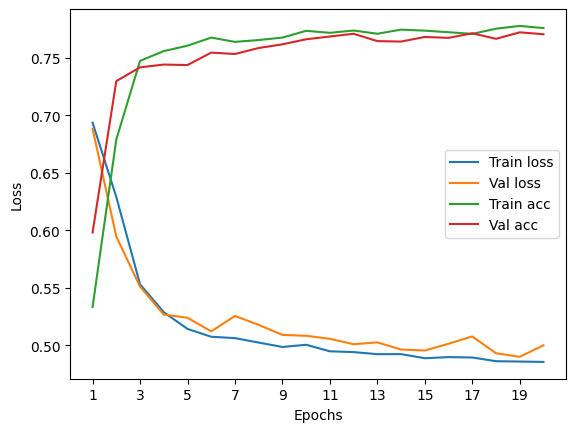

In [135]:
plot_loss(history)

Test accuracy:  76.44


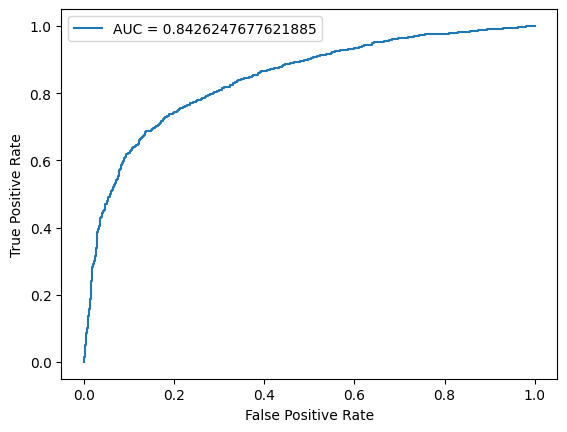

In [136]:
plot_auc(best_model, test_dataloader)

#### GAT  - 5 particles

In [137]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-2): 3 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [138]:
a = [p.numel() for p in model.parameters()]
a, sum(a)

([10,
  80,
  160,
  8,
  8,
  1,
  16,
  160,
  256,
  8,
  8,
  1,
  8,
  128,
  128,
  8,
  8,
  1,
  104,
  8,
  8,
  1],
 1118)

In [139]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 93.73it/s]


Train Epoch: 0 	Loss: 0.687646, Accuracy: 4361/7500 (58%)
Val Epoch: 0 	Loss: 0.690014, Accuracy: 1377/2500 (55%)



118it [00:01, 92.81it/s]


Train Epoch: 1 	Loss: 0.666721, Accuracy: 4525/7500 (60%)
Val Epoch: 1 	Loss: 0.670027, Accuracy: 1622/2500 (65%)



118it [00:01, 95.49it/s]


Train Epoch: 2 	Loss: 0.643687, Accuracy: 5296/7500 (71%)
Val Epoch: 2 	Loss: 0.641844, Accuracy: 1843/2500 (74%)



118it [00:01, 91.77it/s]


Train Epoch: 3 	Loss: 0.613032, Accuracy: 5677/7500 (76%)
Val Epoch: 3 	Loss: 0.605831, Accuracy: 1922/2500 (77%)



118it [00:01, 80.79it/s]


Train Epoch: 4 	Loss: 0.571732, Accuracy: 5727/7500 (76%)
Val Epoch: 4 	Loss: 0.551363, Accuracy: 1925/2500 (77%)



118it [00:01, 72.27it/s]


Train Epoch: 5 	Loss: 0.525083, Accuracy: 5707/7500 (76%)
Val Epoch: 5 	Loss: 0.525116, Accuracy: 1923/2500 (77%)



118it [00:01, 93.88it/s]


Train Epoch: 6 	Loss: 0.504787, Accuracy: 5752/7500 (77%)
Val Epoch: 6 	Loss: 0.514815, Accuracy: 1923/2500 (77%)



118it [00:01, 95.58it/s]


Train Epoch: 7 	Loss: 0.497955, Accuracy: 5782/7500 (77%)
Val Epoch: 7 	Loss: 0.499468, Accuracy: 1924/2500 (77%)



118it [00:01, 94.97it/s]


Train Epoch: 8 	Loss: 0.494269, Accuracy: 5773/7500 (77%)
Val Epoch: 8 	Loss: 0.509684, Accuracy: 1931/2500 (77%)



118it [00:01, 88.45it/s]


Train Epoch: 9 	Loss: 0.490210, Accuracy: 5788/7500 (77%)
Val Epoch: 9 	Loss: 0.505536, Accuracy: 1927/2500 (77%)



118it [00:01, 96.58it/s]


Train Epoch: 10 	Loss: 0.489988, Accuracy: 5810/7500 (77%)
Val Epoch: 10 	Loss: 0.499368, Accuracy: 1928/2500 (77%)



118it [00:01, 94.54it/s]


Train Epoch: 11 	Loss: 0.488159, Accuracy: 5774/7500 (77%)
Val Epoch: 11 	Loss: 0.504358, Accuracy: 1929/2500 (77%)



118it [00:01, 71.76it/s]


Train Epoch: 12 	Loss: 0.487130, Accuracy: 5822/7500 (78%)
Val Epoch: 12 	Loss: 0.494384, Accuracy: 1916/2500 (77%)



118it [00:01, 79.50it/s]


Train Epoch: 13 	Loss: 0.486372, Accuracy: 5814/7500 (78%)
Val Epoch: 13 	Loss: 0.499811, Accuracy: 1921/2500 (77%)



118it [00:01, 94.70it/s]


Train Epoch: 14 	Loss: 0.486422, Accuracy: 5801/7500 (77%)
Val Epoch: 14 	Loss: 0.498224, Accuracy: 1933/2500 (77%)



118it [00:01, 93.16it/s]


Train Epoch: 15 	Loss: 0.485043, Accuracy: 5823/7500 (78%)
Val Epoch: 15 	Loss: 0.491643, Accuracy: 1924/2500 (77%)



118it [00:01, 96.12it/s]


Train Epoch: 16 	Loss: 0.487406, Accuracy: 5825/7500 (78%)
Val Epoch: 16 	Loss: 0.493739, Accuracy: 1925/2500 (77%)



118it [00:01, 94.72it/s]


Train Epoch: 17 	Loss: 0.484628, Accuracy: 5818/7500 (78%)
Val Epoch: 17 	Loss: 0.489256, Accuracy: 1934/2500 (77%)



118it [00:01, 97.62it/s]


Train Epoch: 18 	Loss: 0.483743, Accuracy: 5817/7500 (78%)
Val Epoch: 18 	Loss: 0.494299, Accuracy: 1938/2500 (78%)



118it [00:01, 89.28it/s]


Train Epoch: 19 	Loss: 0.483609, Accuracy: 5841/7500 (78%)
Val Epoch: 19 	Loss: 0.495013, Accuracy: 1933/2500 (77%)



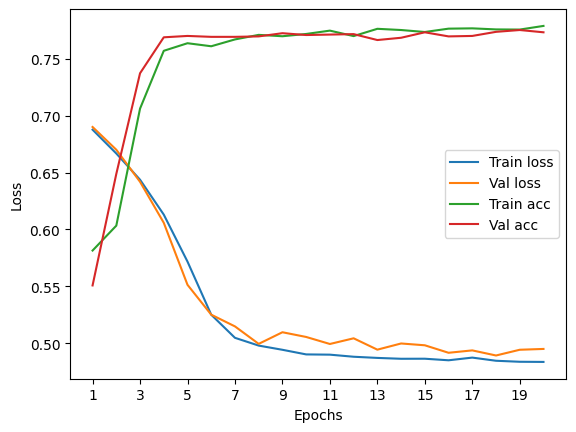

In [140]:
plot_loss(history)

Test accuracy:  76.68


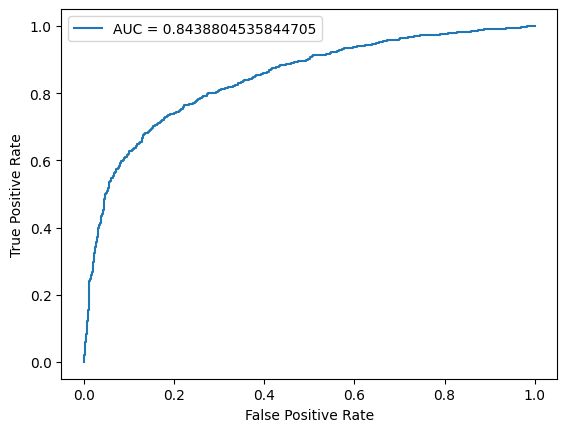

In [141]:
plot_auc(model, test_dataloader)

#### GAT

In [142]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-2): 3 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [143]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 67.73it/s]


Train Epoch: 0 	Loss: 0.693969, Accuracy: 3768/7500 (50%)
Val Epoch: 0 	Loss: 0.699346, Accuracy: 1316/2500 (53%)



118it [00:01, 98.39it/s]


Train Epoch: 1 	Loss: 0.654511, Accuracy: 5012/7500 (67%)
Val Epoch: 1 	Loss: 0.609609, Accuracy: 1781/2500 (71%)



118it [00:01, 95.45it/s]


Train Epoch: 2 	Loss: 0.565882, Accuracy: 5622/7500 (75%)
Val Epoch: 2 	Loss: 0.556185, Accuracy: 1848/2500 (74%)



118it [00:01, 96.94it/s]


Train Epoch: 3 	Loss: 0.535929, Accuracy: 5667/7500 (76%)
Val Epoch: 3 	Loss: 0.532354, Accuracy: 1887/2500 (75%)



118it [00:01, 94.47it/s]


Train Epoch: 4 	Loss: 0.522236, Accuracy: 5725/7500 (76%)
Val Epoch: 4 	Loss: 0.527916, Accuracy: 1870/2500 (75%)



118it [00:01, 98.86it/s]


Train Epoch: 5 	Loss: 0.516109, Accuracy: 5730/7500 (76%)
Val Epoch: 5 	Loss: 0.530006, Accuracy: 1893/2500 (76%)



118it [00:01, 101.85it/s]


Train Epoch: 6 	Loss: 0.510861, Accuracy: 5736/7500 (76%)
Val Epoch: 6 	Loss: 0.515743, Accuracy: 1898/2500 (76%)



118it [00:01, 74.68it/s]


Train Epoch: 7 	Loss: 0.509171, Accuracy: 5753/7500 (77%)
Val Epoch: 7 	Loss: 0.526639, Accuracy: 1901/2500 (76%)



118it [00:01, 73.73it/s]


Train Epoch: 8 	Loss: 0.504589, Accuracy: 5754/7500 (77%)
Val Epoch: 8 	Loss: 0.499499, Accuracy: 1909/2500 (76%)



118it [00:01, 95.28it/s]


Train Epoch: 9 	Loss: 0.501299, Accuracy: 5784/7500 (77%)
Val Epoch: 9 	Loss: 0.520682, Accuracy: 1893/2500 (76%)



118it [00:01, 96.70it/s]


Train Epoch: 10 	Loss: 0.498817, Accuracy: 5789/7500 (77%)
Val Epoch: 10 	Loss: 0.507034, Accuracy: 1910/2500 (76%)



118it [00:01, 98.81it/s] 


Train Epoch: 11 	Loss: 0.498631, Accuracy: 5803/7500 (77%)
Val Epoch: 11 	Loss: 0.519036, Accuracy: 1914/2500 (77%)



118it [00:01, 100.48it/s]


Train Epoch: 12 	Loss: 0.495164, Accuracy: 5801/7500 (77%)
Val Epoch: 12 	Loss: 0.519954, Accuracy: 1920/2500 (77%)



118it [00:01, 100.75it/s]


Train Epoch: 13 	Loss: 0.492957, Accuracy: 5817/7500 (78%)
Val Epoch: 13 	Loss: 0.506449, Accuracy: 1915/2500 (77%)



118it [00:01, 95.62it/s]


Train Epoch: 14 	Loss: 0.492800, Accuracy: 5778/7500 (77%)
Val Epoch: 14 	Loss: 0.511023, Accuracy: 1909/2500 (76%)



118it [00:01, 69.15it/s]


Train Epoch: 15 	Loss: 0.491980, Accuracy: 5813/7500 (78%)
Val Epoch: 15 	Loss: 0.495487, Accuracy: 1928/2500 (77%)



118it [00:02, 58.58it/s]


Train Epoch: 16 	Loss: 0.488388, Accuracy: 5806/7500 (77%)
Val Epoch: 16 	Loss: 0.495304, Accuracy: 1916/2500 (77%)



118it [00:01, 63.88it/s]


Train Epoch: 17 	Loss: 0.490944, Accuracy: 5812/7500 (77%)
Val Epoch: 17 	Loss: 0.492650, Accuracy: 1927/2500 (77%)



118it [00:01, 68.04it/s]


Train Epoch: 18 	Loss: 0.490706, Accuracy: 5807/7500 (77%)
Val Epoch: 18 	Loss: 0.492927, Accuracy: 1937/2500 (77%)



118it [00:01, 94.60it/s]


Train Epoch: 19 	Loss: 0.487140, Accuracy: 5819/7500 (78%)
Val Epoch: 19 	Loss: 0.491592, Accuracy: 1922/2500 (77%)



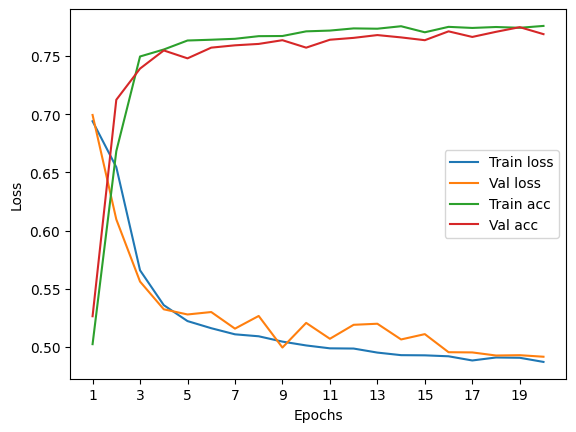

In [144]:
plot_loss(history)

Test accuracy:  76.55999999999999


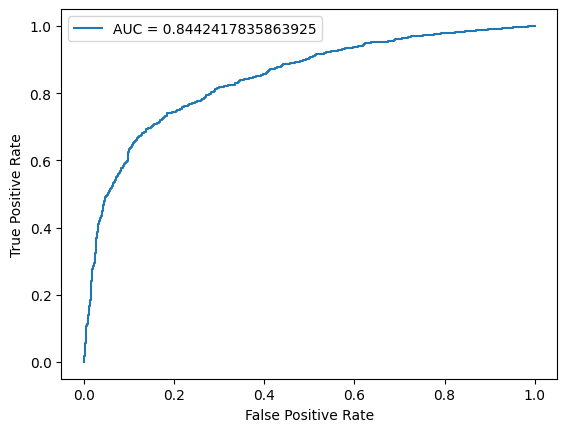

In [145]:
plot_auc(best_model, test_dataloader)

#### GCN

In [160]:
model = GCN(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GCN(
  (layers): ModuleList(
    (0-2): 3 x GCNConv()
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

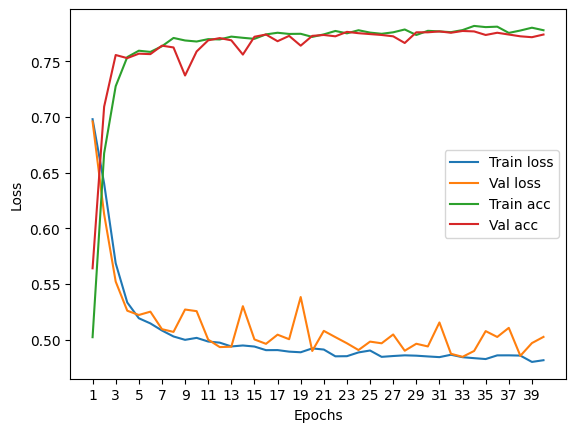

In [162]:
plot_loss(history)

#### Learning rate = 1e-2

In [170]:
model = GCN(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GCN(
  (layers): ModuleList(
    (0-2): 3 x GCNConv()
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
plot_loss(history)

### Parameterized quantum circuit - Node Embedding QNN

In [173]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def encoder(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def Rot_layer(gate, w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        gate(element, wires=idx)


def entangling_layer(nqubits):
    """Layers of CZ and RY gates.
    """
    for i in range(0, nqubits - 1):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])

    qml.CNOT(wires=[nqubits-1, 0])

In [174]:
def quantum_net(n_qubits, q_depth):

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum circuit.
        """

        # Reshape weights
        q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(q_depth):
            Rot_layer(qml.RY, q_weights[k][0])
            entangling_layer(n_qubits)
            Rot_layer(qml.RZ, q_weights[k][1])

        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
        return exp_vals

    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*q_depth*n_qubits)}), quantum_circuit

### Visualizing the quantum layer

In [175]:
_, qc = quantum_net(8,1)
inputs = torch.randn(8)
params = torch.randn(2*8)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-0.41)─╭●───────────────────╭X──RZ(0.02)──┤  <Z>
1: ─├AngleEmbedding(M0)──RY(0.08)──╰X─╭●────────────────│───RZ(0.05)──┤  <Z>
2: ─├AngleEmbedding(M0)──RY(-0.10)────╰X─╭●─────────────│───RZ(-1.24)─┤  <Z>
3: ─├AngleEmbedding(M0)──RY(-0.42)───────╰X─╭●──────────│───RZ(-0.56)─┤  <Z>
4: ─├AngleEmbedding(M0)──RY(0.25)───────────╰X─╭●───────│───RZ(1.17)──┤  <Z>
5: ─├AngleEmbedding(M0)──RY(-0.57)─────────────╰X─╭●────│───RZ(0.92)──┤  <Z>
6: ─├AngleEmbedding(M0)──RY(0.35)─────────────────╰X─╭●─│───RZ(-0.05)─┤  <Z>
7: ─╰AngleEmbedding(M0)──RY(0.13)────────────────────╰X─╰●──RZ(0.47)──┤  <Z>

M0 = 
tensor([ 1.4687,  0.6915, -1.4321, -0.2672,  1.6790,  1.0876,  2.2087,  0.3476])


In [176]:
batch_dim = 5
x = torch.zeros((batch_dim, 3))
qlayer, _ = quantum_net(3,1)
qlayer(x).shape

torch.Size([5, 3])

### Quantum Classifier

### 1. Matrix Product State Classifier

In [177]:
def MPS(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """

        # Reshape weights
        q_weights = q_weights_flat[:-1].reshape(n_qubits-1, 2)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(n_qubits-1):
            qml.RY(q_weights[k][0], wires=k)
            qml.RY(q_weights[k][1], wires=k+1)
            qml.CZ(wires=[k,k+1])

        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]
        # return [qml.expval(qml.operation.CVObservable(q_weights_flat[-1], qml.PauliZ(n_qubits - 1)))]

    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*n_qubits - 1)}), quantum_circuit

In [178]:
_, qc = MPS(6)
inputs = torch.randn(6)
params = torch.randn(2*6-1)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-0.17)─╭●──────────────────────────────────────────────────────
1: ─├AngleEmbedding(M0)──RY(1.60)──╰Z──RY(0.07)─╭●─────────────────────────────────────────
2: ─├AngleEmbedding(M0)──RY(-0.87)──────────────╰Z──RY(1.74)─╭●────────────────────────────
3: ─├AngleEmbedding(M0)──RY(-2.35)───────────────────────────╰Z──RY(-0.35)─╭●──────────────
4: ─├AngleEmbedding(M0)──RY(-1.05)─────────────────────────────────────────╰Z──RY(-0.67)─╭●
5: ─╰AngleEmbedding(M0)──RY(0.69)────────────────────────────────────────────────────────╰Z

─────────────┤     
─────────────┤     
─────────────┤     
─────────────┤     
─────────────┤     
───RY(-0.54)─┤  <Z>

M0 = 
tensor([-0.1231,  1.7047,  0.2194, -2.0932, -0.3683, -2.1188])


### 2. Tensor Tree Network Classifier

In [179]:
def TTN(n_qubits):

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        n_layers = int(np.log2(n_qubits))
        i = 0
        n_params = int(2**(np.log2(n_qubits)+1)-2 +1)

        for layer in range(n_layers):
            n_gates = n_qubits//(2**(layer+1))
            for j in range(n_gates):
                qubit0 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**layer - 1
                qubit1 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**(layer+1) - 1
                qml.RY(q_weights_flat[i], wires=qubit0)
                qml.RY(q_weights_flat[i+1], wires=qubit1)
                qml.CZ(wires=[qubit0,qubit1])
                i += 2

        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]

    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": int(2**(np.log2(n_qubits)+1)-2 +1)}), quantum_circuit

In [180]:
_, qc = TTN(8)
inputs = torch.randn(8)
params = torch.randn(int(2**(np.log2(8)+1)-2 +1))
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(1.69)──╭●────────────────────────────────────────┤     
1: ─├AngleEmbedding(M0)──RY(0.82)──╰Z──RY(0.79)──╭●──────────────────────────┤     
2: ─├AngleEmbedding(M0)──RY(-0.27)─╭●────────────│───────────────────────────┤     
3: ─├AngleEmbedding(M0)──RY(-0.63)─╰Z──RY(-0.55)─╰Z──RY(-0.17)─╭●────────────┤     
4: ─├AngleEmbedding(M0)──RY(0.77)──╭●──────────────────────────│─────────────┤     
5: ─├AngleEmbedding(M0)──RY(-0.61)─╰Z──RY(0.94)──╭●────────────│─────────────┤     
6: ─├AngleEmbedding(M0)──RY(0.64)──╭●────────────│─────────────│─────────────┤     
7: ─╰AngleEmbedding(M0)──RY(0.86)──╰Z──RY(-0.83)─╰Z──RY(-0.94)─╰Z──RY(-0.08)─┤  <Z>

M0 = 
tensor([-2.0013, -0.8022,  0.4389,  0.2997,  1.3314, -1.2411,  1.4708,  0.2401])


### Quantum Enhanced GAT

In [181]:
class QGATConv(MessagePassing):
    def __init__(self, in_channels, depth, attn_model):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        self.qc, _ = quantum_net(self.n_qubits, depth)

        if attn_model == "MPS":
            self.attn, _ = MPS(in_channels*2)
        else:
            self.attn, _ = TTN(in_channels*2)

        self.readout = Linear(1, 1)
        self.attn = Linear(in_channels*2, 1)


    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix

        q_out = self.qc(x).float()

        # Step 3: Compute normalization.
#         row, col = edge_index
#         deg = degree(col, q_out.size(0), dtype=q_out.dtype)
#         deg_inv_sqrt = deg.pow(-0.5)
#         deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_i, x_j):
        # x_j has shape [E, out_channels]

        x_edge = torch.cat((x_i,x_j),dim=1)
        x_edge = self.attn(x_edge)
        x_edge = self.readout(x_edge)
        return x_edge.view(-1, 1) * x_j

In [182]:
class QGAT(nn.Module):

    def __init__(self, input_dims, depth, n_layers, activ_fn = LeakyReLU(0.2), classifier="MPS", attn_model="MPS"):

        super().__init__()
        layers = []

        for i in range(n_layers):
            layers.append(QGATConv(input_dims, depth, attn_model))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        if classifier == "MPS" :
            self.classifier, _ = MPS(input_dims+5)
        elif classifier == "TTN":
            self.classifier, _ = TTN(input_dims+5)

        self.readout = Linear(1,1)

    def forward(self, x, edge_index, edge_attr, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        h = self.readout(h)
        return h

### Quantum-enhanced GCN

In [183]:
class QGCNConv(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        self.qc, _ = quantum_net(self.n_qubits, q_depth)

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_weights):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix

        q_out = self.qc(x).float()

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, q_out.size(0), dtype=q_out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out, weights=edge_weights, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, weights, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [184]:
class QGCN(nn.Module):

    def __init__(self, input_dims, output_dims, activ_fn = LeakyReLU(0.2), classifier = None, readout = False):

        super().__init__()
        layers = [QGCNConv(input_dims)]
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn

        if readout:
            self.readout = Linear(1, 1)
        else:
            self.readout = None

        if classifier == "MPS" :
            assert output_dims == 1
            self.classifier, _ = MPS(input_dims+5)
        elif classifier == "TTN":
            assert output_dims == 1
            self.classifier, _ = TTN(input_dims+5)
        else:
            self.classifier = nn.Linear(input_dims+5, output_dims)

    def forward(self, x, edge_index, edge_weights, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weights)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch

        h = torch.cat((h, graph_features.reshape(-1,5)), dim=1)
        h = self.classifier(h)

        if self.readout is not None:
            h = self.readout(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

### QGCN with classical classifier

In [199]:
model = QGCN(input_dims, output_dims)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (classifier): Linear(in_features=6, out_features=1, bias=True)
)

In [198]:
class QGCNConv(MessagePassing):
    def __init__(self, input_dims, output_dims, q_depth=3, activ_fn=LeakyReLU(0.2)):  # Modified __init__ signature
        super().__init__(aggr='add')
        self.q_depth = q_depth
        self.activ_fn = activ_fn

        self.q_params = nn.Parameter(torch.randn(q_depth * 2 * input_dims), requires_grad=True)
        self.qlayer, _ = quantum_net(input_dims, q_depth)
        self.lin = Linear(input_dims, output_dims, bias=False)
        self.bias = nn.Parameter(torch.empty(output_dims))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, x.shape[1])

        for xi in x:
            q_out_elem = self.qlayer(xi, self.q_params).float().unsqueeze(0)  # Pass q_params to qlayer
            q_out = torch.cat((q_out, q_out_elem))

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        out = self.lin(q_out)  # Use q_out here

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, out.size(0), dtype=out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=out, norm=norm)  # Use out here

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [187]:
[p.numel() for p in model.parameters()]

[8, 48, 13, 1]

In [201]:
model = model.float()


In [194]:
class QGCN(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = ModuleList([QGCNConv(input_dims, output_dims) for _ in range(1)])
        self.classifier = nn.Linear(output_dims+5, 1) # Output dim was incorrect causing mismatch in dimensions
                                                      # Changed to output_dims + 5

    def forward(self, x, edge_index, edge_weights, batch, graph_features):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weights)

        h = global_mean_pool(h, batch)
        # Ensure graph_features is of type float32 before concatenation
        h = torch.cat((h, graph_features.type(torch.float32).reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

Test accuracy:  77.08


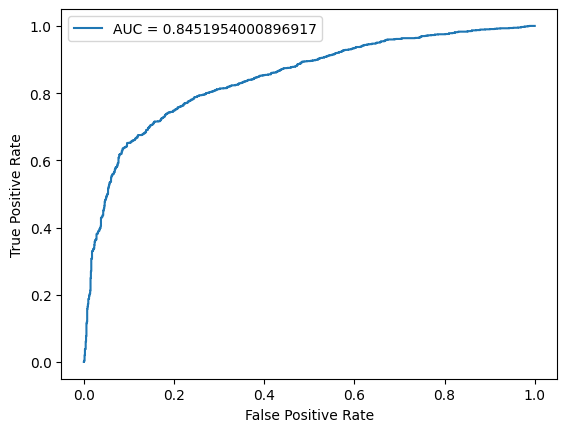

In [214]:
plot_auc(model, test_dataloader)